# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [18]:
%matplotlib inline
import cv2
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sys


!ls ../input/

hw-fish1  hw-fish3  test-stg2
hw-fish2  hw_fish   the-nature-conservancy-fisheries-monitoring


# Загружаем разметку

In [19]:
import os
import json
from glob import glob

# TODO: скачайте данные и сохраните в директорию:
TRAIN_PREFIX = '../input/the-nature-conservancy-fisheries-monitoring/train'

def load_boxes():
    boxes = dict()
    for path in glob('../input/hw-fish3/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        print('label = ', label)
        with open(path) as src:
            boxes[label] = json.load(src)
            for annotation in boxes[label]:
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(TRAIN_PREFIX, label.upper(), basename)
                annotation['fish_class'] = label
            for annotation in boxes[label]:
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
    #print('annotation = ', annotation)
    #print('boxes = ', boxes)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    #print(annotation)
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation['annotations'], scale_x, scale_y)
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [20]:
boxes = load_boxes()  # разметка детекций
print(list(boxes.keys()))
#print('boxes = ', boxes['lag'][1])

label =  lag
label =  shark
label =  yft
label =  dol
label =  bet
label =  alb
label =  other
['lag', 'shark', 'yft', 'dol', 'bet', 'alb', 'other']


In [21]:
pd.DataFrame([(k, len(v)) for k, v in boxes.items()],
             columns=['class', 'count'])

,class,count
0,lag,67
1,shark,176
2,yft,734
3,dol,117
4,bet,200
5,alb,1719
6,other,235


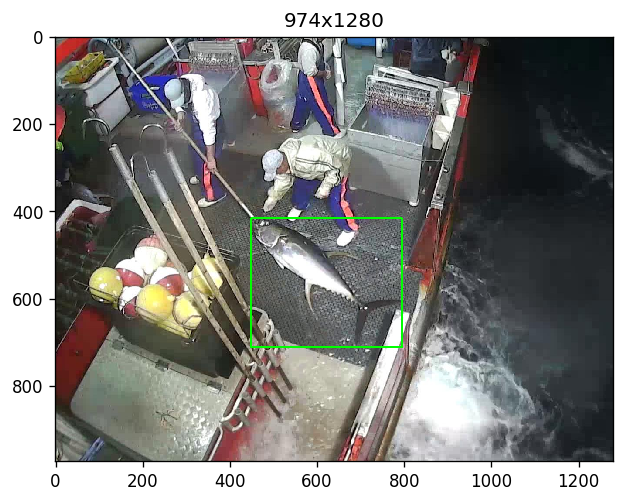

In [22]:
plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(boxes['yft'][60])
plt.imshow(img)
plt.title('{}x{}'.format(*img.shape));

### Распределение размеров разметки

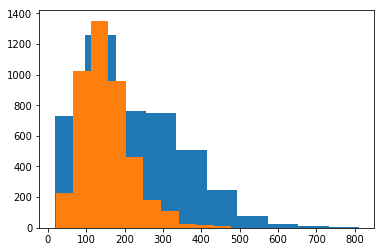

In [23]:
annotations = sum([box['annotations']
                  for box in sum(boxes.values(), [])], [])

#print('annotations = ', annotations)

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [24]:
IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = keras.applications.vgg16.VGG16(include_top=False,
                                          weights='imagenet',
                                          input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

feature_tensor = features.layers[-1].output
print('feature_tensor = ', feature_tensor)

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False

#features.summary()

feature_tensor =  Tensor("block5_pool_1/MaxPool:0", shape=(?, 23, 37, 512), dtype=float32)


# Сетка якорей (anchor grid)

In [25]:
FEATURE_SHAPE = (feature_tensor.shape[1].value,
                 feature_tensor.shape[2].value)

#print('features = ', features.summary())
#print('FEATURE_SHAPE = ', feature_tensor.shape)

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

#print(ANCHOR_CENTERS)

In [27]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    #print('annotation = ', annotation)
    #print('img_shape = ', img_shape)
    #print('iou_thr = ', iou_thr)
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 12), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)
        #print('scores = ', scores)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            fc = annotation['fish_class'].lower()
            encoded[row, col] = [1, float(fc == 'lag'), float(fc == 'shark'), float(fc == 'ytf'), float(fc == 'dol'), float(fc == 'bet'), float(fc == 'alb'), float(fc == 'other'),dx, dy, dw, dh]
            
    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            logit, lag, shark, yft, dol, bet, alb, other, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(logit)
            lag = _sigmoid(lag)
            shark = _sigmoid(shark)
            yft = _sigmoid( yft)
            dol = _sigmoid(dol)
            bet = _sigmoid(bet)
            alb = _sigmoid(alb)
            other = _sigmoid(other)
            
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf,
                                   'lag': lag,
                                   'shark': shark,
                                   'yft': yft,
                                   'dol': dol,
                                   'bet': bet,
                                   'alb': alb,
                                   'other': other
                                  })
    return rectangles

### Валидация енкодинга/декодинга

exmaple =  {'annotations': [{'class': 'rect', 'height': 182.0000000000008, 'width': 322.0000000000015, 'x': 780.0000000000034, 'y': 170.00000000000074}], 'class': 'image', 'filename': '../input/the-nature-conservancy-fisheries-monitoring/train/ALB/img_07223.jpg', 'fish_class': 'alb'}
encoded shape =  (23, 37, 12)
decoded =  [{'x': 780.0000008699058, 'y': 170.00000021703866, 'width': 321.9999969005585, 'height': 182.00000077486038, 'conf': 0.731058573739949, 'lag': 0.5, 'shark': 0.5, 'yft': 0.5, 'dol': 0.5, 'bet': 0.5, 'alb': 0.731058573739949, 'other': 0.5}]


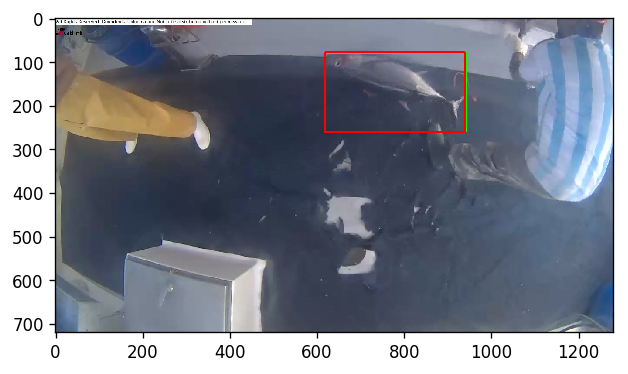

In [28]:
example = boxes['alb'][175]
print('exmaple = ', example)

encoded = encode_anchors(example, (IMG_HEIGHT, IMG_WIDTH))

np.set_printoptions(threshold=10)
print('encoded shape = ', encoded.shape)

decoded = decode_prediction(encoded, conf_thr=0.5)
print('decoded = ', decoded)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(example, decoded[:12]))

## Функция потерь

In [36]:
from keras.callbacks import Callback
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0], 
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def classification_loss(y_true, y_pred):
    class_loss = K.categorical_crossentropy(y_true[..., 1:8], 
                                      y_pred[..., 1:8],
                                      from_logits=True)
    
    pos_class_loss_1 = K.sum(class_loss * y_true[..., 1], axis=-1)
    pos_class_loss_2 = K.sum(class_loss * y_true[..., 2], axis=-1)
    pos_class_loss_3 = K.sum(class_loss * y_true[..., 3], axis=-1)
    pos_class_loss_4 = K.sum(class_loss * y_true[..., 4], axis=-1)
    pos_class_loss_5 = K.sum(class_loss * y_true[..., 5], axis=-1)
    pos_class_loss_6 = K.sum(class_loss * y_true[..., 6], axis=-1)
    pos_class_loss_7 = K.sum(class_loss * y_true[..., 7], axis=-1)
    
    num_pos_1 = K.sum(y_true[..., 1], axis=-1)
    num_pos_2 = K.sum(y_true[..., 2], axis=-1)
    num_pos_3 = K.sum(y_true[..., 3], axis=-1)
    num_pos_4 = K.sum(y_true[..., 4], axis=-1)
    num_pos_5 = K.sum(y_true[..., 5], axis=-1)
    num_pos_6 = K.sum(y_true[..., 6], axis=-1)
    num_pos_7 = K.sum(y_true[..., 7], axis=-1)
    
    total_class_loss_1 = pos_class_loss_1 / (num_pos_1 + 1e-32)
    total_class_loss_2 = pos_class_loss_2 / (num_pos_2 + 1e-32)
    total_class_loss_3 = pos_class_loss_3 / (num_pos_3 + 1e-32)
    total_class_loss_4 = pos_class_loss_4 / (num_pos_4 + 1e-32)
    total_class_loss_5 = pos_class_loss_5 / (num_pos_5 + 1e-32)
    total_class_loss_6 = pos_class_loss_6 / (num_pos_6 + 1e-32)
    total_class_loss_7 = pos_class_loss_7 / (num_pos_7 + 1e-32)
    
    loss = total_class_loss_1 + total_class_loss_2 + total_class_loss_3 + total_class_loss_4 + total_class_loss_5 + total_class_loss_6 + total_class_loss_7
    return loss / 7


def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 8:] - y_pred[..., 8:])
    square_loss = 0.5 * K.square(y_true[..., 8:] - y_pred[..., 8:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)



@tf.contrib.eager.defun
def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    # TODO: добавьте функцию потерь для классификации детекции
    
    y_true = K.reshape(y_true, (batch_size, -1, 12))
    y_pred = K.reshape(y_pred, (batch_size, -1, 12))
    
    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # class loss
    class_loss = classification_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    print('anchors', anchors)
    num_pos = K.sum(y_true[..., 0], axis=-1)
    print('num_pos', num_pos)
    
    num_pos_avg = K.mean(num_pos)
    print('num_pos_avg', num_pos_avg)
    
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    print('num_neg', num_neg)
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # class loss negative 
    #neg_class_loss, _ = tf.nn.top_k(class_loss * (1. - y_true[..., 1:7]),
    #                               k=K.cast(num_neg, 'int32'))

    #neg_class_loss = K.sum(neg_class_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    
    # total class loss
    #total_class_loss = class_loss
    
    loss = total_conf_loss + 0.5 * loc_loss + 0.25 * class_loss
    return loss

## Загрузка данных

In [37]:
def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, keras.applications.vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        #print('gen data', boxes)
        random.shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                # TODO: добавьте one-hot encoding в разметку для классов
                y.append(encode_anchors(boxes[j], img_shape))
                X.append(img)
            print('np.array(X).shape', np.array(X).shape)
            print('np.array(y).shape', np.array(y).shape)
            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [38]:
output = keras.layers.BatchNormalization()(feature_tensor)
print('otput.shape', output.shape)

# TODO: добавьте выходы для классификации детекции
output = keras.layers.Conv2D(12,
                             kernel_size=(1, 1), 
                             activation='linear',
                             padding="same",
                             kernel_regularizer='l2')(output)
print(output)
#output = keras.layers.Flatten()(output)
#output = keras.layers.Dense(12, activation='relu')(output)
#output = keras.layers.Dense(12, activation='softmax')(output)
print(features.inputs)
model = keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

otput.shape (?, 23, 37, 512)
Tensor("conv2d_2/BiasAdd:0", shape=(?, 23, 37, 12), dtype=float32)
[<tf.Tensor 'input_2:0' shape=(?, 750, 1200, 3) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 750, 1200, 3)      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 750, 1200, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 750, 1200, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 375, 600, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 375, 600, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 375, 600, 12

## Обучение

In [39]:
adam = keras.optimizers.Adam(lr=3e-4, decay=1e-6)
model.compile(optimizer=adam, 
              loss=total_loss,
              metrics={'conf_loss': confidence_loss})

anchors Tensor("strided_slice_25:0", shape=(), dtype=int32)
num_pos Tensor("Sum_17:0", shape=(?,), dtype=float32)
num_pos_avg Tensor("Mean:0", shape=(), dtype=float32)
num_neg Tensor("Min:0", shape=(), dtype=float32)


In [40]:
class ComputeMetrics(Callback):
    def on_epoch_end(self, epoch, logs):
        logs['val_metric'] = epoch ** 2  # replace it with your metrics
        if (epoch + 1) % 10 == 0:
            logs['test_metric'] = epoch ** 3  # same
        else:
            logs['test_metric'] = np.nan
            
batch_size = 5
steps_per_epoch = int(sum(map(len, boxes.values()), 0) / batch_size)
print(steps_per_epoch)

gen = data_generator(boxes, batch_size=batch_size)

checkpoint = keras.callbacks.ModelCheckpoint(
    'weights.{epoch:02d}-{loss:.3f}.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto', period=1)

lambda_cb = keras.callbacks.LambdaCallback(
    on_batch_begin=lambda batch,logs: print('!!!!!!++++', batch)
)

model.fit_generator(generator=gen, 
                    steps_per_epoch=steps_per_epoch,
                    epochs=1,
                    callbacks=[checkpoint]
    )

649
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
  1/649 [..............................] - ETA: 52:29 - loss: 9.1725np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
  2/649 [.........

 57/649 [=>............................] - ETA: 4:14 - loss: 2.4705np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
 58/649 [=>............................] - ETA: 4:13 - loss: 2.4437np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
 59/649 [=>............................] - ETA: 4:11 - loss: 2.4159np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
 60/649 [=>............................] - ETA: 4:10 - loss: 2.3904np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
 61/649 [=>............................] - ETA: 4:09 - loss: 2.3662np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
 62/649 [=>............................] - ETA: 4:08 - loss: 2.3420np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
 63/649 [=>............................] - ETA: 4:07 - loss: 2.3182np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
 64/649 [=>............................] 

121/649 [====>.........................] - ETA: 3:25 - loss: 1.6098np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
122/649 [====>.........................] - ETA: 3:25 - loss: 1.6029np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
123/649 [====>.........................] - ETA: 3:24 - loss: 1.5959np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
124/649 [====>.........................] - ETA: 3:24 - loss: 1.5891np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
125/649 [====>.........................] - ETA: 3:23 - loss: 1.5822np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
127/649 [====>.........................] - ETA: 3:22 - loss: 1.5707np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
128/649 [====>.........................] - ETA: 3:22 - loss: 1.5645np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
129/649 [====>.........................] 

183/649 [=======>......................] - ETA: 2:55 - loss: 1.3200np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
184/649 [=======>......................] - ETA: 2:55 - loss: 1.3168np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
185/649 [=======>......................] - ETA: 2:54 - loss: 1.3135np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
186/649 [=======>......................] - ETA: 2:54 - loss: 1.3103np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
187/649 [=======>......................] - ETA: 2:53 - loss: 1.3067np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
188/649 [=======>......................] - ETA: 2:53 - loss: 1.3040np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
189/649 [=======>......................] - ETA: 2:52 - loss: 1.3009np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
190/649 [=======>......................] 

243/649 [==========>...................] - ETA: 2:30 - loss: 1.1698np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
244/649 [==========>...................] - ETA: 2:30 - loss: 1.1677np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
245/649 [==========>...................] - ETA: 2:29 - loss: 1.1655np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
246/649 [==========>...................] - ETA: 2:29 - loss: 1.1634np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
247/649 [==========>...................] - ETA: 2:28 - loss: 1.1613np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
248/649 [==========>...................] - ETA: 2:28 - loss: 1.1598np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
249/649 [==========>...................] - ETA: 2:28 - loss: 1.1579np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
250/649 [==========>...................] 

306/649 [=============>................] - ETA: 2:06 - loss: 1.0665np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
307/649 [=============>................] - ETA: 2:06 - loss: 1.0651np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
308/649 [=============>................] - ETA: 2:05 - loss: 1.0637np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
309/649 [=============>................] - ETA: 2:05 - loss: 1.0624np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
310/649 [=============>................] - ETA: 2:05 - loss: 1.0610np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
311/649 [=============>................] - ETA: 2:04 - loss: 1.0597np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
312/649 [=============>................] - ETA: 2:04 - loss: 1.0583np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
313/649 [=============>................] 

368/649 [================>.............] - ETA: 1:44 - loss: 0.9989np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
369/649 [================>.............] - ETA: 1:43 - loss: 0.9980np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
370/649 [================>.............] - ETA: 1:43 - loss: 0.9971np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
371/649 [================>.............] - ETA: 1:42 - loss: 0.9964np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
372/649 [================>.............] - ETA: 1:42 - loss: 0.9954np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
374/649 [================>.............]np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
 - ETA: 1:41 - loss: 0.9936np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
375/649 [================>.............] - ETA: 1:41 - loss: 0.9927np.array(X).shape (5, 750, 1200, 3)
np.ar

428/649 [==================>...........] - ETA: 1:21 - loss: 0.9547np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
429/649 [==================>...........] - ETA: 1:20 - loss: 0.9545np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
430/649 [==================>...........] - ETA: 1:20 - loss: 0.9539np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
431/649 [==================>...........] - ETA: 1:20 - loss: 0.9534np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
432/649 [==================>...........] - ETA: 1:19 - loss: 0.9526np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
433/649 [===================>..........] - ETA: 1:19 - loss: 0.9521np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
434/649 [===================>..........] - ETA: 1:19 - loss: 0.9513np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
435/649 [===================>..........] 

488/649 [=====================>........] - ETA: 58s - loss: 0.9161np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
489/649 [=====================>........] - ETA: 58s - loss: 0.9155np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
490/649 [=====================>........] - ETA: 58s - loss: 0.9148np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
491/649 [=====================>........] - ETA: 57s - loss: 0.9142np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
492/649 [=====================>........] - ETA: 57s - loss: 0.9137np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
493/649 [=====================>........] - ETA: 57s - loss: 0.9128np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
494/649 [=====================>........] - ETA: 56s - loss: 0.9124np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
495/649 [=====================>........] - ETA: 

548/649 [========================>.....] - ETA: 36s - loss: 0.8844np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
549/649 [========================>.....] - ETA: 36s - loss: 0.8838np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
550/649 [========================>.....] - ETA: 36s - loss: 0.8831np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
552/649 [========================>.....] - ETA: 35s - loss: 0.8821np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
553/649 [========================>.....] - ETA: 35s - loss: 0.8814np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
555/649 [========================>.....] - ETA: 34s - loss: 0.8803np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
556/649 [========================>.....] - E

610/649 [===========================>..] - ETA: 14s - loss: 0.8546np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
611/649 [===========================>..] - ETA: 13s - loss: 0.8540np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
612/649 [===========================>..] - ETA: 13s - loss: 0.8536np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
613/649 [===========================>..] - ETA: 13s - loss: 0.8532np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
614/649 [===========================>..] - ETA: 12s - loss: 0.8528np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
615/649 [===========================>..] - ETA: 12s - loss: 0.8523np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
616/649 [===========================>..] - ETA: 12s - loss: 0.8519np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)
617/649 [===========================>..] - ETA: 

np.array(X).shape (5, 750, 1200, 3)
np.array(y).shape (5, 23, 37, 12)


## Результат работы детектора

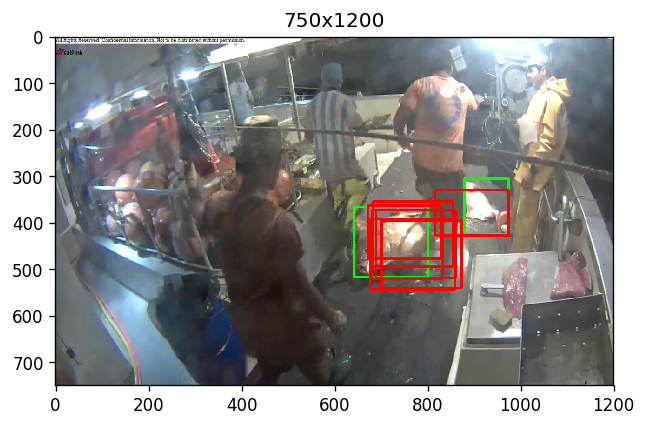

In [41]:
np.set_printoptions(threshold=20)
example = boxes['lag'][20]

_, sample_img = load_img(example['filename'])
pred = model.predict(np.array([sample_img,]))[0]
#print(pred)
#print(type(pred))

decoded = decode_prediction(pred, conf_thr=0.)
decoded = sorted(decoded, key=lambda e: -e['conf'])
#print(decoded)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(example, decoded[:7], (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('{}x{}'.format(*img.shape));

## Агрегация результатов

In [42]:
TEST_PREFIX1 = '../input/the-nature-conservancy-fisheries-monitoring/test_stg1'
TEST_PREFIX2 = '../input/test-stg2/test_stg2/test_stg2'
import zipfile
#with zipfile.ZipFile(TEST_PREFIX,"r") as z:
#    z.extractall(".")

def load_test_images(TEST_PREFIX):
    images = []
    for path in glob(os.path.join(TEST_PREFIX, '*.jpg')):
        images.append(path)
    return images

test_images1 = load_test_images(TEST_PREFIX1)
test_images2 = load_test_images(TEST_PREFIX2)
test_images =  test_images1 + test_images2

lines = [['image', 'ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']]
#lines = ['image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT']
CONF_THRESHOLD = 0.1
for filename in test_images:
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))[0]
    #print(pred)
    #print(type(pred))

    decoded = decode_prediction(pred, conf_thr=CONF_THRESHOLD)
    decoded = sorted(decoded, key=lambda e: -e['conf'])
    #print(decoded)
    L = len(decoded)
    if L:
        alb = sum([x['alb'] for x in decoded]) / L
        bet = sum([x['bet'] for x in decoded]) / L
        dol = sum([x['dol'] for x in decoded]) / L
        lag = sum([x['lag'] for x in decoded]) / L
        shark = sum([x['shark'] for x in decoded]) / L
        yft = sum([x['yft'] for x in decoded]) / L
        other = sum([x['other'] for x in decoded])/ L
        conf = sum([x['conf'] for x in decoded]) / L
        #nof =  (1 - _sigmoid(2*(conf - CONF_THRESHOLD)))
        nof =  1 - conf

        s = alb + bet + dol + lag + shark + yft + other + nof
        #print('s = ', s)
    
        alb, bet, dol, lag, shark, yft, other, nof = alb/s, bet/s, dol/s, lag/s, shark/s, yft/s, other/s, nof/s
        #print('AAA= ', alb, bet, dol, lag, shark, yft, other, nof)
    else:
        alb, bet, dol, lag, shark, yft, other, nof = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0
        
    
    
    v = [filename.split('/')[-1], alb, bet, dol, lag, nof, other, shark, yft]
    lines.append(v)
    print(v)
    
    print(len(decoded))



# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0

['img_01717.jpg', 0.10602947458611436, 0.10037740155789841, 0.12514193589659686, 0.12191729570542739, 0.19678961431896977, 0.12430210252496221, 0.10488339330445785, 0.12055878210557325]
787
['img_02216.jpg', 0.14122001847673785, 0.11561352824857539, 0.10786152261875365, 0.10488218405074377, 0.198221593736347, 0.13002297303350308, 0.1122576754156634, 0.08992050441967582]
838
['img_04562.jpg', 0.10589590713521793, 0.09628414029644966, 0.12684975532331402, 0.12344829949731566, 0.19592334468147768, 0.1263366692341851, 0.10263158600839511, 0.12263029782364483]
842
['img_00764.jpg', 0.10081948186897592, 0.09474664484595151, 0.1263767015235661, 0.12281980515813867, 0.19645622266409804, 0.12689503097278484, 0.10809005060573064, 0.12379606236075433]
810
['img_06368.jpg', 0.12156336863822356, 0.10453595657614348, 0.11712417069097174, 0.11407703224089727, 0.19741179618704513, 0.12805520294691158, 0.10981596925794035, 0.10741650346186674]
797
['img_03238.jpg', 0.09955326879772018, 0.09683819883982

['img_01669.jpg', 0.10879851010790365, 0.09779236750744057, 0.12710582921320454, 0.12227959688267838, 0.19546539895805876, 0.12450228140066986, 0.10195086147436105, 0.12210515445568312]
812
['img_01286.jpg', 0.0909827450715369, 0.08828326694132668, 0.13578123021510694, 0.1304371954823275, 0.19421391482429096, 0.12389446231492927, 0.09896744980225566, 0.13743973534822618]
813
['img_05292.jpg', 0.10576011552537916, 0.10010663993884311, 0.1168882808285713, 0.11587271853393441, 0.19631858096338806, 0.13391729650136644, 0.12059649321178227, 0.11053987449673507]
808
['img_04830.jpg', 0.11150489927174592, 0.10029831646648622, 0.12089149414364489, 0.11892341281012114, 0.19641560314454198, 0.12909605401622515, 0.10804603240622379, 0.11482418774101093]
839
['img_01966.jpg', 0.13736241502851648, 0.10799529335838351, 0.1162414973320372, 0.11103941056974914, 0.1955366768197146, 0.1268160794378149, 0.1026932190514569, 0.10231540840232743]
813
['img_05967.jpg', 0.13183496525617797, 0.1074531293152269

['img_07192.jpg', 0.12656815747980085, 0.11432603007803376, 0.11179596525305696, 0.10915206000301007, 0.19869158714530324, 0.12485320754413987, 0.11477835191975753, 0.09983464057689781]
808
['img_02648.jpg', 0.11946431964633442, 0.10807633980116717, 0.11738940016113329, 0.11370692920176678, 0.19813964697073722, 0.1251208974073422, 0.11107065350053279, 0.10703181331098623]
812
['img_02703.jpg', 0.10594888799792977, 0.09669685102970256, 0.12285793139330993, 0.1203997226464371, 0.19574232711558853, 0.13094682739028551, 0.11009812078985198, 0.11730933163689451]
830
['img_05794.jpg', 0.10570987139656321, 0.09540036083331746, 0.1286039579148578, 0.12321566393408837, 0.195417058428076, 0.12442269707149176, 0.10253462840397314, 0.12469576201763236]
813
['img_05766.jpg', 0.13866251629284526, 0.10941625084389406, 0.11548081308759539, 0.11014676632919686, 0.19592194773529722, 0.12639803506510117, 0.10310238780826356, 0.10087128283780662]
813
['img_00974.jpg', 0.11903283459178002, 0.10255641052289

['img_01681.jpg', 0.12415773225966388, 0.10556353061547011, 0.11408092612544105, 0.11285591271108378, 0.19698601445345496, 0.13288463301251147, 0.11069701598881877, 0.10277423483355604]
848
['img_05568.jpg', 0.12705125025060846, 0.10664144382733061, 0.11576053546539056, 0.11303159534688066, 0.19693970261278693, 0.12955453570870376, 0.10623594253811469, 0.10478499425018417]
851
['img_06946.jpg', 0.10911445039772971, 0.10051551505189367, 0.11605841989955921, 0.11468635953793384, 0.19718704286915142, 0.1336631161097994, 0.11947953949666967, 0.10929555663726304]
807
['img_03471.jpg', 0.1256536968579367, 0.10653511085246913, 0.11925850057182087, 0.11422817498225026, 0.1967525413209396, 0.1253041853702404, 0.10441089101729, 0.10785689902705319]
804
['img_02749.jpg', 0.12931811688724418, 0.10783506198063744, 0.1179644388206634, 0.11262549632260326, 0.19715910734141157, 0.12396808708816917, 0.10481833489348091, 0.10631135666579006]
801
['img_05979.jpg', 0.12436514676538021, 0.1088403478518205,

['img_07137.jpg', 0.1042401597669495, 0.09985039194429514, 0.12551928191810335, 0.12028300079094281, 0.19787679971487018, 0.12302799044474144, 0.10912043774292288, 0.12008193767717475]
772
['img_01618.jpg', 0.10377846224163528, 0.09365185401572818, 0.128975431558384, 0.12412566349488278, 0.19487096525762784, 0.1261129972211264, 0.10259991711664122, 0.12588470909397417]
813
['img_06646.jpg', 0.11050092531691223, 0.10443313796016737, 0.12144489817322049, 0.1175910887434801, 0.19806929997558403, 0.12174694689586335, 0.11100314399854036, 0.11521055893623199]
767
['img_01647.jpg', 0.13200989376799366, 0.10990083118358229, 0.11177259302362152, 0.10952724181360834, 0.19823902925223566, 0.1292853152382375, 0.11131722231297873, 0.09794787340774241]
846
['img_05682.jpg', 0.10117394162047381, 0.0965111854863142, 0.12197265158630755, 0.11944505438266224, 0.19643102341106428, 0.1295311833444958, 0.11654937603292814, 0.11838558413575398]
798
['img_07050.jpg', 0.1225878988093755, 0.1030530882204012, 

['img_05322.jpg', 0.07553083445602382, 0.07899610847955174, 0.14488540673913305, 0.13855309654981118, 0.19421291816378286, 0.12057963382608573, 0.09460733101199205, 0.1526346707736196]
834
['img_00518.jpg', 0.10732206175891762, 0.09857371879443781, 0.12277854675947461, 0.12053896662688819, 0.1963953377012968, 0.12842143484303714, 0.10809934494853124, 0.11787058856741653]
840
['img_05539.jpg', 0.13169341117480715, 0.10748451760506564, 0.11850684483616591, 0.11255810468045059, 0.19752326760922545, 0.12193265261324276, 0.10317606327650813, 0.10712513820453444]
795
['img_07318.jpg', 0.10144194381855981, 0.09600055712007759, 0.12982586755653547, 0.1239666220723465, 0.19637527548393205, 0.1218284449042817, 0.10354343718937903, 0.12701785185488776]
822
['img_04432.jpg', 0.10441074337478753, 0.10012404548908257, 0.12535709980246088, 0.12225749615777816, 0.19606323294114444, 0.12493427421926145, 0.10587943163638101, 0.12097367637910383]
758
['img_05489.jpg', 0.1272501320714896, 0.10800699314579

['img_02309.jpg', 0.10206813538086516, 0.098883851127623, 0.125540243568837, 0.12284351429539346, 0.19570738247617608, 0.12636707518451754, 0.10664470682635072, 0.12194509114023713]
768
['img_07062.jpg', 0.11507685214638269, 0.10539847194191838, 0.11816309212660184, 0.11616461127068688, 0.1974723274746355, 0.128188057245067, 0.10905557904771959, 0.11048100874698799]
808
['img_07818.jpg', 0.10447491874134772, 0.09999208665898862, 0.1252068533892491, 0.12213752070785283, 0.19592448915829885, 0.1250529779989657, 0.10629278186936378, 0.12091837147593335]
761
['img_03554.jpg', 0.10404457488715652, 0.10009587380272524, 0.12556938785072924, 0.12217558251633595, 0.19628784453359913, 0.12439672464649483, 0.10605486168853528, 0.12137515007442394]
769
['img_05775.jpg', 0.11100134032025598, 0.09793764847296399, 0.1253551042847643, 0.12058520560697261, 0.19510320292107325, 0.1264760419214722, 0.10421150802890977, 0.11932994844358798]
808
['img_07146.jpg', 0.11098648501907318, 0.09890182571827266, 0

['img_07528.jpg', 0.10247346174278212, 0.09455537692795123, 0.12555772798626053, 0.122666693689891, 0.19572468234177692, 0.12938768225932512, 0.10699938224264323, 0.12263499280936992]
830
['img_03074.jpg', 0.11569921627412737, 0.0991201555977996, 0.12541386973240048, 0.11987298025682387, 0.19527866669076963, 0.12484072246061202, 0.10148033281849822, 0.11829405616896876]
814
['img_02406.jpg', 0.13415662647870966, 0.10838184597148684, 0.11746672468888202, 0.11155552720953228, 0.19735047768351197, 0.12234920232532495, 0.1035319308945197, 0.10520766474803259]
793
['img_07120.jpg', 0.1039927486264505, 0.09698163226734215, 0.12199495372676497, 0.12018719366317962, 0.19510098406871032, 0.13253858184703532, 0.11248687901685878, 0.11671702678365832]
830
['img_07371.jpg', 0.10851750014396623, 0.1019198262407744, 0.12326404317913899, 0.11910676628565212, 0.19690677213046617, 0.12466815017698286, 0.10885623854432858, 0.11676070329869065]
830
['img_06273.jpg', 0.12666698939253873, 0.102871215568993

['img_01984.jpg', 0.1254026719419825, 0.10477121154947064, 0.11980524649305661, 0.11507167305136001, 0.19558842331462034, 0.12750136713049454, 0.10340332457945964, 0.10845608193955567]
806
['img_07122.jpg', 0.10747074796718566, 0.0957850538939501, 0.12791219081804567, 0.12283833203696887, 0.19525000286796104, 0.12520845171188344, 0.10188220258975386, 0.12365301811425138]
808
['img_00858.jpg', 0.08527755255934633, 0.09160176616212996, 0.13132414540257947, 0.12797627003607157, 0.1945123842314592, 0.12980211743526124, 0.10824747671613347, 0.1312582874570189]
846
['img_06285.jpg', 0.12284124837429806, 0.1019034647464654, 0.11730433585991605, 0.11502307170556661, 0.19590671796146655, 0.13138232144683687, 0.10787915936194437, 0.10775968054350621]
826
['img_04750.jpg', 0.10006468774562448, 0.0969667566422283, 0.12878023956099396, 0.12407862226499682, 0.19703921257294074, 0.12053199082675008, 0.10595713401235042, 0.12658135637411533]
758
['img_03283.jpg', 0.11947958471595949, 0.102308699877844

['img_05471.jpg', 0.1038084147034479, 0.09802575122756729, 0.12019043621334685, 0.1180058029407614, 0.19647659091001934, 0.13136930290239046, 0.11691548092520589, 0.11520822017726076]
806
['img_00285.jpg', 0.10628009332432271, 0.10019177681289398, 0.1172011338087979, 0.11619597916910147, 0.1963985581893753, 0.13265623724283365, 0.11991353784935851, 0.11116268360331646]
807
['img_05721.jpg', 0.1198105951021306, 0.10710460326403004, 0.11891639196444129, 0.11435767255975852, 0.19809473869423008, 0.12337977841303868, 0.10938362385805572, 0.10895259614431514]
814
['img_01204.jpg', 0.08217923795273908, 0.09015193975405789, 0.1271992199106957, 0.1270403546711159, 0.1951959876924451, 0.13303964578884894, 0.1164099518534127, 0.12878366237668473]
768
['img_00289.jpg', 0.1197496771872352, 0.10887453214957304, 0.11591897956119805, 0.1120050379050818, 0.1981907652065899, 0.12775076245811043, 0.11338144572943851, 0.1041287998027731]
785
['img_03670.jpg', 0.10880860246684292, 0.09881575167313383, 0.1

['img_04425.jpg', 0.1273933468830617, 0.10598972806585864, 0.1196012323060129, 0.11468674389200167, 0.19609423617574595, 0.12658550631360424, 0.10180473547873448, 0.10784447088498043]
805
['img_00152.jpg', 0.08803421099018495, 0.09035161480248996, 0.13266532398613884, 0.1283649251562324, 0.19489168699625217, 0.12578241265294754, 0.10610675398022523, 0.13380307143552894]
840
['img_00950.jpg', 0.12962274278266453, 0.11050657257415837, 0.10966072711946279, 0.10871109141178562, 0.1975873869823855, 0.12909629417066756, 0.11760476251395346, 0.09721042244492213]
795
['img_05393.jpg', 0.11205060974589263, 0.10805570849982611, 0.1170798488586305, 0.11490901755179762, 0.19734320130847874, 0.12768021684918185, 0.1147087760076263, 0.1081726211785661]
818
['img_02602.jpg', 0.10573402292285966, 0.09640134322640387, 0.12760881045210312, 0.12240435374389731, 0.19507750909341312, 0.12536322643789363, 0.10437043386506602, 0.12304030025836317]
813
['img_02687.jpg', 0.11643766481455523, 0.1029486099009977

['img_07436.jpg', 0.1050584227710265, 0.10207268370873515, 0.11647996875225408, 0.11622727648819048, 0.19749892056254467, 0.13288357535098952, 0.11948819896438173, 0.11029095340187792]
802
['img_00876.jpg', 0.09877003455381121, 0.10032484686989891, 0.11506518434261553, 0.11696806011229385, 0.19685753850011284, 0.13801779559648505, 0.12462297550511377, 0.10937356451966897]
783
['img_07157.jpg', 0.13126689350797235, 0.10876706659234153, 0.11834219115755872, 0.11221784803811419, 0.1973359637762972, 0.12173851940033069, 0.10401003040280217, 0.10632148712458327]
799
['img_04118.jpg', 0.12953530762252716, 0.10703194573816459, 0.11638461939630719, 0.11211415594384054, 0.19628582010987614, 0.12764454037473125, 0.10665910970619759, 0.10434450110835547]
811
['img_05719.jpg', 0.12461549751361096, 0.10937461812521115, 0.11456986446899599, 0.11158457152917617, 0.1970017101785651, 0.1275630733145136, 0.11224735734028851, 0.10304330752963851]
816
['img_02920.jpg', 0.11863565030210563, 0.0986290159794

['img_05572.jpg', 0.11216990935390003, 0.10325901543745447, 0.11514976037516308, 0.11414088544877628, 0.19690392405733662, 0.1319448314920745, 0.11895285824255707, 0.10747881559273816]
812
['img_03261.jpg', 0.13112063103318, 0.10823173679736094, 0.11954458402497285, 0.11327038266972653, 0.1966676230407607, 0.12068885384990184, 0.10234720954744113, 0.10812897903665597]
772
['img_02638.jpg', 0.13386953034471566, 0.10910866442406489, 0.11503777445546245, 0.11034239278243016, 0.19649192367019633, 0.12665326882822106, 0.10700495038762775, 0.10149149510728184]
811
['img_00171.jpg', 0.13227142429803979, 0.10735653856805072, 0.11835712782856324, 0.1123964887738971, 0.19761458196861476, 0.12232946302852862, 0.1028435331122686, 0.10683084242203725]
795
['img_03750.jpg', 0.1055932888413223, 0.10070733309404901, 0.11740069008659115, 0.11631487275058795, 0.1970567794358848, 0.13261061648376365, 0.11881046995167614, 0.1115059493561249]
807
['img_02904.jpg', 0.12332887296406142, 0.10446669560395799, 

['img_05718.jpg', 0.10514154878463934, 0.10394440312649512, 0.11295846421696581, 0.11403030804795027, 0.19583298942652502, 0.13780631047939101, 0.1239531565306148, 0.10633281938741847]
812
['img_03891.jpg', 0.13108900635872336, 0.10889412648177167, 0.11794204156719021, 0.11293835876654208, 0.19577787702357868, 0.1237331628917795, 0.10381309856517242, 0.10581232834524198]
799
['img_02789.jpg', 0.09998455141871614, 0.09152440286262072, 0.12956086873313083, 0.12577980407547812, 0.1955218310689812, 0.12686527103433454, 0.10291270390929182, 0.1278505668974466]
844
['img_00103.jpg', 0.12172601707412836, 0.10405473664158132, 0.12094964752355548, 0.11574258016326258, 0.19612631192483498, 0.125647229191073, 0.10495516459508811, 0.11079831288647629]
810
['img_06921.jpg', 0.11169192987466316, 0.10502224256777315, 0.11965487456571762, 0.11544546415589281, 0.19768335315188962, 0.12788257204734832, 0.11269553538049207, 0.10992402825622338]
799
['img_07188.jpg', 0.13646944078775902, 0.111311812006385

['img_02077.jpg', 0.13542748699519594, 0.10837564492131764, 0.11743585688618027, 0.11131127836055285, 0.19710010523587385, 0.12267054928190756, 0.10283861281422756, 0.10484046550474438]
786
['img_01530.jpg', 0.14436212127349712, 0.12112069060697049, 0.10619894832791814, 0.10237893184733944, 0.20027473935528087, 0.12150575359425869, 0.11523213191614473, 0.08892668307859032]
803
['img_02563.jpg', 0.1261370053830874, 0.10978784077796784, 0.11292413222209254, 0.11191470441198662, 0.19824691303169945, 0.1287149415246404, 0.1100567072720609, 0.10221775537646484]
812
['img_04795.jpg', 0.1053090803383682, 0.10181682768262502, 0.11653359798290114, 0.1159107419746499, 0.19742171633886163, 0.13312574288340415, 0.11969631955763163, 0.11018597324155831]
805
['img_02641.jpg', 0.12477640894669409, 0.10362655324795825, 0.12192325879675815, 0.11582296017390825, 0.19681650863743064, 0.12267216513218172, 0.10181038049505792, 0.11255176457001105]
809
['img_03252.jpg', 0.11707514386991551, 0.10398852182278

['img_00724.jpg', 0.11195707953746487, 0.09828932122639684, 0.12396242053036077, 0.12006608876816137, 0.19615324126843114, 0.1271538718800659, 0.10463184782599301, 0.11778612896312621]
846
['img_07149.jpg', 0.07473861925662131, 0.07996755002997107, 0.14451213411057504, 0.13853662869069935, 0.19458057272027335, 0.1201825328464886, 0.09514767998824483, 0.15233428235712654]
828
['img_05463.jpg', 0.10527609914120216, 0.09989068985545688, 0.11702337253356199, 0.11596679309974857, 0.1964411807624445, 0.13405038206989117, 0.12062654119894263, 0.11072494133875206]
808
['img_06424.jpg', 0.10701911170602152, 0.09785716302236863, 0.12268832761645913, 0.1205962872712585, 0.19643203339394477, 0.1289358324508553, 0.1084643074538148, 0.11800693708527743]
839
['img_00865.jpg', 0.12114045464502904, 0.10050651051558264, 0.1234110616231384, 0.11720478261675027, 0.19597450284704157, 0.12508911792683958, 0.10188717972312744, 0.11478639010249118]
807
['img_03805.jpg', 0.12331934033577446, 0.1042534325931206

['img_04004.jpg', 0.12469001724107555, 0.10527546851086743, 0.12047425734808292, 0.11460719990273867, 0.1975218169825657, 0.12202594585657389, 0.10484742947411753, 0.11055786468397841]
792
['img_05580.jpg', 0.11001199656516698, 0.10180579066291191, 0.11553090819756556, 0.11446276683615815, 0.19699356801039491, 0.13262704267999517, 0.12009054706941313, 0.10847737997839425]
810
['img_00533.jpg', 0.09764369011946497, 0.0958774865084424, 0.12289600555998108, 0.121091172367347, 0.196111389637505, 0.13059996063523827, 0.1153994407060374, 0.12038085446598368]
799
['img_05378.jpg', 0.11528431055061586, 0.098139716015795, 0.12416613939701256, 0.119263727386596, 0.1970526429792132, 0.12410816673718063, 0.10375622497216574, 0.1182290719614209]
806
['img_05817.jpg', 0.10458339628036996, 0.09834117111871228, 0.11971451991203153, 0.11757591101121995, 0.196472243534746, 0.13161362947498328, 0.1172254266754888, 0.11447370199244825]
807
['img_01782.jpg', 0.10670818230656337, 0.09895031717161638, 0.1235

['img_00550.jpg', 0.12255711894186187, 0.103803513939009, 0.11716649934759069, 0.11390373681773297, 0.19734219305252512, 0.12805200515437487, 0.10975409324291141, 0.10742083950399402]
795
['img_05268.jpg', 0.10410674509864326, 0.09978017787153509, 0.1201712476136854, 0.11786337021198308, 0.19635608480958178, 0.13122710662114745, 0.11610783443820401, 0.11438743333521988]
805
['img_02834.jpg', 0.113458278044704, 0.10435008587096986, 0.1146205145415285, 0.11328115168114695, 0.19700215020793868, 0.13180410002939444, 0.11872376086838995, 0.1067599587559276]
808
['img_06099.jpg', 0.11553820932164784, 0.10629834136565745, 0.12039647801112642, 0.11630737106222416, 0.19852501194059338, 0.12045728171127737, 0.10957046339139999, 0.1129068431960733]
748
['img_06564.jpg', 0.1241944073852872, 0.10092368171925535, 0.12158679224775375, 0.11633898403023012, 0.19581582597502198, 0.12541712005320893, 0.10316091846289287, 0.11256227012634988]
814
['img_00180.jpg', 0.1011579959057928, 0.0959487296929265, 0

['img_04138.jpg', 0.10973212785224891, 0.09582781866064354, 0.12805080607599312, 0.12259858316777837, 0.1954113225848279, 0.12481592529636956, 0.10023516760508763, 0.1233282487570509]
806
['img_05740.jpg', 0.10875690682058213, 0.09588012644793481, 0.127313831862793, 0.12139863069646187, 0.19697374840507528, 0.12249503922929031, 0.10406451467511227, 0.12311720186275034]
793
['img_06985.jpg', 0.12507369317700875, 0.10617613078276303, 0.12052090906445646, 0.11454183487439322, 0.19768271522550873, 0.12141090134276686, 0.10418193735256484, 0.11041187818053821]
763
['img_05672.jpg', 0.09864559458118999, 0.10380376168883729, 0.11735293219133285, 0.11798676938153818, 0.1957879333695213, 0.13454875276184575, 0.11957359793003323, 0.11230065809570139]
814
['img_06959.jpg', 0.08997995421552028, 0.08580384233364728, 0.138090317327275, 0.1317982591954739, 0.19412673201456968, 0.12251901283734139, 0.09738596911261872, 0.14029591296355376]
813
['img_03444.jpg', 0.11306005243604046, 0.10625319517833846

['img_00138.jpg', 0.1255105973636249, 0.1067479438964432, 0.1197571322934285, 0.11442358276761573, 0.1971070388621793, 0.12215689520696653, 0.10496557339019262, 0.1093312362195492]
795
['img_02702.jpg', 0.11074998086238241, 0.10161332388204151, 0.12335032737719519, 0.11925698421447195, 0.19803875324397097, 0.12122998733752158, 0.10773237267786841, 0.118028270404548]
791
['img_07628.jpg', 0.10848951337480546, 0.10381050715310988, 0.11056733794039011, 0.11318099565847622, 0.19634834415274144, 0.13771810618926725, 0.1269685583896574, 0.1029166371415523]
784
['img_04061.jpg', 0.10083787835694644, 0.09723059892345504, 0.12282399911623332, 0.12043034923630593, 0.19544336194658182, 0.1300801053954821, 0.11367546740567279, 0.11947823961932258]
809
['img_07173.jpg', 0.12482624235894449, 0.10587783611666121, 0.11523359922241598, 0.1131867534784507, 0.19699944456913085, 0.13118308438602652, 0.10861320165090554, 0.10407983821746472]
842
['img_05879.jpg', 0.11129085267802384, 0.09791790640656854, 0

['img_07084.jpg', 0.1422341129944493, 0.1172518720031779, 0.10589504237104391, 0.10562267511303883, 0.19841010983134016, 0.13254554718109318, 0.1101653860453267, 0.08787525446053002]
816
['img_05587.jpg', 0.1278127977410716, 0.10334431574377677, 0.12117028708295288, 0.11530485879152809, 0.19632653550594123, 0.1239052450444268, 0.10073473557854251, 0.11140122451176016]
800
['img_07147.jpg', 0.09974729025826527, 0.10209397095516429, 0.11648927149785866, 0.11855630012594638, 0.19773610406578768, 0.13454886151520834, 0.11994987053985307, 0.11087833104191637]
792
['img_02811.jpg', 0.1309999618750466, 0.10747179068279238, 0.11802727279023181, 0.11221869266781033, 0.19731377817645, 0.12347502570122967, 0.1041818375003491, 0.10631164060609023]
801
['img_01685.jpg', 0.12425064213174458, 0.1060432195830779, 0.11589338447216194, 0.11289933816347653, 0.19792815119084248, 0.127686843100233, 0.10966776232670619, 0.10563065903175715]
798
['img_06851.jpg', 0.10484794014372915, 0.10274696750098022, 0.1

['img_05264.jpg', 0.1354117998400257, 0.11485646382600734, 0.10957435143755265, 0.10661905151851729, 0.19815762458991498, 0.12764607710396889, 0.1137616674911677, 0.09397296419284552]
812
['img_04657.jpg', 0.13287382086028757, 0.1117744505570304, 0.11496551460064522, 0.11039316109205545, 0.19732872391492656, 0.12455844031300504, 0.10626771718903136, 0.1018381714730184]
804
['img_05896.jpg', 0.12368952041920189, 0.10116868708546352, 0.121573556870854, 0.11628440186857066, 0.19598625608032344, 0.12539834904843575, 0.10349497658512237, 0.11240425204202838]
813
['img_00564.jpg', 0.11838401829081167, 0.10496513853972618, 0.1164637425527707, 0.11507437350418281, 0.19746637858440513, 0.13085494852564578, 0.1094883831125718, 0.10730301688988599]
810
['img_01561.jpg', 0.1381931329907112, 0.11475362733846946, 0.10693147756126167, 0.10626263586488555, 0.19844446544735628, 0.13065546070453074, 0.11300791775510113, 0.09175128233768405]
805
['img_04520.jpg', 0.11305928211012391, 0.09612390082989271,

['img_06189.jpg', 0.1141581004059993, 0.10010286971601574, 0.12386201591320513, 0.11867142461675176, 0.19540420947795598, 0.12622753302137307, 0.10513631407907201, 0.11643753276962698]
813
['img_06783.jpg', 0.10201849191595093, 0.09729534124520663, 0.1201992094956423, 0.1182662564003324, 0.19612427708829178, 0.1323994196202989, 0.11810946861580576, 0.11558753561847136]
800
['img_05492.jpg', 0.12671085211633076, 0.11160879152327781, 0.11334857998766237, 0.11023316732532125, 0.1981102798567655, 0.12607827458651807, 0.11287877824942992, 0.1010312763546942]
814
['img_05293.jpg', 0.107775624432472, 0.10428866525668147, 0.11293306855517615, 0.11370350612241864, 0.19578684405464974, 0.13780116169118364, 0.12196340550154953, 0.10574772438586875]
798
['img_04879.jpg', 0.10612189304936286, 0.10776166006689389, 0.11296205898991875, 0.11394035917591437, 0.19665649223173562, 0.13562050471930562, 0.12200583282329285, 0.10493119894357611]
810
['img_07304.jpg', 0.1280395611793524, 0.10931925434533761,

['image_06699.jpg', 0.12021442714626468, 0.1048343730687493, 0.1183360236967367, 0.11607047799942935, 0.19713360618902923, 0.12785061330281108, 0.10564363373972963, 0.1099168448572501]
844
['image_08058.jpg', 0.12373745178427341, 0.10732761886143574, 0.11765957355149995, 0.11414971325008275, 0.1965026146672754, 0.12721619544711554, 0.10621367586056701, 0.10719315657775026]
835
['image_10727.jpg', 0.09784421854057912, 0.10119168794673426, 0.12003144187053066, 0.12085412442591431, 0.19632343566921864, 0.13289552271610805, 0.11436259988955667, 0.11649696894135834]
843
['image_01117.jpg', 0.07956165820870846, 0.08543444122313401, 0.13443755991507308, 0.1311535567897805, 0.19507974391114632, 0.1266258031063724, 0.10869136376947552, 0.13901587307630975]
844
['image_08883.jpg', 0.09441176118933367, 0.09503968508183734, 0.12415454468023629, 0.12279683017066656, 0.1960619310650033, 0.13068094562129484, 0.11403900018921101, 0.12281530200241693]
844
['image_08603.jpg', 0.1333607526656441, 0.11303

['image_11841.jpg', 0.1159380894333499, 0.10146051899184202, 0.12208767636263464, 0.11833870633590084, 0.1969009408049087, 0.1247631263831601, 0.10476023351965615, 0.11575070816854778]
823
['image_12041.jpg', 0.1265375684028173, 0.10753037908133468, 0.11606316854282789, 0.11325806704562694, 0.1981457526947252, 0.12625074184775117, 0.10676774014263325, 0.10544658224228357]
833
['image_03332.jpg', 0.09948846413797952, 0.09679682461533667, 0.12369796577206119, 0.12236183084533683, 0.1959616431921365, 0.1308494205722893, 0.11006636489394116, 0.12077748597091889]
845
['image_01554.jpg', 0.12371922417773487, 0.10554181330316366, 0.11664962375910598, 0.11407487186719444, 0.1972631345436996, 0.12824065466156925, 0.10718600065560016, 0.10732467703193202]
833
['image_03746.jpg', 0.10084050266050461, 0.09217217347702815, 0.13066696072786907, 0.12553968477067473, 0.1956934776731375, 0.12484632309127847, 0.10144486237027059, 0.12879601522923684]
846
['image_03279.jpg', 0.1279958325512749, 0.1077154

['image_11088.jpg', 0.12244981942614228, 0.10409170572772494, 0.11748513571830692, 0.11468628262638601, 0.19658223082766815, 0.1275037262687982, 0.10774730963619296, 0.10945378976878042]
840
['image_07095.jpg', 0.11090252714042985, 0.10049617256924841, 0.12594570589667226, 0.12131270106332069, 0.1953999528735771, 0.1252122982659882, 0.10094617974748726, 0.11978446244327617]
841
['image_09916.jpg', 0.08984799471085765, 0.09283495228401929, 0.12679303576987117, 0.12518823389605926, 0.19573599246882878, 0.1298604476677846, 0.11262911238876276, 0.1271102308138164]
842
['image_11545.jpg', 0.12379591766116507, 0.10616820914121983, 0.11821153017712303, 0.11491293868077997, 0.197930000312046, 0.12533208817963967, 0.10477670943990239, 0.10887260640812398]
825
['image_06046.jpg', 0.07879224424444574, 0.08295143975892129, 0.13867189766435145, 0.1348669813907302, 0.19397320595780543, 0.1273356576197818, 0.0999466873553135, 0.14346188600865067]
844
['image_11782.jpg', 0.07970281101163729, 0.0858772

['image_04855.jpg', 0.10664667889540203, 0.0969194582013647, 0.12478776437314593, 0.12082389979286907, 0.19651894783625343, 0.12748281046330112, 0.10746728893730204, 0.11935315150036159]
834
['image_03801.jpg', 0.07948728875011012, 0.08450744227769344, 0.1356025648993909, 0.13168499534608444, 0.19493789038188444, 0.12622749111284964, 0.10731763336569276, 0.14023469386629436]
840
['image_01497.jpg', 0.14437564822415067, 0.1168050545291205, 0.10485932882663454, 0.10333634550400576, 0.1989178597243338, 0.12917760863119673, 0.11412659019705891, 0.08840156436349914]
832
['image_00082.jpg', 0.08848459760579047, 0.09254133288542564, 0.1252477793228561, 0.12462398524134533, 0.195423070929625, 0.13109806236950283, 0.11643801752957025, 0.12614315411588445]
846
['image_10013.jpg', 0.1367121755354871, 0.11131872486231323, 0.11202670471839718, 0.10844711097405273, 0.1985295857123548, 0.12619264005324482, 0.10804034084753428, 0.09873271729661587]
832
['image_05558.jpg', 0.11738284930399887, 0.103577

['image_11728.jpg', 0.11198395827959964, 0.10050018645628254, 0.12423227307427305, 0.12046861529661809, 0.1951202451764699, 0.12767855038446535, 0.10216501886670339, 0.11785115246558787]
845
['image_10643.jpg', 0.07853999838267081, 0.08489809222184873, 0.13514833434532775, 0.1331102397806497, 0.19378132157119587, 0.1304104841776924, 0.10480524346424597, 0.1393062860563688]
844
['image_09007.jpg', 0.10661804390824632, 0.10071529590940677, 0.1201945425960373, 0.11873167967075157, 0.1959408924394398, 0.13021122917514, 0.11228362758839681, 0.1153046887125814]
800
['image_02885.jpg', 0.12292844940611179, 0.10730810583537147, 0.11597443629169346, 0.11431573670250791, 0.19793211324615598, 0.12763188980845244, 0.10823671236531683, 0.10567255634439021]
835
['image_11205.jpg', 0.08299236468668725, 0.08873963633300325, 0.12909501438398835, 0.12793260067776016, 0.19501027603387733, 0.13066379426620778, 0.11387185355800064, 0.13169446006047522]
842
['image_03147.jpg', 0.1443006996914166, 0.11764913

['image_08068.jpg', 0.11092994543703509, 0.0988612973077378, 0.12365105329054533, 0.12010861398555144, 0.1963269726499281, 0.12564665392317315, 0.10554216507615097, 0.118933298329878]
829
['image_00725.jpg', 0.07850114988635723, 0.0837796614636535, 0.136160930628198, 0.13240073377148523, 0.19451123872918846, 0.12634398354600065, 0.10690215600520066, 0.14140014596991632]
844
['image_08271.jpg', 0.0934739007606695, 0.09494436068465692, 0.1258854661066193, 0.12513906639953296, 0.19515759354382478, 0.1317885916062954, 0.10900375567966868, 0.1246072652187324]
851
['image_07145.jpg', 0.11177972924416235, 0.09840417729453438, 0.12345254478359981, 0.1201208875932625, 0.19599571032375637, 0.12733689315622976, 0.10459654935013324, 0.11831350825432159]
848
['image_11687.jpg', 0.10078925389709793, 0.1006574391286468, 0.1184873349766456, 0.11877252954255045, 0.19656727622074538, 0.13275697054502483, 0.11770533300748912, 0.11426386268179974]
839
['image_05137.jpg', 0.0760393028085181, 0.083021261773

['image_05666.jpg', 0.08237711952467443, 0.0866793410160846, 0.13331082484565165, 0.1300943736613043, 0.19535548186369422, 0.12715128074428292, 0.1082782787936364, 0.13675329955067156]
847
['image_03125.jpg', 0.09654582630692438, 0.09326806710681217, 0.1274847334929572, 0.12487247953540918, 0.1951419863744022, 0.12872772229603371, 0.10746797698976342, 0.1264912078976977]
848
['image_09963.jpg', 0.08028339503104497, 0.08415312114819895, 0.13586775954453933, 0.13178714558255392, 0.19497526050540284, 0.12600428778330489, 0.10603460111963135, 0.1408944292853237]
845
['image_05561.jpg', 0.13472110393317893, 0.11050327626193929, 0.11066643441885185, 0.10898922352773847, 0.19730239955676088, 0.12960751905514972, 0.11026519826981802, 0.0979448449765629]
834
['image_11136.jpg', 0.11046959938192615, 0.09895190131448464, 0.12445671456577599, 0.12063301905511532, 0.19661288765803847, 0.12490150246835414, 0.10395580615198204, 0.12001856940432319]
828
['image_02638.jpg', 0.09213900004070862, 0.09396

['image_05078.jpg', 0.12514442329355344, 0.1052904912727711, 0.11478228948426249, 0.11186776833169651, 0.1970130862445048, 0.12785170023650216, 0.11270643980218024, 0.10534380133452917]
834
['image_01734.jpg', 0.1016602805463485, 0.0994015486173238, 0.12210433469344431, 0.12108535165749218, 0.19572479342776, 0.13060319524511574, 0.1109376370069011, 0.11848285880561447]
842
['image_09876.jpg', 0.07518206722844306, 0.082775573493341, 0.1378291098441887, 0.13386963723891288, 0.19472463703989165, 0.1252078737021242, 0.10591355437610649, 0.1444975470769919]
843
['image_07674.jpg', 0.13426576508949367, 0.11322410434281427, 0.10840183367809157, 0.10792437786977277, 0.1987589487933591, 0.13008994965237097, 0.11292412033099196, 0.09441090024310572]
824
['image_07714.jpg', 0.0861087741399722, 0.08999033829679168, 0.12953354631945024, 0.1276686059194235, 0.19535933620245974, 0.1294581112162124, 0.11047264340676269, 0.13140864449892745]
847
['image_09304.jpg', 0.12023755619092255, 0.10378525292254

['image_05281.jpg', 0.09825746336525608, 0.09568686037343764, 0.12471928180807655, 0.12291154046448466, 0.19569764271993287, 0.1299130142100542, 0.11015015158032923, 0.12266404547842887]
842
['image_06274.jpg', 0.13343932738259878, 0.10933627004020616, 0.11282142044636086, 0.10930928203389015, 0.19761998590131574, 0.12830989634970782, 0.10931125716853074, 0.09985256067738964]
843
['image_04952.jpg', 0.07729495174809395, 0.08357013836498078, 0.13667900319655674, 0.13299760160466678, 0.19484963831335042, 0.1255016955763795, 0.10648174276792141, 0.1426252284280504]
842
['image_06987.jpg', 0.10545128094075747, 0.10204549301268435, 0.11839947451061979, 0.11881137489649254, 0.19648290130890034, 0.132890407901033, 0.11298412850702046, 0.11293493892249191]
849
['image_00091.jpg', 0.1387012708654487, 0.11500330980820926, 0.1101899341050124, 0.10651424721839313, 0.19881015021024218, 0.12592206556384086, 0.1096598691506224, 0.09519915307823118]
818
['image_11403.jpg', 0.07739590972580036, 0.08315

['image_09698.jpg', 0.12075065673876416, 0.10522541416916766, 0.11766688754197827, 0.11408387897558611, 0.19679333721788506, 0.1270780714817445, 0.10950261090887783, 0.10889914296599645]
840
['image_09037.jpg', 0.13358615624202191, 0.10937764550641411, 0.111887292238597, 0.10965369636937593, 0.19794154630785796, 0.1285640498446801, 0.10933991205373232, 0.09964970143732062]
839
['image_00466.jpg', 0.13414149077272583, 0.11028121829256482, 0.11264438137405028, 0.10898311976468081, 0.19773004574790268, 0.1273859913830969, 0.10896875130085215, 0.0998650013641264]
844
['image_02226.jpg', 0.09135283013385477, 0.09361579508207182, 0.12605074414326659, 0.12446393228043982, 0.1958837389638435, 0.1299098286403763, 0.11287456617142688, 0.12584856458472035]
844
['image_11193.jpg', 0.08017804906374972, 0.08488837616367673, 0.13466228074718883, 0.13114206454882849, 0.19493448844911634, 0.12688865694162904, 0.10796089352707319, 0.13934519055873756]
844
['image_06287.jpg', 0.11137359232415331, 0.10073

['image_10323.jpg', 0.09827201325157311, 0.09764292873001286, 0.12287541571680072, 0.12223516895647175, 0.19602230933410897, 0.13120820387912535, 0.11176219324218804, 0.11998176688971919]
845
['image_09993.jpg', 0.09647042231127448, 0.09320770861660492, 0.12723091319470456, 0.1244741766706704, 0.196138542422712, 0.12776745555029984, 0.1078183501901338, 0.12689243104359998]
839
['image_04562.jpg', 0.08411341755606397, 0.08868784239772942, 0.12945200502093387, 0.12797072421981712, 0.19494020092616762, 0.13112877655638214, 0.11205443763309782, 0.13165259568980806]
844
['image_05108.jpg', 0.08841302237187602, 0.09069366126520735, 0.12861725352686484, 0.12668685537575725, 0.19536822616658775, 0.12940546263121255, 0.11086476728365842, 0.129950751378836]
842
['image_11641.jpg', 0.09735281670462935, 0.09635116994804968, 0.12455527606925959, 0.12312186724993032, 0.19556514280788498, 0.12961492189119642, 0.11076216004245973, 0.12267664528658985]
836
['image_03925.jpg', 0.07919210592326181, 0.084

['image_10750.jpg', 0.11729654389063561, 0.10276931113766584, 0.11936223531896863, 0.11711649834561574, 0.19662022971020438, 0.12883047328429975, 0.10622498895273504, 0.11177971935987492]
847
['image_02663.jpg', 0.11381736745916682, 0.10381081544408956, 0.11893676193183526, 0.11775732178783306, 0.1965333926566693, 0.12947724269062627, 0.10753614428087042, 0.11213095374890923]
848
['image_09913.jpg', 0.1278581745243026, 0.10821171813111824, 0.1144054782223253, 0.11101303396406953, 0.19752369654052798, 0.1273951809813597, 0.11015431893420152, 0.10343839870209526]
841
['image_07192.jpg', 0.08724945797914795, 0.08937901188959878, 0.12924205262418798, 0.12718113929455674, 0.19512577663962574, 0.13024259744437106, 0.11048463054248056, 0.13109533358603112]
844
['image_03031.jpg', 0.1146623166611296, 0.10341397324723035, 0.11750298215341251, 0.11509792491024431, 0.19709374486199524, 0.12993692292161121, 0.11287725191481238, 0.10941488332956437]
842
['image_03659.jpg', 0.09677814102685986, 0.09

['image_08405.jpg', 0.10779469805291679, 0.10041789977084352, 0.12051249299693825, 0.11904074008509377, 0.196483587495931, 0.13121969846404863, 0.10987192592804276, 0.11465895720618532]
850
['image_12023.jpg', 0.09990830574898467, 0.09750096401939096, 0.12299976359290779, 0.12186279643043633, 0.19613381713326963, 0.13047018668896612, 0.11125314014706883, 0.11987102623897561]
844
['image_01782.jpg', 0.09282518762236076, 0.08719062872890793, 0.13425838021395628, 0.12917109389943116, 0.1947588528107273, 0.12603260864728752, 0.09999795231743783, 0.13576529575989127]
835
['image_00183.jpg', 0.08095559973222037, 0.08519600062957827, 0.13483781868535313, 0.13123675994781125, 0.19476485118192235, 0.12669908193021936, 0.10719329935859082, 0.13911658853430436]
842
['image_04768.jpg', 0.11765408881023755, 0.10402587563094781, 0.11805994363506436, 0.11634995140154271, 0.1967952294444983, 0.1289821904673878, 0.10748034996290765, 0.1106523706474139]
840
['image_01367.jpg', 0.11492226034202095, 0.101

['image_00462.jpg', 0.11798980222860697, 0.10486019130217983, 0.11670673016266578, 0.11386159981267223, 0.19730253670009318, 0.1277008280571172, 0.11299592340218395, 0.10858238833448092]
837
['image_00257.jpg', 0.08364185686186193, 0.08685960429016208, 0.13178840167416853, 0.1291343679801002, 0.19471888748555996, 0.12889781296549335, 0.10997713971406864, 0.13498192902858522]
847
['image_04901.jpg', 0.08559560198820325, 0.0895897598957106, 0.12991669643527434, 0.12765192071469894, 0.19537248663114903, 0.129412133302751, 0.11048410148286485, 0.13197729954934792]
834
['image_01861.jpg', 0.10727837930193262, 0.098931681866277, 0.12399415546099894, 0.12133390507869772, 0.19562047721292639, 0.12773673603598024, 0.10588380867734087, 0.11922085636584628]
847
['image_00371.jpg', 0.1230388262468688, 0.1079940750845769, 0.11558206362132421, 0.11445526082326175, 0.19711536317804035, 0.12915817477772437, 0.10692697173587949, 0.10572926453232426]
845
['image_08947.jpg', 0.1282979883650466, 0.1085121

['image_10468.jpg', 0.08848195689533615, 0.08923588107184469, 0.12989074916570997, 0.12695072841313776, 0.1955096322855502, 0.1286855413888391, 0.10984892093834442, 0.13139658984123767]
841
['image_04121.jpg', 0.12858520489532876, 0.10811181062802701, 0.11436651766554196, 0.11058727234875065, 0.19783895426782983, 0.12718690081788755, 0.11028294812862253, 0.10304039124801165]
841
['image_10662.jpg', 0.137729612077021, 0.11152370165114052, 0.10797465036709529, 0.10672778085357244, 0.19756980968626675, 0.1303937095778777, 0.11340021601192211, 0.0946805197751041]
842
['image_02522.jpg', 0.10030570568629861, 0.09963826757448661, 0.12170823865735922, 0.12161855405225765, 0.19654453488102075, 0.132126129427989, 0.11030488281056301, 0.11775368691002513]
851
['image_10121.jpg', 0.12389923031169989, 0.10612583682834953, 0.1167117608711713, 0.11496723415049352, 0.19668065130467668, 0.1292847084067912, 0.10538944204085585, 0.10694113608596198]
847
['image_03018.jpg', 0.08955589291902064, 0.0907852

['image_11075.jpg', 0.10446525313344569, 0.09889047279805999, 0.12316794635244913, 0.12154280894775372, 0.1961951587900119, 0.12804514962053942, 0.10801176533131908, 0.11968144502642102]
851
['image_08437.jpg', 0.12463233686770436, 0.1070287204090537, 0.11597147150568336, 0.11442665060915476, 0.19678742317950348, 0.12941834064784738, 0.10584303054345019, 0.10589202623760265]
837
['image_05983.jpg', 0.13305898519715892, 0.11023513132352204, 0.11126180258651824, 0.10933604471894043, 0.19759954007031436, 0.12857490068168528, 0.11107156118528158, 0.09886203423657927]
841
['image_06177.jpg', 0.09080667289976557, 0.09332095732464227, 0.1263834834357147, 0.12475624117029889, 0.1957820343923099, 0.12985797612067548, 0.11270553124018981, 0.1263871034164033]
844
['image_04603.jpg', 0.08683470410574042, 0.09039686638890879, 0.1307801159193361, 0.128148199720433, 0.19564651634706076, 0.12823864179480834, 0.10744769634626469, 0.1325072593774477]
846
['image_04949.jpg', 0.07828773177501648, 0.084438

['image_06601.jpg', 0.09609955693030278, 0.10118130798549858, 0.12002837103639372, 0.1214810258663499, 0.19587021751601882, 0.1337877757954012, 0.11482243451802483, 0.11672931035201008]
841
['image_01479.jpg', 0.10605020970206622, 0.09537706578532998, 0.1281969508993087, 0.12333083764251235, 0.1954324770968527, 0.12525532867833286, 0.10226098962014232, 0.12409614057545498]
825
['image_00353.jpg', 0.11683439661523547, 0.10417439896897364, 0.11848667016937296, 0.11488914463498061, 0.1974614786798086, 0.12640695316797315, 0.11111824108867002, 0.11062871667498558]
836
['image_02926.jpg', 0.08474696523986659, 0.0903914146845961, 0.1290672497956384, 0.12738267854141982, 0.19513665215932433, 0.1296824001329573, 0.11250642082909824, 0.1310862186170991]
846
['image_11013.jpg', 0.11858135855173349, 0.1019823612264132, 0.11793469908239002, 0.11564104161204193, 0.19702314814570904, 0.12822603476072564, 0.10997534016138603, 0.11063601645960071]
834
['image_11036.jpg', 0.08670092949524494, 0.0918040

['image_02604.jpg', 0.10230723159420918, 0.10046716875281153, 0.1254407190922051, 0.12172838915645551, 0.19715785758665164, 0.12395518934324516, 0.1072979324879826, 0.12164551198643925]
820
['image_03111.jpg', 0.10214018660549926, 0.0990359515482647, 0.12166843730526368, 0.12065554083417114, 0.19621811493528588, 0.13047943319373134, 0.11162013678929877, 0.11818219878848518]
837
['image_12057.jpg', 0.1294082306219941, 0.10781973299957445, 0.1116039401076221, 0.11042704290179017, 0.19702753731962408, 0.13069476154133755, 0.1122546327123006, 0.10076412179575682]
842
['image_10007.jpg', 0.09138518242490515, 0.09418082887135888, 0.12634775206022003, 0.12473649557783736, 0.19583890414085428, 0.12946594496250202, 0.11189943858311387, 0.1261454533792083]
845
['image_10819.jpg', 0.13046150582529006, 0.11180132279678197, 0.10785861861987957, 0.10737786846192507, 0.1981257149923484, 0.13289900156544607, 0.11697566523986712, 0.09450030249846184]
830
['image_06211.jpg', 0.08077920434092774, 0.08500

['image_04375.jpg', 0.08162076491492819, 0.08664610970899699, 0.1317076343764849, 0.1294944447943803, 0.1949041572760035, 0.12883511949532467, 0.11118778649353118, 0.1356039829403503]
848
['image_09223.jpg', 0.1237742300079395, 0.1047810684724262, 0.11783501390613989, 0.11473201668130037, 0.19753640799236152, 0.12628901100747403, 0.10659531853423208, 0.10845693339812656]
817
['image_08720.jpg', 0.11641196679412173, 0.10145392558729369, 0.12158145554620457, 0.11805714001586445, 0.19628365712711562, 0.12611703735651789, 0.10514805001962003, 0.11494676755326197]
827
['image_04864.jpg', 0.07940388209931895, 0.08480476886442173, 0.1351972211035635, 0.13163748842275708, 0.1950123279023509, 0.12649906280811996, 0.10754952856545731, 0.13989572023401053]
844
['image_08227.jpg', 0.1191522257118545, 0.10364069296072566, 0.11789485410428346, 0.1142985109156162, 0.19697378505076066, 0.12810231737519676, 0.11061143389136663, 0.10932617999019614]
835
['image_10543.jpg', 0.13632723863793098, 0.1131403

['image_05895.jpg', 0.10852000142319453, 0.09905947280619452, 0.12290955802137894, 0.12021165889821399, 0.19673620261596433, 0.12695391915629917, 0.10754765087243612, 0.11806153620631846]
829
['image_07977.jpg', 0.12064499481115282, 0.10463608874317178, 0.11751161810726593, 0.11573143120866054, 0.19644816569805074, 0.12979726138672712, 0.10640268807701887, 0.1088277519679521]
846
['image_12026.jpg', 0.11646834051331836, 0.10076072934703503, 0.1223935548564621, 0.11853091225536226, 0.19711349597023226, 0.12466088863834383, 0.10410074226592521, 0.11597133615332089]
827
['image_07591.jpg', 0.09457153265958129, 0.09345113124377577, 0.12905736966379483, 0.12538944707930746, 0.19544484591425423, 0.12803150151527573, 0.10730337850779306, 0.12675079341621767]
818
['image_11327.jpg', 0.14177576742796952, 0.11274251457377264, 0.10884375984349805, 0.10587110041686462, 0.19787957377112536, 0.12956931399829785, 0.10983825596556036, 0.09347971400291159]
837
['image_03134.jpg', 0.1266362485855525, 0.

['image_00185.jpg', 0.10938108271565682, 0.09614334635554574, 0.1271048941285766, 0.12236302509909205, 0.19678009654510942, 0.12335185993403301, 0.10134298196596526, 0.12353271325602112]
823
['image_09912.jpg', 0.13415012714269745, 0.1122144185123539, 0.10669066904635152, 0.10649627887106529, 0.19845736759083754, 0.1320712379257167, 0.1169586154646502, 0.09296128544632727]
823
['image_02103.jpg', 0.11653637248348113, 0.10118096730486961, 0.12175266907242245, 0.11697081998425188, 0.19726751574159185, 0.12474885716519207, 0.10770693677301889, 0.11383586147517209]
789
['image_03066.jpg', 0.11183749050163373, 0.09877580236214872, 0.12282608749289803, 0.11990673039133658, 0.1960070760005625, 0.12797228072899947, 0.10494329656111592, 0.11773123596130505]
851
['image_00538.jpg', 0.12492811489615571, 0.10378658363502427, 0.11898664151248102, 0.11554002252437683, 0.19669845064762975, 0.1274949048949648, 0.10294855817986251, 0.1096167237095052]
834
['image_07316.jpg', 0.13321601723628745, 0.1108

['image_05930.jpg', 0.08868300912624927, 0.09522140161556081, 0.127267175550129, 0.12609472434947766, 0.19730523655269952, 0.12736471988684486, 0.1114037507833649, 0.12665998213567406]
827
['image_05319.jpg', 0.10093616082854996, 0.10240240930619975, 0.12122252035789892, 0.11979914795327444, 0.19768903001735766, 0.12864811422127223, 0.11351531120223382, 0.11578730611321328]
796
['image_10799.jpg', 0.0954730587430058, 0.09840692351249464, 0.11801266558499568, 0.11943120740602797, 0.19566252008622867, 0.13622670606241088, 0.12183804099304228, 0.1149488776117941]
844
['image_07189.jpg', 0.13383281714225448, 0.11280773343392864, 0.10536987783454091, 0.10535676915583099, 0.1976677605972263, 0.1337325129397293, 0.11981788054704415, 0.09141464834944514]
820
['image_07865.jpg', 0.1373662918890068, 0.11480066205017934, 0.10834862624466074, 0.10744645280061521, 0.19876599613405554, 0.12813751028772888, 0.11072395628286873, 0.09441050431088498]
839
['image_10568.jpg', 0.1268642568691247, 0.110737

['image_09973.jpg', 0.11589113086080122, 0.10317400969965769, 0.11916512514349929, 0.11761388637659184, 0.19667036916000533, 0.12928446295752558, 0.10646694825022227, 0.11173406755169676]
844
['image_03512.jpg', 0.09580255385278892, 0.09614194377740899, 0.124824236138845, 0.12355342289946697, 0.1957800776229432, 0.1298486517170026, 0.11077562702240859, 0.12327348696913579]
843
['image_11903.jpg', 0.09161447804899868, 0.0891866892883225, 0.1357539267392054, 0.12993292724394087, 0.1946001992689896, 0.12366194143555984, 0.09861431433762094, 0.1366355236373621]
847
['image_01830.jpg', 0.11138150680448496, 0.10906632741079489, 0.11274448834357745, 0.11484080687790776, 0.19736681046318674, 0.13467298820334184, 0.11538939130441994, 0.10453768059228641]
846
['image_06637.jpg', 0.11399334049364768, 0.10311182816069214, 0.11913960151846942, 0.11816192131565899, 0.19617582608822096, 0.13025789879325125, 0.10694307889597598, 0.1122165047340837]
849
['image_07040.jpg', 0.12798485772077073, 0.108677

['image_01162.jpg', 0.11098425325238835, 0.10481452401577264, 0.11621388987519875, 0.11615945391799339, 0.1969204202877674, 0.13242856941289818, 0.11342513941843325, 0.10905374981954809]
844
['image_05738.jpg', 0.12948455708367002, 0.108714006691423, 0.11321745600748968, 0.10984713521961412, 0.19773451664862737, 0.1277105749412215, 0.11167060336928732, 0.10162115003866702]
839
['image_05645.jpg', 0.09023793623615768, 0.09215068763766156, 0.1280795704334816, 0.1256915857485967, 0.19544465227402333, 0.1285109330324646, 0.11104418197722873, 0.12884045266038574]
843
['image_09691.jpg', 0.11566438831515581, 0.10183692665257639, 0.1216315952613026, 0.11818033153818433, 0.19766806369678067, 0.12462902179138559, 0.1052181945557692, 0.11517147818884539]
829
['image_11350.jpg', 0.12808858074317098, 0.10747002832892716, 0.11590906029165812, 0.11309109988885563, 0.19625592736587935, 0.1282672866790471, 0.10548107591342124, 0.10543694078904031]
841
['image_09865.jpg', 0.1028512349251629, 0.09937302

['image_07605.jpg', 0.13358855559368338, 0.11056773756848423, 0.112722080501395, 0.11090923216983566, 0.19759708549117883, 0.12909532125895565, 0.1053401791245633, 0.10017980829190397]
848
['image_09527.jpg', 0.10733065737684323, 0.10348515258282781, 0.11791563283586387, 0.11765772812543886, 0.19680683126032325, 0.13139519152867052, 0.11340285320060671, 0.11200595308942563]
840
['image_03985.jpg', 0.12943892241276686, 0.10772131309962978, 0.11410669744109227, 0.11061582649982514, 0.19742083422113488, 0.12812976951099614, 0.10993175706416292, 0.10263487975039211]
835
['image_08941.jpg', 0.11416330555468741, 0.09792915852484355, 0.1253825658545706, 0.12061386907182713, 0.19622731362590848, 0.12504499089971957, 0.10109304042203232, 0.11954575604641098]
838
['image_09915.jpg', 0.10724117991848821, 0.09901057122989516, 0.1235366921468237, 0.12122260516357758, 0.19611853273333485, 0.12755024303435958, 0.10627211171071393, 0.11904806406280688]
840
['image_10583.jpg', 0.09521808844638746, 0.09

['image_11885.jpg', 0.14319753814247452, 0.11816361488564844, 0.10467063524440458, 0.1042429754880688, 0.19898852071517997, 0.12955004563004768, 0.11359150704773036, 0.08759516284644575]
832
['image_05115.jpg', 0.12784824343252704, 0.10836945765370452, 0.11623152413988863, 0.11204886810317848, 0.19762708105371724, 0.12499986219965552, 0.10772312726673543, 0.10515183615059337]
817
['image_02808.jpg', 0.09110788661820059, 0.0931273304435552, 0.12678031080394306, 0.12504124206025466, 0.19569774805203172, 0.1297807444005104, 0.11161378095390713, 0.12685095666759716]
843
['image_00789.jpg', 0.11767100256157685, 0.10161142068700758, 0.12033244352560495, 0.11773149451509188, 0.19646617227208046, 0.128166612933004, 0.10475512717087897, 0.11326572633475523]
844
['image_10737.jpg', 0.10348713627599322, 0.097412756081632, 0.12241198850364127, 0.12079650880717524, 0.1956163079466391, 0.13080415151637648, 0.11073770434553151, 0.11873344652301127]
847
['image_01296.jpg', 0.10357177327122828, 0.09850

['image_06363.jpg', 0.11062307365606179, 0.09741629079916031, 0.12314584804366042, 0.11974189105179495, 0.19607245021247272, 0.12877331860955407, 0.10734408676717207, 0.11688304086012359]
834
['image_00537.jpg', 0.1105690314486502, 0.09973245860246299, 0.12157329046338197, 0.1196978364051095, 0.1958492499011098, 0.1290584825143045, 0.10703905360561507, 0.11648059705936596]
845
['image_01089.jpg', 0.14062125682684315, 0.11335627810926718, 0.10664462642215712, 0.1058254325557595, 0.1976049419171595, 0.13091087366080925, 0.11305965949690158, 0.09197693101110269]
837
['image_11335.jpg', 0.11954029395670066, 0.10460071153642463, 0.11811687821451156, 0.11677172836244072, 0.19653545384192256, 0.1295763796912792, 0.10514742151935069, 0.10971113287736996]
849
['image_01824.jpg', 0.07981715353321563, 0.08398872119721817, 0.13621491662650864, 0.13218790549408121, 0.194814415430092, 0.12606159241041082, 0.10559543668014128, 0.14131985862833224]
845
['image_10535.jpg', 0.08209043323853445, 0.086831

['image_07670.jpg', 0.09540164409344883, 0.0970521734832386, 0.12796282010020962, 0.12503457446187188, 0.196146955959271, 0.12608090439815572, 0.10700486330563393, 0.12531606419817032]
813
['image_09846.jpg', 0.13487558791363025, 0.11118314519592297, 0.1085003529748938, 0.10801695926317345, 0.19802099024803738, 0.13047941322891643, 0.11353420344326035, 0.09538934773216527]
847
['image_11042.jpg', 0.10561751490818047, 0.10304723133249685, 0.12307034375609091, 0.11919205530293801, 0.19795078685653866, 0.12288323738551804, 0.11029152050753668, 0.11794730995070024]
803
['image_06729.jpg', 0.10811516546352869, 0.09850999226034383, 0.123861551910554, 0.1214225163498692, 0.1958827429167698, 0.12755781154666063, 0.10505098340798523, 0.1195992361442886]
847
['image_07345.jpg', 0.10316652231158514, 0.10004216189299102, 0.12016220473014991, 0.11965840622849978, 0.19634343501207524, 0.1321952353298308, 0.11257611276893818, 0.1158559217259298]
850
['image_11242.jpg', 0.13220882110975826, 0.11935885

['image_06595.jpg', 0.09693149417840738, 0.09425346536091955, 0.1307617873184663, 0.12652317279218467, 0.1949516838587297, 0.12601323752660634, 0.10141941259575432, 0.12914574636893175]
844
['image_10650.jpg', 0.1160951038756832, 0.10081011112440239, 0.12116081888966114, 0.11785945089429362, 0.19675544981799464, 0.12634840259373095, 0.10580947400805182, 0.11516118879618209]
842
['image_05477.jpg', 0.0895952785937156, 0.09257672706331348, 0.12800084086044436, 0.12632412235107268, 0.19551013682917245, 0.12966251910669865, 0.10990231272589311, 0.12842806246968982]
841
['image_09101.jpg', 0.09559560008352656, 0.09605758312996196, 0.12222307031101809, 0.12176051786675139, 0.19579924166129875, 0.13198963718519655, 0.11610552207107591, 0.12046882769117077]
846
['image_09275.jpg', 0.09561422602941598, 0.09537553911636104, 0.12476398593488401, 0.12327221660418836, 0.1958418482750697, 0.13008113018031947, 0.1116371161626935, 0.12341393769706796]
844
['image_09226.jpg', 0.12647821712962273, 0.106

['image_07363.jpg', 0.09222781229955178, 0.09152361600150294, 0.12962277349089693, 0.12602072197151457, 0.19610244858175235, 0.1272298590450662, 0.10731550157729136, 0.12995726703242372]
847
['image_00615.jpg', 0.13708659409650167, 0.11978574977930516, 0.10568247200977758, 0.10325520989833002, 0.199634946835157, 0.12486857615521768, 0.11966908762883913, 0.09001736359687161]
786
['image_05959.jpg', 0.13496871079957165, 0.11242322488171397, 0.1103960353678202, 0.10779091802795682, 0.1979639792036121, 0.1288173820310288, 0.11076539018377284, 0.09687435950452349]
838
['image_07390.jpg', 0.11421551473899616, 0.1015837039301837, 0.12105155955025215, 0.11720914699959022, 0.1966642048830703, 0.1274628489486811, 0.10892088143626438, 0.11289213951296195]
832
['image_01608.jpg', 0.11613778463649191, 0.10274519914718358, 0.1199198548109348, 0.11783987104175425, 0.19677555564402033, 0.1279347476868861, 0.10557740543887413, 0.11306958159385497]
845
['image_12022.jpg', 0.121450966483099, 0.1049426995

['image_11248.jpg', 0.14814887509079494, 0.11696278197668199, 0.10384031349650845, 0.10216459824379033, 0.1986075097687955, 0.13100345208151357, 0.11220445877132286, 0.08706801057059237]
832
['image_06168.jpg', 0.11958867355661447, 0.11233383980318813, 0.11497234551299079, 0.11207463855237726, 0.199023514718647, 0.12371688724436335, 0.1135551618596092, 0.10473493875220996]
766
['image_03641.jpg', 0.0833071179918649, 0.08571234954626702, 0.1360064698833627, 0.1318610010786259, 0.1946107107980091, 0.12600462246388916, 0.10235721704274375, 0.14014051119523754]
843
['image_01834.jpg', 0.10767129862220261, 0.10414037628628636, 0.11651515921951135, 0.11608872672272709, 0.19737849365525661, 0.131698970680051, 0.11664219361320179, 0.10986478120076316]
844
['image_10065.jpg', 0.13988527515546997, 0.11468306097800286, 0.11215594103960774, 0.10810608358774142, 0.19892975856127515, 0.12358654947134605, 0.10505694925992963, 0.09759638194662723]
828
['image_11964.jpg', 0.10920990835231635, 0.0998414

['image_10966.jpg', 0.1052985719328996, 0.10155840188080761, 0.11947808894591369, 0.1189199921054579, 0.1965202184840239, 0.13158548514847299, 0.1124228294453936, 0.11421641205703069]
844
['image_07495.jpg', 0.1407828854346379, 0.11241394528378396, 0.10933174499418703, 0.10627893249049543, 0.19802872569857527, 0.1290353720032566, 0.10985299718706433, 0.09427539690799942]
838
['image_06442.jpg', 0.10758456378761241, 0.0975382218868475, 0.1255844172128801, 0.12167343078924324, 0.19642100519122496, 0.12448784562645837, 0.10454492297053473, 0.12216559253519868]
830
['image_07451.jpg', 0.12289909446997563, 0.10771707719295631, 0.1150553338836923, 0.11247316755700448, 0.1976096436367753, 0.12814822425549155, 0.11123549863623523, 0.10486196036786928]
844
['image_10476.jpg', 0.12045224744461551, 0.10707228417074201, 0.1163796797886164, 0.11553203097208029, 0.1968107647714794, 0.13013049503656896, 0.10689543642882643, 0.10672706138707096]
846
['image_09250.jpg', 0.10070582339430402, 0.091910027

['image_06091.jpg', 0.07831947832387513, 0.08334358032660635, 0.13693840336901425, 0.1331143676664285, 0.1946788814059995, 0.12635247114380985, 0.10460787087010245, 0.14264494689416382]
848
['image_03148.jpg', 0.10052666098772911, 0.10018795853320986, 0.12203873690450019, 0.12004998433493316, 0.1973969348564145, 0.12863670685876047, 0.11320111753950013, 0.1179618999849526]
844
['image_05942.jpg', 0.07738830712511238, 0.08366842474265268, 0.13649297813183767, 0.13287086562128325, 0.1949819871137981, 0.12566035848707735, 0.10663103729392352, 0.14230604148431508]
846
['image_06768.jpg', 0.13114118989247586, 0.11336638129705313, 0.10826870094984269, 0.10781445800257822, 0.19894801304779108, 0.12996191257441567, 0.11537714284800156, 0.09512220138784183]
814
['image_07761.jpg', 0.08478266363257042, 0.09019424132911766, 0.12918549085050013, 0.1274317127035973, 0.19483450648145412, 0.12993819829804015, 0.1123741955951225, 0.1312589911095977]
846
['image_03845.jpg', 0.10034190289195999, 0.10033

['image_04688.jpg', 0.09912840696105318, 0.09647202259624336, 0.12366701525914227, 0.12231846447079894, 0.19597178741969648, 0.13032148324482581, 0.11089032028509398, 0.12123049976314605]
843
['image_02677.jpg', 0.08176395086721802, 0.08573936029072797, 0.13359143863127457, 0.13038264827847518, 0.19489296601123862, 0.1275262850614521, 0.10860376964851001, 0.13749958121110342]
844
['image_10820.jpg', 0.10186450400235897, 0.09697735322448765, 0.12497458532539386, 0.1230906963427509, 0.19567267886903555, 0.1283641075039941, 0.10677257768513564, 0.12228349704684344]
843
['image_07146.jpg', 0.09980908763942288, 0.10195098159993504, 0.12498239329284822, 0.12149408782209951, 0.19844418707787195, 0.12220771157747057, 0.10910192863215878, 0.12200962235819303]
778
['image_01164.jpg', 0.08231068971409418, 0.08465490676916823, 0.13837563228522304, 0.1332652470043667, 0.19426814737026585, 0.12490116680247562, 0.09998366502144179, 0.14224054503296465]
842
['image_04588.jpg', 0.1209719632154362, 0.10

['image_06095.jpg', 0.09107151527834756, 0.0953444862081966, 0.12270179509122713, 0.12303849731163274, 0.1957631657291812, 0.13251530499012956, 0.11739958988709916, 0.12216564550418592]
846
['image_03415.jpg', 0.10340816189536299, 0.09597972567852386, 0.12577573679720702, 0.12251958430048182, 0.19544201994731372, 0.1276160052154709, 0.10630280593081738, 0.12295596023482228]
841
['image_08444.jpg', 0.12714261297366092, 0.10866948282314315, 0.11477712220679341, 0.11337189409384263, 0.19756839966091647, 0.12867238451176963, 0.10587713737628349, 0.10392096635359033]
844
['image_06176.jpg', 0.0956565867894862, 0.09712766544917005, 0.12804786359424994, 0.1249852821562138, 0.19608123472991051, 0.12603884362690262, 0.10675687393013572, 0.12530564972393113]
813
['image_07263.jpg', 0.1064732829183354, 0.0966673562819153, 0.12496852707819124, 0.12146846076085917, 0.19623361551619334, 0.12775646831829673, 0.10664170917395029, 0.11979057995225861]
833
['image_10105.jpg', 0.10959464944399794, 0.1034

['image_02920.jpg', 0.11124724988488643, 0.09806526065568995, 0.12518185029767825, 0.12080841473867213, 0.19677118416668912, 0.12379733887585932, 0.10334632116024799, 0.12078238022027686]
833
['image_09904.jpg', 0.09235756997494582, 0.09507234762435608, 0.1259338242724755, 0.12397148052857765, 0.1958130510532192, 0.12861049307479072, 0.11291930619053572, 0.1253219272810992]
798
['image_07104.jpg', 0.11818572347155375, 0.10328563345386436, 0.11918947342725238, 0.11677116338454688, 0.19667495907759772, 0.1283907764171098, 0.10614751340723784, 0.11135475736083718]
842
['image_03639.jpg', 0.09790636946631555, 0.09524560961913221, 0.12579301678046806, 0.12376557704292018, 0.19557967350396036, 0.1289101723107472, 0.10867878647867513, 0.12412079479778133]
841
['image_11921.jpg', 0.12587980995068726, 0.1059742675195958, 0.11588692932983748, 0.11369038228621671, 0.19703550610760104, 0.12898102864165342, 0.10668509628167754, 0.10586697988273075]
840
['image_12097.jpg', 0.11754219776315056, 0.111

['image_00566.jpg', 0.08119628604155307, 0.08647961920698741, 0.13205045834175286, 0.12969395872125714, 0.19482516999007937, 0.1289454911416725, 0.11096762065024837, 0.13584139590644928]
844
['image_11952.jpg', 0.10906566521695908, 0.10013389441282938, 0.12370780045418366, 0.12013156947023224, 0.1969372004275438, 0.12661119136066362, 0.10636855506965745, 0.11704412358793087]
780
['image_11026.jpg', 0.14311316292800166, 0.11872421367648733, 0.10456634316927614, 0.104053476859914, 0.1992907143012838, 0.12926559030770793, 0.1131399465081776, 0.08784655224915135]
821
['image_07274.jpg', 0.12223772029241194, 0.10423380680000802, 0.11868447112029379, 0.11504604926009787, 0.1976007792303571, 0.12573350212156492, 0.10663171698211772, 0.10983195419314867]
838
['image_02890.jpg', 0.07302290150123422, 0.08276942596593811, 0.13966542807193028, 0.13590280228122523, 0.19417501523128702, 0.12614050631297655, 0.10232954847265413, 0.14599437216275452]
824
['image_00580.jpg', 0.11984474029460228, 0.1037

['image_11505.jpg', 0.10109883055367419, 0.09960438226798145, 0.1203874460649506, 0.12016625171868785, 0.19651255136319637, 0.1324120163414558, 0.11342266357560474, 0.11639585811444896]
845
['image_06940.jpg', 0.09181928541272197, 0.09814967405441583, 0.12320815144022765, 0.12360115772432989, 0.19586018451867176, 0.13199753780284004, 0.1137084385092904, 0.12165557053750246]
843
['image_08446.jpg', 0.13960628349476767, 0.11343821616683121, 0.1056232853654792, 0.10428074489250103, 0.19805145674116, 0.13153824052703783, 0.11699299363596635, 0.09046877917625662]
834
['image_11307.jpg', 0.09287591493449761, 0.0960839197237463, 0.1252253207450514, 0.12339076981271153, 0.19574331458297334, 0.12873754818362523, 0.11370327681028981, 0.12423993520710473]
790
['image_03794.jpg', 0.09983255375961791, 0.09904732483930377, 0.1222071488893333, 0.12132941072427704, 0.19620391631865786, 0.13014538195773723, 0.11225867506648349, 0.11897558844458923]
842
['image_04969.jpg', 0.08640836710697025, 0.0894122

['image_06309.jpg', 0.13481636826401855, 0.10974933037558343, 0.11084966474262524, 0.10910037425195968, 0.19717464375374175, 0.1299052158168539, 0.10993009939848129, 0.09847430339673616]
839
['image_00564.jpg', 0.12609291878464274, 0.10488736219320334, 0.11667678521631418, 0.11393966314860135, 0.19710236133038783, 0.12792820482998998, 0.10685483189087888, 0.10651787260598171]
835
['image_10512.jpg', 0.10658121636801783, 0.09882395428784758, 0.12489088488514409, 0.12081035122853293, 0.19638133647795797, 0.1258417275486037, 0.10707224666744981, 0.11959828253644587]
831
['image_11083.jpg', 0.10754739658232465, 0.09928532840032947, 0.12481893301469277, 0.12108327480850001, 0.1969698125454084, 0.12500269640724443, 0.10485354657639537, 0.12043901166510501]
843
['image_08484.jpg', 0.12126149538044777, 0.1070999291287777, 0.11632957952723516, 0.11534907985337592, 0.19673331580768463, 0.13004385155157455, 0.10664328834221093, 0.10653946040869332]
844
['image_11562.jpg', 0.12289682399158208, 0.1

['image_11677.jpg', 0.12163246155810295, 0.10630427821688317, 0.11623544968627475, 0.11481406918329065, 0.19699176523919798, 0.12959678394157614, 0.10761805770669196, 0.10680713446798237]
842
['image_10689.jpg', 0.10234288600527698, 0.09860322570262067, 0.12070505687251609, 0.12003315686492633, 0.19642920373288977, 0.13244040297108545, 0.11267525343941985, 0.11677081441126487]
850
['image_11451.jpg', 0.11032736398062847, 0.09965992249567641, 0.1221804789203161, 0.11942853383479737, 0.1955892824880112, 0.12940287992694485, 0.10662469186867135, 0.11678684648495416]
848
['image_04280.jpg', 0.12399360691183553, 0.1086948618546604, 0.1096701471887461, 0.10966647273415088, 0.1980910320722273, 0.1306253094911311, 0.11978698216772127, 0.09947158757952736]
836
['image_10779.jpg', 0.08531155752183207, 0.09124593291400208, 0.12460916686238536, 0.12492635627321923, 0.1948449491789826, 0.13396141498353145, 0.1190586143911997, 0.12604200787484768]
842
['image_09016.jpg', 0.1141654069361327, 0.108277

['image_09902.jpg', 0.11302213574631666, 0.10659316820492955, 0.11521399350866122, 0.11563332645239258, 0.19639379408469648, 0.13312394683059897, 0.11256191981985264, 0.10745771535255198]
844
['image_00969.jpg', 0.08962833673213706, 0.09231365625365327, 0.12582127478296162, 0.12514988914356318, 0.19521153205057828, 0.1318118698010125, 0.1138925734302163, 0.12617086780587786]
846
['image_09497.jpg', 0.11609280995052966, 0.10268364183830211, 0.12032709506171162, 0.11795727768424333, 0.19660546748139493, 0.12812167524096862, 0.10491507037727257, 0.11329696236557729]
843
['image_10255.jpg', 0.1477245971155326, 0.11779819602183807, 0.10340169732952045, 0.1030535371551015, 0.19920547490756385, 0.1294268414224106, 0.11303478434091518, 0.08635487170711767]
839
['image_10270.jpg', 0.09378319208407082, 0.09929568493387705, 0.11659554835933691, 0.11937220218616099, 0.19584463240704345, 0.1378600249778999, 0.12379633277021025, 0.11345238228140059]
846
['image_07084.jpg', 0.1465371120528699, 0.1152

['image_06017.jpg', 0.11409864866907475, 0.10059328930130225, 0.12186143345100918, 0.11801721001916259, 0.1964250492087534, 0.12792489584780461, 0.10704213831171752, 0.11403733519117557]
829
['image_04322.jpg', 0.08925373245332476, 0.09005915010482494, 0.13089858223275447, 0.128013826470416, 0.1950389786514987, 0.12752981521428844, 0.10679561098801373, 0.13241030388487884]
841
['image_00385.jpg', 0.09026828223530325, 0.08820512037011173, 0.13574836534145757, 0.13038669800311403, 0.19453239952667276, 0.12449832204929667, 0.09917528962778198, 0.13718552284626204]
847
['image_07000.jpg', 0.10723327957181401, 0.09573661016538981, 0.12698203154602594, 0.12246556178529455, 0.1964890467437267, 0.1238501140072547, 0.10324410056553235, 0.12399925561496186]
833
['image_03992.jpg', 0.10633547659970742, 0.09810426870052451, 0.12488676095181718, 0.1219900483368652, 0.19629504111106247, 0.12691762201988765, 0.10432600457924225, 0.12114477770089332]
847
['image_00453.jpg', 0.08472174661422319, 0.0872

['image_04576.jpg', 0.14050384727494683, 0.11620148969173075, 0.1065290126651432, 0.10560646410927949, 0.19895467405938563, 0.1294770947901542, 0.11192843096749762, 0.09079898644186245]
831
['image_09123.jpg', 0.08031040858770644, 0.08570247548896842, 0.13376011654195627, 0.1306585017095285, 0.1950096051511849, 0.12729096357690303, 0.10919255732144635, 0.1380753716223062]
842
['image_09518.jpg', 0.12385882335788302, 0.10480502811396025, 0.1174340495891717, 0.11481108484325475, 0.19655526896177153, 0.12885249274512015, 0.10566266230725296, 0.10802059008158571]
844
['image_06344.jpg', 0.08298788639786403, 0.08697749334189957, 0.13089408506608483, 0.12875352951649768, 0.19468808344827424, 0.12938592212059088, 0.11233163859178621, 0.1339813615170025]
845
['image_01907.jpg', 0.10798127517107302, 0.10018581264732766, 0.12232937661823855, 0.12068702373729392, 0.19610038645622463, 0.12871004438266967, 0.10666535622081139, 0.11734072476636108]
849
['image_02164.jpg', 0.11423649250457055, 0.0988

['image_09996.jpg', 0.10563098546491126, 0.10186636615264903, 0.11851654612169747, 0.11853730162645827, 0.19664684109009642, 0.13220150389309063, 0.11322947972443126, 0.11337097592666581]
851
['image_09812.jpg', 0.13552724878646652, 0.11323383195569646, 0.10586435116965982, 0.10534724140546274, 0.1982846584370677, 0.13189929097195416, 0.11812472827107444, 0.09171864900261827]
824
['image_02581.jpg', 0.12942195754523048, 0.10773949978419144, 0.114275444800103, 0.1107256335413566, 0.19742687723933572, 0.12786976691708754, 0.10975450137519686, 0.10278631879749836]
834
['image_10764.jpg', 0.11174840104606283, 0.10254738161857492, 0.12034690947983173, 0.11897323288871299, 0.1961477392263913, 0.12896750438948001, 0.10693610510743093, 0.1143327262435152]
847
['image_05022.jpg', 0.09234255297075691, 0.08763687126915276, 0.13585841916241492, 0.13049795224487487, 0.1952113207821027, 0.12323566816808201, 0.0979990814489255, 0.13721813395369023]
844
['image_08734.jpg', 0.10864708176193562, 0.10436

['image_11679.jpg', 0.11430134342023036, 0.10101090002632228, 0.12178407951282025, 0.11832137276061633, 0.1960409086018632, 0.12679088744629766, 0.10585293893032902, 0.11589756930152076]
840
['image_05862.jpg', 0.12594813643741215, 0.10604096081021977, 0.11566627371064757, 0.11364461717210826, 0.19792186958390084, 0.12930809779661245, 0.10784855802830405, 0.10362148646079485]
839
['image_09413.jpg', 0.11471544768315729, 0.10178320906181268, 0.12054648788054667, 0.11839920570733596, 0.19596076860577047, 0.12881040641143518, 0.10589098440541764, 0.11389349024452429]
846
['image_05504.jpg', 0.13916744926608038, 0.11404809509611417, 0.10520436288278447, 0.10466753870179636, 0.1982318829031043, 0.13207961155414408, 0.11689186568241157, 0.08970919391356469]
830
['image_01801.jpg', 0.10710953968533911, 0.09863715786489358, 0.12418796431939379, 0.12180000313366632, 0.19580142809710205, 0.12770836655920784, 0.10457388028883247, 0.12018166005156485]
845
['image_08033.jpg', 0.11594782982750186, 0

['image_03091.jpg', 0.13272111755814056, 0.11032410555973315, 0.10961521105484603, 0.1081791146537942, 0.1979242467584835, 0.1305296633863203, 0.11365794553696269, 0.0970485954917195]
829
['image_01695.jpg', 0.14131018875528067, 0.11420559593344216, 0.10678345501932131, 0.10584996041579142, 0.19852714941667357, 0.12936402834662641, 0.11187614573902363, 0.09208347637384096]
845
['image_05911.jpg', 0.10130151167171988, 0.09975088146949151, 0.1257714735185031, 0.12210848560203338, 0.1976715152483769, 0.12391476982706695, 0.10742468943764825, 0.12205667322516]
819
['image_06748.jpg', 0.08700921305059268, 0.08920250742133858, 0.1298518633655037, 0.1272081774917078, 0.19507821839473097, 0.12920763293479834, 0.11095797190513569, 0.13148441543619238]
847
['image_05388.jpg', 0.13599332003774195, 0.11351870384854819, 0.11008542065381373, 0.10750165704160661, 0.1988540240437912, 0.12722148198092187, 0.11062353495563294, 0.09620185743794349]
838
['image_09539.jpg', 0.1201636436838636, 0.1047234269

['image_01644.jpg', 0.09937838861692623, 0.09951058680873441, 0.12112924746873627, 0.12145754149923663, 0.19592532516623654, 0.1324108819393099, 0.11273235640164915, 0.11745567209917082]
843
['image_02401.jpg', 0.13960274180029317, 0.11537406014018686, 0.10343377944981756, 0.10395601922947366, 0.19833258212551988, 0.13236498271901814, 0.1180687888616407, 0.0888670456740501]
841
['image_07748.jpg', 0.10164181215242146, 0.09810687455657686, 0.12485582664380228, 0.12169834419122975, 0.1961080884678168, 0.12753483659461795, 0.10967444704210164, 0.12037977035143325]
822
['image_04632.jpg', 0.12538737534739228, 0.1074594825478739, 0.11662080045684173, 0.11375559751152642, 0.1979001987755068, 0.1259808270613439, 0.10620421709678503, 0.10669150120272992]
831
['image_08148.jpg', 0.11858131440358713, 0.10537415037251746, 0.11772918994436345, 0.11596616927519483, 0.19682941573602863, 0.12866262608479306, 0.10704828511420375, 0.10980884906931174]
844
['image_01033.jpg', 0.0804327682274545, 0.08745

['image_10452.jpg', 0.10826977724860598, 0.10115496784075052, 0.1196349855198459, 0.11854865098618847, 0.19664463641102412, 0.13179220784253198, 0.11057888450981955, 0.11337588964123345]
851
['image_10695.jpg', 0.13157313361503123, 0.10898008824066893, 0.11381590209594132, 0.11169605909117512, 0.19729042857030593, 0.12874046500233444, 0.1059586222708068, 0.10194530111373618]
850
['image_05516.jpg', 0.10139409039093475, 0.09874069943455806, 0.12196087151914022, 0.12083434076310816, 0.19599299830585634, 0.130531096676891, 0.1119509704972566, 0.11859493241225484]
839
['image_01133.jpg', 0.12914441116869205, 0.10848337260045413, 0.11383605082814856, 0.110451845261997, 0.19758579432780513, 0.12761962197083512, 0.11039372333197371, 0.10248518051009452]
841
['image_02914.jpg', 0.10360402638395526, 0.10062282906458514, 0.12520629974349945, 0.12119805988988136, 0.1975752261545699, 0.12360487159394266, 0.10710010899915598, 0.12108857817041024]
825
['image_02925.jpg', 0.09447733098154595, 0.09337

['image_04206.jpg', 0.09349727299470253, 0.09444613398903336, 0.12630108262052955, 0.12474709494406154, 0.19553658688381909, 0.12952733338398748, 0.11025729320139874, 0.12568720198246772]
842
['image_03372.jpg', 0.139824396084997, 0.11319059279579714, 0.10797607021647042, 0.10657757681797322, 0.19689994434385888, 0.13078184552018662, 0.1107789605058646, 0.09397061371485195]
838
['image_04171.jpg', 0.0763761007677481, 0.08306677459339781, 0.13733378599679286, 0.13343907826273232, 0.19472199814389468, 0.12551833194003406, 0.10621372313395619, 0.1433302071614439]
842
['image_11516.jpg', 0.11444382104545826, 0.10023864719782433, 0.12254118264259546, 0.11903519365393689, 0.1961146246312091, 0.12696504690846647, 0.10376533271754727, 0.11689615120296226]
847
['image_05042.jpg', 0.139191638453745, 0.11225083152047431, 0.10876417536865188, 0.10697707621056508, 0.1980647329196454, 0.1292979195284209, 0.11143548805497082, 0.09401813794352654]
829
['image_01875.jpg', 0.10384186771691371, 0.1018915

['image_01549.jpg', 0.12329946877595493, 0.10412726530611517, 0.1184923587246996, 0.11529341125814721, 0.1971042760954544, 0.12659785168126525, 0.10503073652968, 0.11005463162868338]
836
['image_00623.jpg', 0.07753739142999093, 0.08097520915033764, 0.14055448990200628, 0.13552062715195842, 0.19405924538721933, 0.12571034189835145, 0.09981858000067521, 0.14582411507946064]
836
['image_03546.jpg', 0.10193097135332975, 0.10251673411983557, 0.11905662527461554, 0.11949699200550873, 0.19647241291968562, 0.13255636186293504, 0.11371366938077794, 0.1142562330833119]
843
['image_07109.jpg', 0.13485182959186612, 0.11316551372869818, 0.10790580278507762, 0.10749373353501063, 0.19849481671780955, 0.1303232871432716, 0.11398166812174026, 0.09378334837652594]
831
['image_10262.jpg', 0.13065316367781668, 0.11028284011897335, 0.11330471493287461, 0.11134299023638586, 0.19826045202654702, 0.12699453301511113, 0.10811544876718085, 0.10104585722511045]
835
['image_01792.jpg', 0.13451091425782313, 0.1156

['image_01073.jpg', 0.1297763829971818, 0.10812067574796429, 0.11325565937933156, 0.11004209348536084, 0.1981984066361804, 0.12807067871235756, 0.1108852355104517, 0.1016508675311718]
820
['image_08291.jpg', 0.11982520345430187, 0.10319933763016949, 0.1186853846029626, 0.11602671964443864, 0.197162739162685, 0.12816503440268953, 0.10664929105011807, 0.1102862900526348]
842
['image_05566.jpg', 0.08037272001155775, 0.08305350225121587, 0.13886138722274238, 0.13422998687522414, 0.19378296741179965, 0.12672130979155885, 0.09952846480138897, 0.1434496616345124]
838
['image_05458.jpg', 0.08094586886965427, 0.0848399903260316, 0.13508915951867778, 0.1314205194069828, 0.1949172708455302, 0.12656180319135685, 0.10679683791600417, 0.13942854992576234]
846
['image_05567.jpg', 0.09384620038142345, 0.09203480938001918, 0.13102865793653362, 0.12725644043510692, 0.1948932496117014, 0.12716774211982962, 0.10378800613088039, 0.12998489400450544]
841
['image_07765.jpg', 0.12137333863026645, 0.1046228682

['image_10830.jpg', 0.08672242475262198, 0.08936985626196087, 0.12963304839894896, 0.127554084054855, 0.19513835489324347, 0.129311494277983, 0.11068400723364849, 0.1315867301267383]
842
['image_08012.jpg', 0.09920770092810612, 0.09873018626132994, 0.12611775423129035, 0.12332440571566032, 0.19618375466455026, 0.12687782049767882, 0.10744607847346102, 0.12211229922792305]
828
['image_00244.jpg', 0.11666031306317326, 0.11035562352873145, 0.11552631571897341, 0.11438328463962308, 0.19828765778449467, 0.127462127446858, 0.11204206271651462, 0.10528261510163148]
833
['image_05900.jpg', 0.12221104946234997, 0.10869086069930867, 0.1146297720261996, 0.11377781648315785, 0.19710333124284288, 0.13029115411521894, 0.10874605713847836, 0.10454995883244374]
850
['image_05161.jpg', 0.12476943585283963, 0.10537573751814157, 0.116418785652728, 0.11411120518666915, 0.19745455807592033, 0.12838811101496567, 0.10691057832841581, 0.1065715883703198]
834
['image_07213.jpg', 0.1144734152007258, 0.103206548

['image_00895.jpg', 0.15335287522916213, 0.12250933006549287, 0.10079862239289418, 0.09987723397527036, 0.19934322781034622, 0.1307130536282454, 0.11104862214061181, 0.08235703475797693]
843
['image_02917.jpg', 0.09166521046311323, 0.089134283109807, 0.133747287745256, 0.1294852886762754, 0.19448203537870035, 0.12625011361619334, 0.10039082942572265, 0.13484495158493187]
837
['image_08260.jpg', 0.09671299021442094, 0.09617367692973341, 0.12455810259119639, 0.12323913314765475, 0.19576085242379182, 0.1299725578885357, 0.11102385118588236, 0.12255883561878454]
844
['image_03145.jpg', 0.10872520832710339, 0.09940595783555278, 0.12299186835640029, 0.12094275701364464, 0.1960142638160101, 0.128525308067161, 0.10523572437721967, 0.11815891220690804]
847
['image_11469.jpg', 0.12926549246808627, 0.10641382094192794, 0.11424227571512556, 0.11173396028534556, 0.1970143336040259, 0.1281962299890846, 0.10931255774743316, 0.10382132924897096]
835
['image_03570.jpg', 0.0934020735642671, 0.0881896281

['image_06458.jpg', 0.10276104060024355, 0.09943769141962552, 0.12316632757509363, 0.1223316894355733, 0.1957797191870026, 0.12917899930005813, 0.10763803991657156, 0.11970649256583171]
846
['image_01822.jpg', 0.1275214196345625, 0.10763436297768973, 0.114832888857375, 0.1112103083380777, 0.19766616542535137, 0.12733052491461708, 0.11002278007385152, 0.10378154977847506]
840
['image_01109.jpg', 0.12175440313828377, 0.10231104156020542, 0.11761305861028745, 0.1149062861306732, 0.1967127636338978, 0.128423446162508, 0.10855882312804092, 0.10972017763610345]
839
['image_01804.jpg', 0.13336295270689347, 0.11906256248999451, 0.10714062616549337, 0.10459291962794816, 0.19952722357758138, 0.12441111540143854, 0.11941476698067277, 0.09248783304997767]
791
['image_03894.jpg', 0.11160512140024396, 0.10032783223015919, 0.12233583539025039, 0.11836034372433242, 0.196566672195733, 0.1272903909041578, 0.10845944813664976, 0.11505435601847347]
834
['image_02632.jpg', 0.080862472645155, 0.085198871677

['image_04791.jpg', 0.10295848027658037, 0.10193323785212524, 0.12265559233092226, 0.12010180623156747, 0.1978645294101053, 0.12582125801893065, 0.1112824248532919, 0.11738267102647676]
826
['image_08714.jpg', 0.12041855017605003, 0.10557193888147881, 0.117633130502014, 0.11603159334050309, 0.19710293421566738, 0.12861042604953044, 0.10579037388723728, 0.10884105294751902]
838
['image_09999.jpg', 0.10471217767459018, 0.10125580794266162, 0.1189317356844856, 0.11869989034104607, 0.19619749798398922, 0.13253820784059056, 0.1136250540803169, 0.1140396284523199]
845
['image_01490.jpg', 0.10595972893228293, 0.10106427537328724, 0.12194451165175273, 0.12114262300307857, 0.19614859019801012, 0.12904057614979025, 0.10721641996571389, 0.11748327472608436]
847
['image_05456.jpg', 0.10901078525725554, 0.09927312609436136, 0.12200533600201341, 0.11997966474816964, 0.19575182426608864, 0.13039303860864046, 0.10672782724889987, 0.11685839777457098]
851
['image_06496.jpg', 0.08338739734867565, 0.0882

['image_08105.jpg', 0.08700395734615406, 0.09152224240826719, 0.13328925023179558, 0.12937334239526516, 0.195764328420143, 0.12451082716044642, 0.10463912412159261, 0.13389692791633606]
814
['image_09220.jpg', 0.12573501993859018, 0.10804527120822498, 0.115435525047986, 0.11279624234089752, 0.19765535406384896, 0.1275512423438693, 0.10818371448568274, 0.10459763057090032]
835
['image_03847.jpg', 0.08852086327661761, 0.08728562561127258, 0.13537652812718468, 0.13095986243839078, 0.194633520074807, 0.12569048997150678, 0.09983115529640368, 0.1377019552038169]
838
['image_11758.jpg', 0.1039202005029153, 0.10211592883043602, 0.11832990487458162, 0.11898473170968021, 0.1963167730480672, 0.13327727401884096, 0.11357830087578327, 0.11347688613969538]
840
['image_05327.jpg', 0.08461590532943392, 0.09100454005842327, 0.13420349511544793, 0.1304015608965562, 0.19528431237949154, 0.12516239275750257, 0.10399664771409423, 0.13533114574905036]
824
['image_09210.jpg', 0.08453163117162883, 0.08704620

['image_04954.jpg', 0.13286155258041799, 0.11192441992680215, 0.11491575054404574, 0.11055016814114364, 0.1981429134480484, 0.1234676343333041, 0.10515460584316753, 0.10298295518307043]
805
['image_00133.jpg', 0.11228042575522261, 0.09912497054296057, 0.12428169729015799, 0.12028898488517334, 0.19610307142957362, 0.12499879532927374, 0.1033625858311906, 0.11955946893644752]
831
['image_03885.jpg', 0.11115725148046102, 0.10071908300256956, 0.12182825688673452, 0.11971484528802655, 0.19601000362274096, 0.1286792329161, 0.10576142257260934, 0.11612990423075814]
843
['image_05142.jpg', 0.12878773241268102, 0.10739108364333226, 0.11669794508528654, 0.11308463803041728, 0.19821511582019277, 0.12501994989733123, 0.10467587792806764, 0.10612765718269115]
836
['image_05033.jpg', 0.10199850200469578, 0.10512930978800993, 0.11680062274104121, 0.11846545856184619, 0.1967544429253379, 0.13398603484975719, 0.11583016558145505, 0.11103546354785686]
843
['image_09251.jpg', 0.10842552335630277, 0.10023

['image_05899.jpg', 0.1339800604639575, 0.11332894592304334, 0.10663423626332245, 0.10567266266436098, 0.1977585378202453, 0.13347101213756737, 0.11698620365643483, 0.09216834107106818]
846
['image_09030.jpg', 0.12802341714163454, 0.10780008311919864, 0.11481402612461637, 0.11098257639798931, 0.19768327417468157, 0.12716249552505, 0.11003586706724594, 0.1034982604495837]
840
['image_03884.jpg', 0.11776677284284243, 0.10508994059105198, 0.11822229549453382, 0.11659637856129482, 0.19707547312237006, 0.1285204037534964, 0.10650962693349005, 0.11021910870092035]
847
['image_02566.jpg', 0.11488133637760842, 0.10874024820393893, 0.11266668918566752, 0.11390901905847757, 0.1966330170527945, 0.13426915724962793, 0.11476282114229927, 0.10413771172958572]
849
['image_03409.jpg', 0.09891523985042601, 0.09392871932579074, 0.12675691885601292, 0.12362866894490841, 0.19527754930441155, 0.12942685577835267, 0.10841709161171342, 0.1236489563283842]
830
['image_00541.jpg', 0.12384396103883406, 0.105927

['image_08792.jpg', 0.10202037535769293, 0.0980396842991079, 0.12438635307509696, 0.1213348320172808, 0.19616027383744622, 0.1279475243269271, 0.11030692655714923, 0.11980403052929885]
820
['image_06306.jpg', 0.08940180728245616, 0.09173434080291407, 0.1248590176068626, 0.12449538069754085, 0.19521904381578917, 0.13302062175727616, 0.11605702673022915, 0.12521276130693187]
846
['image_10641.jpg', 0.09346957658335833, 0.09622926958100614, 0.11982532168261004, 0.12043861518365208, 0.19555928296405542, 0.13503204677493494, 0.12135738394858997, 0.11808850328179316]
846
['image_06284.jpg', 0.12230922929575912, 0.10464344069259719, 0.11894059220357311, 0.11570738122278205, 0.19741823276305898, 0.12581950393013272, 0.10493370300517758, 0.11022791688691927]
835
['image_04887.jpg', 0.12131629784872805, 0.10436024297131073, 0.11829599768903414, 0.1160052559241678, 0.19639666353980714, 0.12879836315072976, 0.10525562798247391, 0.10957155089374855]
846
['image_00061.jpg', 0.10366089571682299, 0.09

['image_05584.jpg', 0.13501731186946492, 0.11509568307305516, 0.10758654028039898, 0.10678800911288078, 0.1992809205153729, 0.12952975510781506, 0.1135985399599062, 0.09310324008110597]
829
['image_01741.jpg', 0.11312253256686818, 0.09973896764446315, 0.12235543039649968, 0.11895294488155066, 0.19664482291999308, 0.12622444498594174, 0.10584530577648257, 0.11711555082820096]
842
['image_05258.jpg', 0.09721923739412623, 0.09679770075950157, 0.12303371529103965, 0.12271152023378269, 0.19568158288649828, 0.13245397989512073, 0.1115578282105986, 0.12054443532933226]
850
['image_01370.jpg', 0.10173213091947236, 0.09587640155783171, 0.12634530475144873, 0.12399891102048519, 0.19551838006177552, 0.1275299529335286, 0.10501214972196396, 0.12398676903349397]
846
['image_11511.jpg', 0.12864216656267174, 0.10753113340772831, 0.11408191689480295, 0.11048764719102093, 0.1972382402982527, 0.12819549339678382, 0.1108388841846429, 0.10298451806409653]
828
['image_02354.jpg', 0.11036267933635686, 0.100

['image_05313.jpg', 0.13555857435540142, 0.10915909521023935, 0.11127677675962969, 0.10899426475532417, 0.19722843946327293, 0.1294641393129397, 0.1095194878473171, 0.09879922229587554]
842
['image_03999.jpg', 0.14428597925365919, 0.11440718929786846, 0.10784660041578302, 0.1056978902587592, 0.19814740892702726, 0.1285423814394305, 0.1092776371180931, 0.09179491328937939]
825
['image_10234.jpg', 0.12355541880653693, 0.105898957785263, 0.11775759838230065, 0.11483440444705602, 0.19750173414656147, 0.12583922723863938, 0.10604684330324023, 0.10856581589040233]
833
['image_04195.jpg', 0.10214783264535665, 0.1014367655230819, 0.12311795559972066, 0.12057492479944143, 0.19772283557405246, 0.12565109946084785, 0.11100335009094178, 0.11834523630655722]
824
['image_12040.jpg', 0.12546183394339633, 0.10780612715324157, 0.11576815815371475, 0.11409988054152502, 0.19715361782440696, 0.12866644985468298, 0.10556586822204415, 0.10547806430698821]
842
['image_09051.jpg', 0.09620383426116046, 0.09604

['image_01946.jpg', 0.11557374001663731, 0.1038435491787258, 0.11914060935195085, 0.117386636353054, 0.19684826307858333, 0.12846642519272505, 0.10701436238705936, 0.11172641444126423]
849
['image_06404.jpg', 0.10644481128707048, 0.09664787250970902, 0.1257148696158351, 0.12240274028134966, 0.19620938450214803, 0.12630842515984753, 0.10367537817526996, 0.1225965184687702]
840
['image_06587.jpg', 0.11892322236605715, 0.103871828837468, 0.11839207097774715, 0.11618319881836202, 0.1968475843191758, 0.12882816939216246, 0.10665559316708607, 0.1102983321219413]
838
['image_11970.jpg', 0.12345542678059772, 0.10410157155232283, 0.11909450850348, 0.11517827555670299, 0.1970755605936818, 0.1256928981550522, 0.10553267775547964, 0.1098690811026828]
832
['image_07782.jpg', 0.11757248896587022, 0.10475386502196989, 0.11809701908247082, 0.11661684623264497, 0.19707517379661985, 0.1288882632799237, 0.1068296371946822, 0.11016670642581833]
847
['image_06884.jpg', 0.11201560164600592, 0.10180298764299

['image_09143.jpg', 0.08595591472733871, 0.08589916561124011, 0.1377223127869091, 0.1316344560492629, 0.19574474370645678, 0.12198268497079937, 0.10060603421573314, 0.14045468793225982]
825
['image_06454.jpg', 0.08463253932452079, 0.0901686906676678, 0.12689298592966464, 0.126619908790074, 0.19496890270942943, 0.13239822268801407, 0.11550106219338493, 0.12881768769724428]
842
['image_03357.jpg', 0.08727368252055265, 0.08685689534995308, 0.13748027294658266, 0.13206406561671963, 0.1954092263146762, 0.12240492665878719, 0.0983697995185867, 0.1401411310741419]
843
['image_08244.jpg', 0.14560624679591863, 0.1143927487474592, 0.10844412871854202, 0.10558783797117931, 0.19841146349575425, 0.12725893336933186, 0.10779139155054132, 0.09250724935127348]
837
['image_00527.jpg', 0.1349751165034028, 0.11115885251287513, 0.11151751119906492, 0.10834318921280607, 0.19778435630939123, 0.1283725692583806, 0.10984650417429177, 0.0980019008297875]
837
['image_06513.jpg', 0.10976316924322779, 0.106436451

['image_04110.jpg', 0.1370078735884919, 0.11396498717322906, 0.10567173092399887, 0.10519971036895127, 0.19849077864937112, 0.13191920292602238, 0.11568330900172388, 0.09206240736821143]
840
['image_11046.jpg', 0.1284047639444133, 0.10830332816990876, 0.11479206105420525, 0.11290366828919321, 0.19755717184627536, 0.12830648152878724, 0.10564908193773041, 0.10408344322948655]
850
['image_03464.jpg', 0.10141918232789847, 0.09523041285327521, 0.13002090646787742, 0.12492340180968582, 0.19607128752990013, 0.12326295312448285, 0.10145086631339305, 0.12762098957348714]
832
['image_09866.jpg', 0.09618432931658516, 0.09097421735506485, 0.1334964569306711, 0.12794591203050332, 0.19489351300760904, 0.12440920456250801, 0.099619488361695, 0.13247687843536354]
848
['image_07711.jpg', 0.1318676521576342, 0.11239668758867338, 0.11082647215450495, 0.10975885532371954, 0.19825316523952383, 0.12947593374216934, 0.10942514667547082, 0.09799608711830396]
838
['image_01504.jpg', 0.1056491745539601, 0.0988

['image_01003.jpg', 0.1286281318818168, 0.10859191445869947, 0.11517054343309417, 0.11240200022243681, 0.19755866623914967, 0.1267512879143583, 0.10673449874304672, 0.10416295710739804]
842
['image_07936.jpg', 0.0877441793518361, 0.08603597386031231, 0.13587021032613447, 0.13109276472667916, 0.19424281131512383, 0.12648250603925124, 0.1000327493609113, 0.1384988050197516]
839
['image_10960.jpg', 0.13645557085614246, 0.11292020670243448, 0.11053393027079703, 0.1084464176471909, 0.19809598875840115, 0.12794365601430732, 0.10875849814774272, 0.0968457316029839]
837
['image_03327.jpg', 0.13282340986381794, 0.11017579381302105, 0.11110496827703836, 0.1090878076654454, 0.19813440422336578, 0.1282192602659788, 0.11119321501471055, 0.09926114087662209]
842
['image_04015.jpg', 0.09967229482034609, 0.09621193411248186, 0.12409630321025465, 0.12252919354678024, 0.1958191038979299, 0.12980722235631634, 0.11042497224070111, 0.12143897581518985]
840
['image_08622.jpg', 0.10564864240050682, 0.0974485

['image_11910.jpg', 0.13764615578874412, 0.11343621018793339, 0.10712775084658813, 0.10634982264137395, 0.19811859247969682, 0.13218846626437045, 0.1122440523395989, 0.09288894945169424]
846
['image_00168.jpg', 0.1295752152439933, 0.10849530583116579, 0.11441952911237341, 0.1125221942647202, 0.19723070724766198, 0.1288727493584388, 0.10596032085308556, 0.10292397808856105]
851
['image_11025.jpg', 0.12134095250822538, 0.1075039190824472, 0.11633859295701614, 0.1151445677332624, 0.19691788326575094, 0.12963132569781907, 0.10683727244095659, 0.10628548631452234]
847
['image_11666.jpg', 0.12371147487687874, 0.10472755289993597, 0.11892521350889489, 0.1152611396553399, 0.19783267022987253, 0.12524613799508352, 0.104461234767981, 0.10983457606601345]
822
['image_01809.jpg', 0.09361266677950496, 0.09343279198020585, 0.12545798600138897, 0.12387528351300038, 0.19525447610444033, 0.13077744064686234, 0.11283978341913284, 0.12474957155546441]
843
['image_08094.jpg', 0.12528098714995275, 0.105019

['image_08516.jpg', 0.12197757019440879, 0.10482605631591593, 0.11735539858397766, 0.11362898323517887, 0.19716177641964336, 0.12705848995749677, 0.10984963991033987, 0.10814208538303888]
837
['image_03875.jpg', 0.1013050914457708, 0.09557686988955325, 0.12800193867385468, 0.1237689570275324, 0.19553670153662064, 0.1264518759833511, 0.10494566160712593, 0.12441290383619112]
837
['image_08136.jpg', 0.11356866759701208, 0.10807669253489241, 0.11376374521507716, 0.11436877317092826, 0.19690781446189448, 0.1331662201955353, 0.11479964674774612, 0.10534844007691423]
846
['image_02084.jpg', 0.11430989256988067, 0.10207055823602937, 0.12053142198771423, 0.11831948039191392, 0.19676589586026766, 0.1280443815528041, 0.10619637140969618, 0.11376199799169376]
840
['image_04017.jpg', 0.10831626764533474, 0.10014486635110974, 0.12226618380974562, 0.12047583523374447, 0.19605207797402696, 0.1284438958462559, 0.10708489551691924, 0.11721597762286329]
840
['image_02429.jpg', 0.12664425412151445, 0.105

['image_11974.jpg', 0.10449532318710465, 0.09831340118277287, 0.12252881458686005, 0.12078226855223023, 0.1959216553645231, 0.1304948859680202, 0.10915481021175652, 0.11830884094673215]
849
['image_10671.jpg', 0.10233640803474676, 0.09994236578618726, 0.12252169259287328, 0.11984611354586878, 0.19753823308694157, 0.1276390533776595, 0.11185852966519463, 0.11831760391052833]
844
['image_08486.jpg', 0.09676340924239947, 0.0955314268563834, 0.12397311412798565, 0.12335111604193254, 0.19580870796395128, 0.13293353090414578, 0.10998902139334436, 0.12164967346985746]
851
['image_08251.jpg', 0.11690093330361995, 0.09963535675580254, 0.12287343975604542, 0.1191699062574004, 0.19661884755060005, 0.12631759319731567, 0.10179185845958352, 0.11669206471963238]
841
['image_07126.jpg', 0.13280720596156537, 0.11533765130389619, 0.10737669922708287, 0.10516143065118723, 0.19903624440389409, 0.12986234978073413, 0.11902698998686874, 0.09139142868477129]
822
['image_03044.jpg', 0.08125134896311816, 0.08

['image_04246.jpg', 0.09088940778576471, 0.08862841911350403, 0.13653674292673434, 0.13053113627828294, 0.19468382876416992, 0.12314773187312167, 0.0978519161117305, 0.13773081714669183]
842
['image_04797.jpg', 0.1143772027019797, 0.1027855212001766, 0.1196595440210029, 0.11679210659415355, 0.19735272456056552, 0.1269426705223066, 0.10938027713337466, 0.11270995326644032]
823
['image_03377.jpg', 0.11897590440267991, 0.10476750337170591, 0.11824523336910427, 0.11468568531583989, 0.19697174073709828, 0.1273140327499883, 0.10947562775858108, 0.10956427229500253]
839
['image_09447.jpg', 0.09023155859808404, 0.09018164341223855, 0.13226638534708643, 0.12846872060939094, 0.19455690931292383, 0.12801006508184828, 0.103503295563278, 0.13278142207514992]
839
['image_03555.jpg', 0.12706239715864895, 0.10745666762088105, 0.11405798779922174, 0.11212734000937119, 0.1973020072304635, 0.12818695985428807, 0.10972118623876417, 0.10408545408836145]
837
['image_06481.jpg', 0.12070984077138966, 0.106301

['image_06001.jpg', 0.0969273462296491, 0.09375797467132836, 0.1265909566561185, 0.12434693629192338, 0.1952939373197201, 0.12964881085173655, 0.10803546129584599, 0.12539857668367796]
850
['image_02438.jpg', 0.12240262856034702, 0.10398776974615044, 0.11653788158304652, 0.11420027301133721, 0.19672277179509298, 0.12822844172558265, 0.10987041184793353, 0.10804982173050968]
841
['image_08871.jpg', 0.14691242050385722, 0.11770598038546029, 0.10438408040404683, 0.10233112207613135, 0.19914317525252406, 0.12878476576800743, 0.11307804245007981, 0.08766041315989306]
840
['image_01207.jpg', 0.0854220352311693, 0.08984748871668785, 0.13005059478118547, 0.12814095302915582, 0.19556427669509832, 0.12872106018344637, 0.11001748795943223, 0.1322361034038247]
842
['image_10929.jpg', 0.10592921683205524, 0.09434568886053588, 0.12760570800207766, 0.12318674335330694, 0.19529012109545998, 0.12730208693350764, 0.10234473543791961, 0.1239956994851372]
846
['image_00368.jpg', 0.08846487323514732, 0.091

['image_08183.jpg', 0.1363614925774557, 0.11073860841598124, 0.10995126785209351, 0.1081849508916972, 0.19765305597730998, 0.12969344978597663, 0.11068180467433299, 0.09673536982515264]
843
['image_04960.jpg', 0.08606843790662534, 0.08934897058487219, 0.1290129580052142, 0.12703358436050394, 0.19508798017996296, 0.1305472583027499, 0.11208853473625628, 0.13081227592381517]
847
['image_06628.jpg', 0.14552026365216375, 0.11785162440514024, 0.10348863361990192, 0.10291308041387305, 0.1987618307403357, 0.13087309762040003, 0.11421526127057186, 0.0863762082776135]
821
['image_01607.jpg', 0.12591664723070609, 0.10850630863934756, 0.10982588512271038, 0.10936609284376533, 0.19740404766549463, 0.13151413102981405, 0.11851145007553913, 0.09895543739262275]
839
['image_09686.jpg', 0.11740777687830592, 0.10101556195799721, 0.12149429535400627, 0.11792988166315857, 0.1965577063870314, 0.12672187393487164, 0.1041055765638478, 0.11476732726078132]
838
['image_05810.jpg', 0.0984699662054988, 0.093184

['image_05053.jpg', 0.10143936120611573, 0.10046131052909875, 0.12035373046218538, 0.12010490493610108, 0.19630878812925948, 0.13230653833941294, 0.11307075643578134, 0.11595460996204542]
842
['image_00035.jpg', 0.11381168277523637, 0.10144784557010655, 0.1210080512134584, 0.11866214886849578, 0.1964749928144204, 0.12809165205106918, 0.10579205328882291, 0.11471157341839039]
846
['image_06625.jpg', 0.1168137516637367, 0.10239149200115821, 0.12004882341427363, 0.11753027482013832, 0.1965754691327297, 0.12859844052480215, 0.10544380644721081, 0.1125979419959505]
843
['image_04214.jpg', 0.10813398374385697, 0.10446749064890436, 0.11675191630949025, 0.11711439261118431, 0.1970146319771676, 0.13320709034101325, 0.11327311515724803, 0.11003737921113538]
851
['image_04490.jpg', 0.12643321039447802, 0.10798201012786114, 0.11687378564421982, 0.11266069479003214, 0.19762846862275346, 0.12469767055648083, 0.10749830469142113, 0.10622585517275336]
816
['image_08275.jpg', 0.0933147068085577, 0.0957

['image_09695.jpg', 0.0959315657983517, 0.09520901241146042, 0.12564728833475045, 0.12375539351561421, 0.19592865799903897, 0.12888456594216194, 0.11036787411677347, 0.12427564188184896]
840
['image_11565.jpg', 0.10201062368173326, 0.09431545860002562, 0.12831458173340718, 0.12445020850331316, 0.19628189296010026, 0.12443231554183856, 0.10412881882215663, 0.12606610015742545]
814
['image_07559.jpg', 0.10767288879347298, 0.0970556430650083, 0.1256711614917548, 0.12173129458129563, 0.19579905225472183, 0.12647492684458805, 0.1037739756136525, 0.12182105735550573]
844
['image_11859.jpg', 0.12976336884744408, 0.11131784398774026, 0.1111386590377192, 0.11070649501731757, 0.19772979087103737, 0.13087548560984333, 0.10962929448036172, 0.09883906214853641]
841
['image_11097.jpg', 0.11311229609959808, 0.10039422981155692, 0.1231146541551718, 0.11977280038725299, 0.19733524143004907, 0.12471665028799854, 0.10404167399125765, 0.11751245383711495]
823
['image_05995.jpg', 0.0859155660578322, 0.0914

['image_04837.jpg', 0.10222532612971016, 0.0982463485536508, 0.12301825724671418, 0.12154327133868292, 0.19616969442441287, 0.12966519617111605, 0.10958925091723616, 0.11954265521847686]
841
['image_03123.jpg', 0.11244673719928672, 0.10015946722759661, 0.12177434518140691, 0.11940815839443236, 0.19632751935774703, 0.1279928594928307, 0.10590140580565816, 0.11598950734104146]
841
['image_10801.jpg', 0.08191598930497981, 0.08696146912511574, 0.1302952777486327, 0.12878356218605191, 0.19475950152521196, 0.13074204437211545, 0.11283395315112933, 0.13370820258676303]
844
['image_09588.jpg', 0.09568539990351241, 0.09161489332064272, 0.13360806376276627, 0.12821690961033452, 0.1949302533549531, 0.12386298736757315, 0.09875541198217254, 0.13332608069804527]
845
['image_06225.jpg', 0.11207801484726955, 0.1029660051553791, 0.12002262076003499, 0.11901062671020944, 0.1960761531546895, 0.1296243313893481, 0.10648150058108914, 0.11374074740198016]
847
['image_05528.jpg', 0.11196851219306253, 0.1002

['image_02380.jpg', 0.08036816847409803, 0.08437024187126355, 0.13424729719196574, 0.1312432837983871, 0.1944803260408856, 0.12820456697179794, 0.10830583854727101, 0.13878027710433113]
843
['image_09237.jpg', 0.08304893419571276, 0.08569533121204682, 0.1327472490480728, 0.12981974219182338, 0.19466501370846942, 0.1284886226552735, 0.10919228222244297, 0.1363428247661583]
845
['image_08430.jpg', 0.11117492284786658, 0.10845071657179076, 0.11292871977750736, 0.11471796054039977, 0.19718726388726246, 0.1342412257115466, 0.11619378416928951, 0.10510540649433703]
841
['image_11400.jpg', 0.09586755567752983, 0.0954669119412828, 0.12410518874287735, 0.12260886650984508, 0.19601227064719332, 0.13022621654350905, 0.11337925834704868, 0.12233373159071385]
844
['image_09279.jpg', 0.07765973337304127, 0.08368182192683708, 0.13646055084603273, 0.13272812222826919, 0.1948818073109419, 0.12563043863397516, 0.10672137381588996, 0.14223615186501257]
842
['image_03791.jpg', 0.09204021360841431, 0.09219

['image_02217.jpg', 0.09673257330921413, 0.09245427440262848, 0.1284701618993951, 0.12526466490683513, 0.1951701145426437, 0.12866015476569456, 0.10573264536382926, 0.12751541080975962]
844
['image_03496.jpg', 0.08703177473561288, 0.09009752838335054, 0.12898312974615803, 0.1268334675399415, 0.19536005041512264, 0.1297300616911652, 0.11147991468921284, 0.13048407279943636]
843
['image_07129.jpg', 0.09733849594080961, 0.09339802264024145, 0.12902143759885656, 0.12617850075122175, 0.19536864357654893, 0.12645991736839038, 0.10375888106283017, 0.1284761010611012]
848
['image_04850.jpg', 0.11317566371167165, 0.10170899391190198, 0.12061499892350547, 0.11887099458534922, 0.19603691948248092, 0.12907571051021072, 0.10607032238357593, 0.11444639649130417]
844
['image_04284.jpg', 0.14171898426097745, 0.11409875893558093, 0.10764440816060454, 0.10573884285228782, 0.19841412525494706, 0.12873077357623236, 0.11068976239093942, 0.09296434456843049]
834
['image_11331.jpg', 0.11884914557629664, 0.10

['image_03769.jpg', 0.08870689134881711, 0.09237353097387355, 0.12567355128995064, 0.12507400042375194, 0.19546695361655905, 0.13188321412868212, 0.11475363660540938, 0.12606822161295622]
844
['image_03201.jpg', 0.09371664652873024, 0.09248209196439955, 0.1287089841934412, 0.12534276701174832, 0.1963802612626937, 0.12717620652357106, 0.10766163776311485, 0.1285314047523011]
846
['image_08721.jpg', 0.12031028664994856, 0.1041530642614384, 0.11734563007051049, 0.1137952838872876, 0.196997413550544, 0.12818103776694112, 0.11089571089723474, 0.10832157291609515]
836
['image_07534.jpg', 0.13842819030259496, 0.11285140891602843, 0.10658949968683104, 0.10586678881162076, 0.19810947232496665, 0.13108230159280862, 0.11509313286488528, 0.09197920550026438]
840
['image_08393.jpg', 0.13455643083151206, 0.11174303192277406, 0.1068705131228044, 0.10657065318611779, 0.19744043381721943, 0.13229119189173158, 0.11685314808898818, 0.0936745971388524]
844
['image_01011.jpg', 0.09965170282479335, 0.094005

['image_11737.jpg', 0.13995307404852783, 0.11574916720111735, 0.1085826570772767, 0.10570148340185363, 0.19943184680275905, 0.1267803712695913, 0.11073350240499043, 0.09306789779388373]
817
['image_09773.jpg', 0.12361799327637696, 0.10457055383848894, 0.11796528350487227, 0.11546267576439696, 0.1970759001059051, 0.1277762858144123, 0.10472201754088466, 0.1088092901546629]
835
['image_09874.jpg', 0.14473534723283477, 0.11829755655284911, 0.10513026703117558, 0.10410520462628116, 0.19879635890069955, 0.12886774238493942, 0.11222563708328925, 0.08784188618793107]
835
['image_05299.jpg', 0.14255130233388746, 0.11879431334413287, 0.1030375884449645, 0.10303652687392681, 0.19903586820196495, 0.13064421927080547, 0.11660275730295885, 0.08629742422735921]
833
['image_08215.jpg', 0.12534718354028995, 0.10738322986489733, 0.11535179306064618, 0.11363232550484367, 0.19714016253933814, 0.12922986193259012, 0.10667118911708118, 0.10524425444031338]
840
['image_04509.jpg', 0.09044859894991981, 0.092

['image_12056.jpg', 0.136535328211612, 0.116061489305175, 0.10520567518363151, 0.10538200432302593, 0.19887560984206168, 0.1316597773599314, 0.11596438955307765, 0.0903157262214849]
826
['image_08703.jpg', 0.12949239709781846, 0.11008050375174419, 0.1087871733796561, 0.10844098367903822, 0.1976049759973797, 0.1312526822302061, 0.11729138689552442, 0.09704989696863275]
837
['image_03853.jpg', 0.13204670535355945, 0.11331775431010169, 0.1059468749687758, 0.10639931891071379, 0.19859772143572732, 0.13098649998694187, 0.11987155038454987, 0.0928335746496303]
833
['image_09609.jpg', 0.09926297979483457, 0.09023790584159817, 0.13100461720615617, 0.12609331674945687, 0.1949387279598117, 0.1267905144700919, 0.10195375588319701, 0.12971818209485356]
831
['image_03613.jpg', 0.10419151021664758, 0.09647945631614263, 0.12761477832101423, 0.12304056575292133, 0.1952225911144663, 0.12672171426817805, 0.1032752768676927, 0.1234541071429373]
845
['image_02766.jpg', 0.08367626533591195, 0.0876140993751

['image_08354.jpg', 0.11750062574516834, 0.10333879437117063, 0.11980025308619272, 0.11660848928321377, 0.19771865696038718, 0.1254688263557415, 0.10750064143372871, 0.11206371276439715]
828
['image_06035.jpg', 0.11000723346366355, 0.09907901380949394, 0.12204289762784844, 0.11987546677270368, 0.1962745078122804, 0.12895259385700578, 0.10699294940838647, 0.11677533724861767]
844
['image_00310.jpg', 0.11091359208307268, 0.1006846080442315, 0.12124421937103239, 0.11931185806536763, 0.19607760880071332, 0.12910647598313252, 0.10707732718047099, 0.11558431047197906]
851
['image_00022.jpg', 0.10297537275976772, 0.09537536186834733, 0.1279419314877897, 0.12321526211540666, 0.19605882161057175, 0.1244554884577529, 0.10526219357390522, 0.1247155681264588]
806
['image_06022.jpg', 0.10179882582552356, 0.09611386500542286, 0.12638032724630754, 0.1239512307174589, 0.19559723463733364, 0.12774726310112736, 0.10459068429698136, 0.12382056916984477]
846
['image_09261.jpg', 0.11174431887408051, 0.1062

['image_06603.jpg', 0.09029150763106729, 0.09083125300378493, 0.12937039142452939, 0.12712841237857614, 0.19514898488486843, 0.1296872191185721, 0.1076694844581409, 0.12987274710046084]
850
['image_09675.jpg', 0.12020034378685371, 0.1012285529825417, 0.12136986701393003, 0.11792958391565016, 0.1968455124561804, 0.12647861376867833, 0.10218719921816762, 0.11376032685799811]
840
['image_05510.jpg', 0.08809758380346788, 0.09097431964728482, 0.12694091542025246, 0.12561874927414396, 0.1950258111992028, 0.1302971573172338, 0.11501131193578565, 0.1280341514026287]
845
['image_02991.jpg', 0.12662887250525873, 0.10756991125088482, 0.11566689073315142, 0.11401507874028932, 0.19739397289881236, 0.1284121662939072, 0.10497869857898309, 0.10533440899871285]
846
['image_12121.jpg', 0.09907963687996986, 0.09595190984154603, 0.12418675135954639, 0.12251665203725977, 0.19590516911609304, 0.13123196002652956, 0.10977386957423493, 0.1213540511648203]
851
['image_11777.jpg', 0.10619018228574756, 0.102707

['image_00040.jpg', 0.11712262534821927, 0.10638464623284817, 0.11678334031736258, 0.1164071517176603, 0.19685329869198195, 0.13025215769299203, 0.10804031137420048, 0.10815646862473517]
846
['image_00467.jpg', 0.11426450110889266, 0.09793785016607207, 0.12431156905581997, 0.12006724881117377, 0.196089868104929, 0.1262513806632875, 0.10293213645985218, 0.11814544562997278]
838
['image_00112.jpg', 0.12173556582273977, 0.10581671657875498, 0.11670729924479814, 0.11312522520369948, 0.19762160541620177, 0.12739104065081053, 0.1107650367715184, 0.10683751031147695]
835
['image_05478.jpg', 0.09519968402151363, 0.09405864396505992, 0.12658100901364755, 0.12457427774121145, 0.1953728578589596, 0.12939285192254749, 0.1092354118723858, 0.12558526360467445]
849
['image_05201.jpg', 0.1249410734863615, 0.10467369646542633, 0.11659539429217136, 0.11350878726115539, 0.19631776982144442, 0.12968034341164664, 0.1088868372896255, 0.1053960979721689]
844
['image_10846.jpg', 0.11621335690254776, 0.1048392

['image_01616.jpg', 0.10174503380713462, 0.09817632489591974, 0.12207281547880362, 0.12088811966480437, 0.1960540606283907, 0.1304799837120069, 0.11184595303018557, 0.11873770878275455]
839
['image_00568.jpg', 0.09559091914197416, 0.09519017412047542, 0.12411392262439512, 0.12272185160211246, 0.195877945107803, 0.13068223388388853, 0.11317372551186858, 0.12264922800748279]
846
['image_04932.jpg', 0.10548803592396842, 0.0973545560240584, 0.12485025244889683, 0.12235708503407024, 0.19594125254888603, 0.12773629983063867, 0.10502144747224315, 0.12125107071723826]
842
['image_11772.jpg', 0.1013475246851024, 0.10013562638177996, 0.12512089465362522, 0.12184871695098731, 0.19742684379579697, 0.12478124120582489, 0.10802253574728062, 0.12131661657960266]
818
['image_07302.jpg', 0.12690525256746193, 0.10705688964964728, 0.11351029505010587, 0.11126542739822395, 0.19701827854228673, 0.1288505387466241, 0.11199282491633267, 0.10340049312931734]
829
['image_05360.jpg', 0.13785597256315166, 0.1127

['image_11281.jpg', 0.10600250902219648, 0.1010626849534052, 0.1204148444035386, 0.1185741452051134, 0.19638881693345545, 0.12929052352211143, 0.11269520567561433, 0.1155712702845652]
802
['image_07256.jpg', 0.10705670655150545, 0.10115964382002571, 0.12011185340788956, 0.11895137311922932, 0.19670598131736466, 0.13098743919452838, 0.11078811169361936, 0.11423889089583768]
849
['image_09142.jpg', 0.09886879189868493, 0.09635369025538092, 0.12252686490386586, 0.12106449529245443, 0.195717440763173, 0.13095953319865783, 0.11438855639393962, 0.12012062729384326]
843
['image_06933.jpg', 0.12322360043020825, 0.1090487044487253, 0.11456475295019533, 0.11166074256853495, 0.19790436416521803, 0.1277271247128833, 0.11286461446691833, 0.10300609625731658]
825
['image_01781.jpg', 0.10072572250049476, 0.09781744774751355, 0.12296996642642571, 0.12087433350231304, 0.19635618281362496, 0.12811493179920574, 0.11310528900973583, 0.12003612620068624]
815
['image_00001.jpg', 0.08080347733736222, 0.08662

['image_03190.jpg', 0.10021613432440321, 0.09907037844375796, 0.12247673060105033, 0.12060934601907305, 0.1969208465172963, 0.12977306687267826, 0.11209699909035671, 0.11883649813138418]
839
['image_01039.jpg', 0.0900294894670468, 0.09446196730406434, 0.12613330877661316, 0.1254623225508327, 0.1959395965732926, 0.13076161350198387, 0.1114622747528435, 0.12574942707332293]
848
['image_07825.jpg', 0.11782495324667246, 0.10612161081672096, 0.11695116626124478, 0.11524025957604575, 0.19810046836947626, 0.12698821425243537, 0.10982376148162619, 0.10894956599577817]
819
['image_09854.jpg', 0.1244341106615149, 0.10722121945931955, 0.11723936788282047, 0.11321484485304473, 0.19768129786444316, 0.12497302759911426, 0.10813351789624441, 0.10710261378349867]
815
['image_00857.jpg', 0.11894188038678705, 0.09981128958833553, 0.12001929566756442, 0.11656673991963766, 0.19571308532973458, 0.12801890909953245, 0.1076760012407667, 0.11325279876764162]
838
['image_06385.jpg', 0.09611110642597977, 0.0977

['image_11101.jpg', 0.11654956509372676, 0.10511074836544171, 0.11807448701681207, 0.11701722506085396, 0.19666588955070657, 0.12947469848219226, 0.1070542465759135, 0.11005313985435315]
847
['image_06880.jpg', 0.1306138281186958, 0.10970912123568355, 0.11333114165229996, 0.11185324642465175, 0.1973477380189392, 0.129175847181155, 0.10651672591296922, 0.10145235145560574]
838
['image_05197.jpg', 0.11626164938420207, 0.10393043096841098, 0.11897250677757787, 0.11637725843040178, 0.1975632082130739, 0.12690837935588295, 0.10837894863624352, 0.11160761823420698]
830
['image_01373.jpg', 0.09087453187738323, 0.09486293630333752, 0.12425391969970827, 0.12382733655769128, 0.19575416526472608, 0.13182721068390438, 0.11511784498181657, 0.12348205463143269]
846
['image_11038.jpg', 0.1230245098501914, 0.1057995934613764, 0.11614119627878172, 0.11279998681813308, 0.19681805241406936, 0.12843623936811674, 0.11056823917507291, 0.10641218263425826]
835
['image_08576.jpg', 0.0807245802674764, 0.088033

['image_01337.jpg', 0.1045150990759959, 0.09859463882168275, 0.12403470013571344, 0.12216953703968494, 0.1959487069494452, 0.12825488224851989, 0.1061271032914057, 0.12035533243755209]
847
['image_03199.jpg', 0.1411505942881406, 0.11460555802043244, 0.10482674040883372, 0.10416444718855443, 0.1983254507990077, 0.13074798761650303, 0.11641855666843944, 0.08976066501008881]
831
['image_02258.jpg', 0.12148276832458477, 0.10463195238212179, 0.11752003107222636, 0.11524421825797487, 0.1964554053456177, 0.12906113955417528, 0.10713038265294399, 0.10847410241035516]
847
['image_03206.jpg', 0.10362533210969337, 0.10236025528482075, 0.11790742779908225, 0.11882182724429075, 0.19692099964248383, 0.1337334029525055, 0.1142196072868135, 0.11241114768031014]
851
['image_04788.jpg', 0.11470923700082382, 0.10180648335994703, 0.12019684591842589, 0.11812522421665753, 0.1963900857101499, 0.1290618385399094, 0.10639873137725282, 0.11331155387683367]
840
['image_04501.jpg', 0.13417614156138835, 0.1121949

['image_09202.jpg', 0.11747080003364954, 0.11041106305181854, 0.11171625103164284, 0.11258765305802247, 0.19756285021491962, 0.13364488324870183, 0.11476118333307511, 0.10184531602817015]
842
['image_02215.jpg', 0.09102127056042629, 0.09340667150214885, 0.12411553872898932, 0.12343703901365831, 0.1957136777078774, 0.13145163528580453, 0.11685563484891981, 0.12399853235217528]
842
['image_05910.jpg', 0.09264232217235889, 0.09455209557986288, 0.12846723202499707, 0.12551772128003813, 0.19479390799353352, 0.12981070233007966, 0.10718967467043836, 0.1270263439486915]
829
['image_01493.jpg', 0.09129915882610022, 0.09605915136855447, 0.12428803441343982, 0.12451058790156062, 0.19556328490661484, 0.13239052347648272, 0.11282255866988757, 0.1230667004373597]
842
['image_11093.jpg', 0.12389789024876377, 0.10434622014575091, 0.1188494989970745, 0.11534322662118486, 0.19722494117820635, 0.12560112776224389, 0.10482682302541615, 0.10991027202135961]
836
['image_10869.jpg', 0.10013602059001957, 0.0

['image_06036.jpg', 0.09719366335391932, 0.09327360390278971, 0.12713542591676816, 0.12463309454081685, 0.19534725024713795, 0.12870184401589876, 0.10776155366542704, 0.12595356435724223]
847
['image_02132.jpg', 0.12015648915942691, 0.10524601116836763, 0.11765442345194696, 0.11403851958100723, 0.19732119505464915, 0.12692034302519553, 0.10982374744160839, 0.1088392711177982]
838
['image_06999.jpg', 0.11539936305105866, 0.10116065173848274, 0.12103921852767888, 0.11818981597424037, 0.19622593894732088, 0.12877732127677743, 0.10512670427343507, 0.11408098621100592]
850
['image_11494.jpg', 0.11399496837017806, 0.09901670871225014, 0.12280604873330649, 0.119611173842116, 0.19610158433191072, 0.1275008100140284, 0.10404744556143673, 0.11692126043477351]
838
['image_08901.jpg', 0.10229153146691781, 0.09986032053733897, 0.1212909451952693, 0.12031127746367928, 0.1965668156957965, 0.13020355252780924, 0.11188817017866456, 0.11758738693452431]
839
['image_04709.jpg', 0.14195660309149385, 0.115

['image_01199.jpg', 0.0901346017539186, 0.09333559246011401, 0.12612080321488775, 0.12474359715759278, 0.19566899617635355, 0.13028440981421152, 0.11341574027973453, 0.1262962591431872]
843
['image_09886.jpg', 0.08766419438360509, 0.09247382697741441, 0.12391571670810896, 0.1240563844887733, 0.1950337235939567, 0.1332350362737739, 0.11916046129289667, 0.12446065628147104]
845
['image_07498.jpg', 0.12502117855322234, 0.10719824641668026, 0.11579776674697896, 0.11352161216997116, 0.19791301718199283, 0.12717877400418845, 0.10771194465560034, 0.10565746027136545]
827
['image_05937.jpg', 0.11160778471637203, 0.09873754920597078, 0.12423758665557508, 0.12021685134193616, 0.19678332583506944, 0.1253592181529982, 0.10350412690744164, 0.11955355718463684]
840
['image_10519.jpg', 0.1181526567823637, 0.1042425465600465, 0.11719941497066201, 0.11505276752815201, 0.1964913017822244, 0.13094186106775393, 0.11115029846962955, 0.10676915283916787]
841
['image_08828.jpg', 0.1309963117418272, 0.1099943

['image_00998.jpg', 0.12428861200507091, 0.10658306154400424, 0.11764624549558651, 0.1141779034639801, 0.19773708200182044, 0.1257004553236619, 0.10589098789088178, 0.10797565227499416]
825
['image_10046.jpg', 0.08150847685877644, 0.08481890522835503, 0.13478192155755495, 0.13108630725515472, 0.19467020725487544, 0.12663109529969233, 0.10742693704617662, 0.13907614949941438]
844
['image_09149.jpg', 0.11474955469532591, 0.10170121738088564, 0.12232355922512388, 0.1179419308863083, 0.19633413322660515, 0.12630616969672076, 0.10591555015503316, 0.11472788473399723]
837
['image_10318.jpg', 0.11202476759315191, 0.09988642030484286, 0.12313768154952487, 0.1198178534268562, 0.19709670178286656, 0.12535766860060402, 0.1047669010098487, 0.117912005732305]
815
['image_09877.jpg', 0.11837505729766387, 0.11060519124471148, 0.11644367653724719, 0.11300037566195222, 0.19905276942771305, 0.12294664966826012, 0.11321249478586609, 0.1063637853765859]
791
['image_06092.jpg', 0.09965495820813156, 0.10012

['image_11385.jpg', 0.12425813585314406, 0.10869370326872228, 0.11440519962912321, 0.11369867140720165, 0.19696083978262616, 0.13026558309407382, 0.1072316230551702, 0.1044862439099385]
846
['image_10903.jpg', 0.12868301534584206, 0.10799123611614586, 0.11327480423408914, 0.11145027496687039, 0.19773818146455452, 0.1294516057315417, 0.10930243546623436, 0.10210844667472203]
841
['image_10028.jpg', 0.12899849093598914, 0.10834071923072187, 0.11301538907819937, 0.11124691738541001, 0.19798614573606904, 0.1283731444003188, 0.10983883172425475, 0.10220036150903716]
846
['image_01355.jpg', 0.12515997296789108, 0.10728387773005602, 0.11515769869527283, 0.11344606377190233, 0.1971707460566094, 0.12971851238332513, 0.10738208795262028, 0.10468104044232308]
841
['image_07082.jpg', 0.09356526232274123, 0.09572804555104278, 0.11956545177809019, 0.12068237106950191, 0.19533922540349807, 0.1353954082070555, 0.12202186651492265, 0.11770236915314757]
845
['image_01293.jpg', 0.13814387258302388, 0.109

['image_03549.jpg', 0.10460998967703079, 0.10093469167443953, 0.11982504215937484, 0.11947644674050517, 0.19639699067988056, 0.13184081439940476, 0.11198285732810496, 0.11493316734125934]
844
['image_10049.jpg', 0.11428474797266489, 0.10117528616101412, 0.12114696439147128, 0.11754582834959165, 0.19636417227846303, 0.12845230216959858, 0.10818529066784921, 0.11284540800934703]
831
['image_10306.jpg', 0.11271108179944928, 0.10315407187266291, 0.12170770592731754, 0.11766138619751171, 0.19753854837788073, 0.12519368292863917, 0.10807693782383612, 0.11395658507270254]
816
['image_04238.jpg', 0.07459965060010304, 0.08151107784867326, 0.13903388547391873, 0.13504957603290166, 0.1943791305470826, 0.1257897801875382, 0.10378126222755635, 0.14585563708222624]
845
['image_07617.jpg', 0.07946876364207167, 0.08495465082365294, 0.13467110262753415, 0.13155042556814228, 0.19489098918157877, 0.1278919015079591, 0.10708273684243158, 0.13948942980662948]
846
['image_02274.jpg', 0.12112522279467415, 0.

['image_03773.jpg', 0.11356765596370696, 0.10189992331370792, 0.12107587468991164, 0.1191169361551519, 0.19647243910168638, 0.1282857234687591, 0.10475765414716327, 0.11482379315991291]
850
['image_02814.jpg', 0.1225556102200555, 0.10348633318036078, 0.11680493528240972, 0.11414341244626004, 0.19661824214712945, 0.12810112255808243, 0.10991711224854217, 0.10837323191716002]
838
['image_08399.jpg', 0.1135075163728362, 0.10721030828462215, 0.11895442884479156, 0.11619507544276503, 0.19787071475544865, 0.12585072159206231, 0.10994332389993028, 0.11046791080754369]
816
['image_10140.jpg', 0.0994356689474338, 0.09619784265606328, 0.12383620165413399, 0.12234253074222724, 0.19574497025432436, 0.13159999850337206, 0.11002880096970238, 0.12081398627274283]
851
['image_11513.jpg', 0.12619288973249332, 0.10761952383001543, 0.1155154941266709, 0.11392694275304091, 0.19717382569153138, 0.1289426412581063, 0.10543643462657061, 0.10519224798157124]
840
['image_11201.jpg', 0.11701621988433683, 0.1042

['image_07338.jpg', 0.09676465311771548, 0.09512725078346257, 0.12413744430468286, 0.12258777133619701, 0.19613188053580194, 0.13070890660564544, 0.11246163601313328, 0.12208045730336156]
842
['image_10284.jpg', 0.10699059767392452, 0.10494312524651792, 0.1205751717380811, 0.11839349550931597, 0.19839876331768452, 0.12584038307199255, 0.11118991462635006, 0.11366854881613346]
803
['image_03943.jpg', 0.08045452622198711, 0.08560558778080687, 0.13318163577961536, 0.1304808659785192, 0.19480269512354953, 0.12825731068840449, 0.10972989881323755, 0.13748747961387986]
846
['image_11108.jpg', 0.07967970085526584, 0.08550250376774855, 0.1351232467515486, 0.1315806520450751, 0.1949823053813448, 0.12655127125700522, 0.1067633881789558, 0.13981693176305618]
843
['image_02431.jpg', 0.1216709273214719, 0.1016301747378386, 0.1201203948320362, 0.11620263870321967, 0.19705690034126702, 0.12658175532156743, 0.10431172438880103, 0.11242548435379815]
835
['image_06013.jpg', 0.1233886577603239, 0.1073179

['image_10118.jpg', 0.10976965414735207, 0.09840855123334442, 0.12329146968326551, 0.12055821719813771, 0.19631269422478043, 0.12775139821422715, 0.10541234943961739, 0.11849566585927535]
839
['image_06964.jpg', 0.10916951443771078, 0.09904949974343949, 0.12317544290065938, 0.12090145656561965, 0.1960984423790165, 0.12822428451703352, 0.10489529612616529, 0.11848606333035547]
846
['image_11661.jpg', 0.10866996387455938, 0.10425670366066252, 0.1164045307792464, 0.11689554450066726, 0.19671711623678875, 0.13398089228233642, 0.11361368254855198, 0.10946156611718728]
850
['image_05419.jpg', 0.08797634891509686, 0.09239395469104275, 0.12634414226182092, 0.1254604268168271, 0.19524116587390625, 0.13129127202800026, 0.11418572135705744, 0.1271069680562486]
845
['image_06834.jpg', 0.08598351449793835, 0.08896527704671466, 0.12947572375268776, 0.12719593458598652, 0.1950757947543916, 0.1293380007301983, 0.11251620350475462, 0.13144955112732815]
841
['image_03099.jpg', 0.12113284035998896, 0.105

['image_08683.jpg', 0.11265795359253143, 0.10034824192746238, 0.12127697598403195, 0.11883346138525458, 0.19650455739258751, 0.12826214581509635, 0.10650740197058782, 0.11560926193244804]
842
['image_08299.jpg', 0.12017154441604032, 0.10232061430078819, 0.12049952466627696, 0.11702129726125267, 0.19636857864765864, 0.12672746644108368, 0.1038174604562318, 0.11307351381066771]
833
['image_00653.jpg', 0.11267712156455288, 0.10078663470896496, 0.12153877402910745, 0.11932975063074552, 0.19632796192775598, 0.12806226170295518, 0.10570337637685695, 0.11557411905906101]
837
['image_03758.jpg', 0.10924753231869465, 0.09682219425688282, 0.12513580349554124, 0.12136686421828288, 0.1961865262218945, 0.12701986170795157, 0.10352158271953095, 0.1206996350612213]
848
['image_11165.jpg', 0.12225258916950656, 0.10619046382103706, 0.11718133555219022, 0.1144911145171942, 0.19722385734316938, 0.1291557184538152, 0.10778534604226221, 0.10571957510082505]
821
['image_05290.jpg', 0.10533916863692075, 0.09

['image_07877.jpg', 0.1009887253671551, 0.09516785536245626, 0.13022074766444838, 0.1249689787237873, 0.19533874444413077, 0.12467761868766902, 0.10098023672812877, 0.12765709302222447]
843
['image_07034.jpg', 0.10507004038789627, 0.09927116128654596, 0.12068867910739647, 0.11987794538717769, 0.19654532290145307, 0.13239639678680304, 0.11029225225298715, 0.11585820188974034]
851
['image_01906.jpg', 0.11898678547131329, 0.10129293514104432, 0.12107834514853894, 0.11705268449142511, 0.1966557517988483, 0.12593220115642476, 0.1051729051853923, 0.11382839160701301]
836
['image_02347.jpg', 0.10501820731600688, 0.09682590236711833, 0.12685793922182767, 0.12333244118510703, 0.19617456755332746, 0.12565693128053132, 0.10226770868098714, 0.12386630239509408]
838
['image_00748.jpg', 0.08578082428351683, 0.09225452612044005, 0.12432137906331657, 0.12480680162875218, 0.19512789073803674, 0.1335301613201785, 0.11905940528968942, 0.12511901155606966]
838
['image_05619.jpg', 0.1155654813651286, 0.100

['image_00982.jpg', 0.1402207375557187, 0.1129022343723205, 0.10927668933673146, 0.1077102861459658, 0.1978669206162235, 0.13037413193217107, 0.10705657509574114, 0.0945924249451278]
848
['image_06318.jpg', 0.11972055688661266, 0.10427230777163231, 0.11825765743395315, 0.11590358169617088, 0.1972499078910095, 0.12769520126784717, 0.10680085986753377, 0.1100999271852405]
838
['image_10163.jpg', 0.12493510261116032, 0.10803929446826778, 0.114432223518413, 0.11343399106387878, 0.19718458516615314, 0.13016969640262102, 0.10764173711611336, 0.10416336965339255]
846
['image_03533.jpg', 0.09196428356462528, 0.09466340834787161, 0.12104469142181018, 0.12171635607835099, 0.19532938209628284, 0.13438036519733823, 0.12096061865194577, 0.11994089464177507]
844
['image_06231.jpg', 0.10786613627821777, 0.09871825940580016, 0.12384488338412016, 0.12116150849418864, 0.1959756990296619, 0.12783884573580134, 0.1052410057627727, 0.11935366190943746]
849
['image_11470.jpg', 0.12090728850559522, 0.10213777

['image_11578.jpg', 0.1116972572322582, 0.10131261418014775, 0.12081414730519999, 0.1189302342342913, 0.19647844720838095, 0.1288454245057607, 0.10691071276828683, 0.11501116256567424]
844
['image_01996.jpg', 0.11961834994198708, 0.10812031116663355, 0.1154814658418484, 0.11282263795192718, 0.1977725560666776, 0.12786163591651295, 0.1135432783414594, 0.10477976477295377]
832
['image_03732.jpg', 0.10540217069536469, 0.09844236756719506, 0.12574944813259045, 0.1218337681719251, 0.1957394136672966, 0.12741426342708273, 0.10459242490811284, 0.12082614343043255]
842
['image_04415.jpg', 0.0915509785956103, 0.08869144000618004, 0.13481919555870037, 0.12977595957718524, 0.19508700125350778, 0.12412277153984763, 0.10041042677365644, 0.13554222669531216]
843
['image_08492.jpg', 0.10830998062835767, 0.09905468420227008, 0.12198030681154365, 0.11969969884729467, 0.19565388352788632, 0.1310019591296393, 0.10773818416819489, 0.11656130268481327]
847
['image_07267.jpg', 0.13512756509638482, 0.1148686

['image_01650.jpg', 0.12404708341187949, 0.10576283273081352, 0.11734808123544808, 0.11522152340277378, 0.19666928959434926, 0.12908502157039684, 0.10420103317723102, 0.10766513487710795]
844
['image_10668.jpg', 0.13007630110656115, 0.10900359020645913, 0.11419171376199501, 0.11261326140663332, 0.19735101739789065, 0.1287615070134195, 0.10532261712313619, 0.10267999198390493]
840
['image_01717.jpg', 0.09904466620108696, 0.09081569865768835, 0.13101709154075777, 0.1260431566451586, 0.19476278089332388, 0.12695895636272078, 0.10137547188128618, 0.1299821778179775]
843
['image_00180.jpg', 0.14675370596129036, 0.117993446158218, 0.10417540601406486, 0.10329144201299661, 0.19839272078078823, 0.1312770451661309, 0.11063981763665137, 0.08747641626985975]
849
['image_10356.jpg', 0.12264868547130839, 0.10565368118407, 0.11669716735418481, 0.11458902292460124, 0.19706414571634906, 0.12851178408042094, 0.10674337328894659, 0.10809213998011896]
845
['image_09838.jpg', 0.09555356450616155, 0.094093

['image_01334.jpg', 0.13363848236496334, 0.11947430709941871, 0.10663796519472846, 0.10433133667462174, 0.19975017100293205, 0.1243712990162631, 0.12002556957318071, 0.09177086907389197]
786
['image_06353.jpg', 0.12239943230755045, 0.10478925632040069, 0.11738027939928365, 0.11456214016991338, 0.19740358234476532, 0.1272606012132265, 0.1078771335015128, 0.10832757474334728]
832
['image_10644.jpg', 0.08444035121375841, 0.08912348317164491, 0.1309847598340885, 0.12832743889657877, 0.19563805883353633, 0.1279681946738348, 0.1099368127596138, 0.13358090061694441]
844
['image_05958.jpg', 0.10049622563112855, 0.09741594428897, 0.12220095349560259, 0.12144633763024247, 0.1960503366381055, 0.13237110898946333, 0.11139291747627637, 0.11862617585021115]
846
['image_04007.jpg', 0.1394000346828172, 0.11501262156744609, 0.10485634257045252, 0.10417480284841071, 0.19867011116214492, 0.1314737934031722, 0.11685700445974365, 0.08955528930581284]
836
['image_03247.jpg', 0.12706343691774197, 0.111494439

['image_08911.jpg', 0.12278005433242233, 0.10156429781887562, 0.12087079188503176, 0.11626644148017927, 0.19617775536592105, 0.12745688331638616, 0.10416095236053219, 0.11072282344065161]
848
['image_10848.jpg', 0.12281335549200884, 0.10484100644153063, 0.11751534713748575, 0.1150778201893637, 0.19702692232844055, 0.12826690526444948, 0.10581984921544503, 0.10863879393127607]
841
['image_00103.jpg', 0.11184381267348156, 0.09957037340723934, 0.12214147638279987, 0.11954204281708462, 0.19604993692516365, 0.12854314256084073, 0.10562347036600007, 0.11668574486739018]
849
['image_00203.jpg', 0.09325837461319546, 0.09058129741661372, 0.1313611318611735, 0.12779704786240223, 0.19490592822241204, 0.12734564977182278, 0.10296718817213125, 0.13178338208024892]
850
['image_02059.jpg', 0.11560467716926207, 0.10505851061326366, 0.1158351700472317, 0.11426935269527166, 0.19747437201270698, 0.1293795775453483, 0.11430002956949716, 0.10807831034741859]
829
['image_02554.jpg', 0.1065488609860299, 0.09

['image_00752.jpg', 0.11848701839188848, 0.10492535844833467, 0.1175778048470668, 0.11414471774059982, 0.19729546874958095, 0.1271220451628095, 0.11115852825542409, 0.10928905840429572]
834
['image_09888.jpg', 0.10404600085238606, 0.10176421335566205, 0.1229272870951135, 0.12025677601628872, 0.1969046889067202, 0.12595008245984574, 0.11020295579353041, 0.11794799552045329]
824
['image_02385.jpg', 0.09079599118750487, 0.09125024687802509, 0.12747414908354274, 0.12529041372158956, 0.1952089353014565, 0.1297561068923445, 0.1121283984448933, 0.12809575849064325]
840
['image_06861.jpg', 0.11679819725034324, 0.10427849764825772, 0.11815142017463526, 0.11478475694189558, 0.19747200087925998, 0.1270401804082276, 0.11140931708344903, 0.1100656296139315]
834
['image_07297.jpg', 0.13190708619595354, 0.10716450046004629, 0.11587854501885264, 0.11168994716249983, 0.19789107007455767, 0.12575659747675144, 0.1053923930501543, 0.10431986056118422]
829
['image_05266.jpg', 0.11090421210650697, 0.0994236

['image_05676.jpg', 0.13975535585156176, 0.11382349355096268, 0.10863943086637314, 0.10635886436030993, 0.19848490769480182, 0.12837451907412997, 0.11053373073012485, 0.0940296978717357]
824
['image_03270.jpg', 0.11176839361155057, 0.09894895406176539, 0.12335187623797264, 0.1204389481617505, 0.19631642930470755, 0.1275550450529838, 0.10370813824125134, 0.11791221532801814]
842
['image_10174.jpg', 0.08685036883925802, 0.09050464524897249, 0.12675636856784814, 0.12595157366260815, 0.1951487855592584, 0.13145166852136933, 0.11524176498538596, 0.12809482461529964]
846
['image_07682.jpg', 0.12315165988638713, 0.10704571530430329, 0.11609638380749261, 0.1141523900939545, 0.1970499500491762, 0.12862605984196138, 0.10699230794146784, 0.1068855330752571]
848
['image_06873.jpg', 0.11132127037580553, 0.10232374494635006, 0.12027090590388277, 0.1191052724417618, 0.19649562383148703, 0.12930871058295673, 0.1070715915747374, 0.1141028803430188]
846
['image_05274.jpg', 0.1015071429526122, 0.09428512

['image_09446.jpg', 0.11859569126990181, 0.111807238420719, 0.1162708284617886, 0.11307128494802292, 0.19839814619765447, 0.12313318877441086, 0.1123097206216189, 0.10641390130588341]
763
['image_09970.jpg', 0.10483044814565132, 0.09897015249431902, 0.12342522209405367, 0.12019712505298888, 0.19595497545310356, 0.12828907757150526, 0.11032711293243533, 0.11800588625594301]
831
['image_11154.jpg', 0.11665253124567038, 0.10512683667297462, 0.11730675064286954, 0.11662080858627254, 0.196704293881123, 0.13054838459746912, 0.10790930468654303, 0.10913108968707776]
847
['image_00567.jpg', 0.12926796292571022, 0.11034541636323507, 0.11376981082001686, 0.11250776588650373, 0.1970210680065316, 0.12952321872121725, 0.10606054535003342, 0.10150421192675183]
847
['image_06361.jpg', 0.12607457613996403, 0.10674551433722679, 0.11521978144158158, 0.11275772932784597, 0.19751298750281363, 0.12842545501167194, 0.10870326219731562, 0.10456069404158028]
834
['image_06769.jpg', 0.11155212751092256, 0.0987

['image_01977.jpg', 0.14525904372725482, 0.11511542917173742, 0.10422697998673588, 0.1033475291820056, 0.19841384147717225, 0.13154197345117538, 0.11489395445831667, 0.08720124854560188]
837
['image_12031.jpg', 0.11283232403303309, 0.10689270956832288, 0.11399257843351038, 0.11466692807402072, 0.1972172136741452, 0.13363301539077332, 0.1149859100789202, 0.10577932074727417]
843
['image_11246.jpg', 0.09186296475260267, 0.09383340817214963, 0.1259618957740186, 0.12443655041854793, 0.19554185506609095, 0.13041340247071442, 0.11225701358448689, 0.12569290976138892]
842
['image_06755.jpg', 0.10069488258944716, 0.09711411062122416, 0.12323228797895107, 0.12206240626449429, 0.19564608540249293, 0.130949032051395, 0.11019905719934141, 0.12010213789265407]
843
['image_01732.jpg', 0.09453829368270092, 0.09644310307457596, 0.1246890156906198, 0.12382258535853337, 0.1957892623568679, 0.13062272314695167, 0.110827414094297, 0.12326760259545337]
844
['image_04282.jpg', 0.11384056989609227, 0.1002723

['image_08774.jpg', 0.0860515425581692, 0.09090334482399201, 0.1284229605082445, 0.12692469159386555, 0.19587802727903225, 0.12940649389006736, 0.11236590308839267, 0.13004703625823644]
845
['image_03336.jpg', 0.10741184673168667, 0.10241347070859624, 0.11862154049595593, 0.11812529447763176, 0.19654406563912827, 0.13191335013767636, 0.11224691761617811, 0.11272351419314655]
843
['image_06192.jpg', 0.11697205383879129, 0.11201911831675647, 0.109474846790566, 0.11170097690346782, 0.19795327492885015, 0.1348092455423226, 0.1178442581204298, 0.09922622555881588]
842
['image_00867.jpg', 0.12030587924231903, 0.10224012899052036, 0.1200569990392137, 0.11663714257265052, 0.19641719951191175, 0.12757443383177502, 0.10503681125429909, 0.11173140555731055]
839
['image_06347.jpg', 0.09141398286657851, 0.09022961204771816, 0.13276110305241934, 0.1277805401183947, 0.19514313036254075, 0.12596586557117626, 0.10385317729854973, 0.13285258868262242]
839
['image_11742.jpg', 0.11388740362399227, 0.10055

['image_11722.jpg', 0.12894770326812888, 0.11387109653942667, 0.11316158923971578, 0.1092662748624494, 0.19885729344918576, 0.12343811973028293, 0.11185391223690956, 0.10060401067390094]
759
['image_10797.jpg', 0.11953616026549903, 0.10498647156405871, 0.11789663202731661, 0.11432832798202103, 0.19704888356575956, 0.1274353897393138, 0.10974981397092165, 0.1090183208851097]
839
['image_11365.jpg', 0.13379597224566475, 0.11172401264246966, 0.10964180177507557, 0.10725594807227944, 0.1980962165979003, 0.12905379380199797, 0.11409470773048462, 0.09633754713412775]
831
['image_06063.jpg', 0.10298157580097372, 0.10058650497049994, 0.1251502320680052, 0.12133248261745262, 0.19789999530092336, 0.12389482324267617, 0.10756267725247765, 0.12059170874699128]
818
['image_05768.jpg', 0.09588415701770309, 0.09550530629879778, 0.12572653644792725, 0.12389436459427612, 0.19579109871372846, 0.1286977774353238, 0.11003716962389003, 0.12446358986835358]
838
['image_11665.jpg', 0.08757192294814342, 0.090

['image_06534.jpg', 0.1460483973168809, 0.11794547687131056, 0.10277220681019239, 0.10277229882935732, 0.19847099503307455, 0.1310237646644978, 0.11501863387647579, 0.0859482265982107]
835
['image_08539.jpg', 0.1415591847514756, 0.11504493228593196, 0.10803788733199382, 0.10580444039443895, 0.19869318704303515, 0.12782497626901895, 0.11023066659728835, 0.09280472532681731]
830
['image_06346.jpg', 0.11351480947211415, 0.10025089512030153, 0.1241308430196649, 0.11981788201188055, 0.19692819514631452, 0.12347125436483157, 0.10311162766643918, 0.11877449319845353]
832
['image_12069.jpg', 0.10282238207476152, 0.09437069271083408, 0.12797125127628906, 0.12418029757082225, 0.19573965066205917, 0.1259757180585212, 0.10293913441753048, 0.12600087322918216]
846
['image_00777.jpg', 0.09279630060968384, 0.09331177884201643, 0.12773471600400638, 0.12564112399255659, 0.19548016494327847, 0.1284102669067466, 0.1088249135070274, 0.12780073519468418]
839
['image_10238.jpg', 0.12874625655552271, 0.10809

['image_12101.jpg', 0.1194346291138431, 0.11413109025007924, 0.11355375278145671, 0.11132606520746015, 0.19906059132550727, 0.12425442688720113, 0.11545319417124889, 0.10278625026320345]
779
['image_03047.jpg', 0.10122407322394485, 0.09295924475041942, 0.13162162821375556, 0.12600454116160986, 0.19524615817876245, 0.12410619968513363, 0.0994955362137587, 0.12934261857261548]
840
['image_03851.jpg', 0.13855789161855842, 0.11171761955667374, 0.11002310779397553, 0.10764666040943355, 0.19735830949755032, 0.12863402134078933, 0.10977514378994119, 0.09628724599307799]
839
['image_11837.jpg', 0.12728040813206445, 0.10726030130624867, 0.11560726401951282, 0.11180563528869311, 0.19733054175449435, 0.1266135167665748, 0.10895416223204334, 0.10514817050036844]
830
['image_07543.jpg', 0.14295762008208193, 0.11634395988009726, 0.10509339718666262, 0.10452593478992012, 0.19894108024985077, 0.13017248688922084, 0.11331511673659686, 0.08865040418556948]
836
['image_10354.jpg', 0.1331234177259601, 0.1

['image_03050.jpg', 0.12303629560333453, 0.10249055079119211, 0.1188124740928979, 0.11524389714894422, 0.19612826929033236, 0.12785286382588376, 0.10630993364847267, 0.11012571559894264]
839
['image_08822.jpg', 0.11657876156072014, 0.10963329872997675, 0.11765753549182445, 0.11398301487882553, 0.19883083024664863, 0.12234037618436966, 0.11227693519275558, 0.10869924771487922]
766
['image_04360.jpg', 0.1111900791726115, 0.09846565605443434, 0.1232162558254549, 0.119710843643144, 0.19638848854815616, 0.12758484044214596, 0.10646808720510204, 0.11697574910895123]
835
['image_05059.jpg', 0.0994727110408669, 0.09789999314225517, 0.12335650845157106, 0.12108934023158527, 0.19595036310211877, 0.1288854022544326, 0.1131603591052112, 0.12018532267195889]
806
['image_01437.jpg', 0.09465427066237676, 0.09645101583962394, 0.12510395004637395, 0.12286238811593449, 0.19573036026974014, 0.1283080707097794, 0.11293894566834863, 0.12395099868782258]
797
['image_00670.jpg', 0.12209369614137588, 0.103137

['image_10659.jpg', 0.10208772254970112, 0.09943232393589607, 0.12114215206909164, 0.12039471705437099, 0.1962912978653034, 0.13181881090403744, 0.11147459643663744, 0.11735837918496189]
844
['image_11625.jpg', 0.09988547426654709, 0.09290400614558726, 0.13097027532470418, 0.12583296850677406, 0.19661208500356478, 0.12181466503828925, 0.10185642188110115, 0.13012410383343223]
821
['image_08751.jpg', 0.12102103004016261, 0.10456686654289629, 0.11824164349144876, 0.11530265880154296, 0.1975382222735505, 0.126457092082248, 0.10720955850522527, 0.1096629282629256]
831
['image_07324.jpg', 0.12318917131351016, 0.1059144830090474, 0.1166340990880709, 0.11276990320650013, 0.19765442586926074, 0.12681561618507736, 0.11014121945628409, 0.10688108187224923]
839
['image_04889.jpg', 0.12696663969180347, 0.1072234835143915, 0.11520787221562566, 0.11285639470024793, 0.19768869034123643, 0.12719250300620713, 0.10757409856553926, 0.10529031796494845]
847
['image_05749.jpg', 0.09851905624269686, 0.09328

['image_03672.jpg', 0.10635653853061175, 0.09963913691965887, 0.12537499053687035, 0.1218430469389275, 0.19599924920176634, 0.1264145067161406, 0.10423319771664138, 0.12013933343938334]
835
['image_01915.jpg', 0.12822742831987294, 0.10866163954578277, 0.11420904954496783, 0.11255959579199265, 0.19696500057476762, 0.12966113061194515, 0.10709684437464052, 0.10261931123603056]
848
['image_02713.jpg', 0.10977952594827099, 0.10235260362821455, 0.1191395248049414, 0.11906348148478436, 0.1958044349187161, 0.13128061019559847, 0.10945533224053311, 0.11312448677894088]
849
['image_06837.jpg', 0.11713523269564886, 0.1055441198752308, 0.1167576801900147, 0.11495607351128041, 0.19774108442897542, 0.1280996866767016, 0.11144953583139418, 0.1083165867907539]
826
['image_02811.jpg', 0.1276019243159829, 0.1069979859043829, 0.11631469668951291, 0.11349063040440226, 0.19712437082908768, 0.1270579272142802, 0.10591411634868847, 0.10549834829366275]
832
['image_00558.jpg', 0.12059254900721667, 0.11057049

['image_00443.jpg', 0.1432142418371915, 0.11469448812046601, 0.1052449198221891, 0.10430218702247643, 0.19818497220528133, 0.13059664534267063, 0.11398371883608015, 0.08977882681364485]
844
['image_07107.jpg', 0.08689854961043841, 0.09119314525711426, 0.12914050567020827, 0.12755139506373095, 0.1953368237962905, 0.12988715774053397, 0.10960430012605699, 0.13038812273562664]
847
['image_09045.jpg', 0.10169147100599597, 0.1014035519138612, 0.12043215969809827, 0.11927305003946238, 0.1974468409737961, 0.12980972662726772, 0.11400646882461757, 0.11593673091690086]
842
['image_06457.jpg', 0.12612300709381694, 0.10714047570589769, 0.11496681335985783, 0.11148369956626496, 0.19793127533518803, 0.12715392788630264, 0.11047455043345158, 0.10472625061922039]
827
['image_01057.jpg', 0.1072415412719714, 0.10123069952348768, 0.11981702018266158, 0.11899682083522356, 0.1965623288923057, 0.13143093764657424, 0.11035844155398782, 0.11436221009378815]
851
['image_08057.jpg', 0.10700901348867373, 0.1035

['image_00288.jpg', 0.13284381687737085, 0.10954322006673131, 0.11352955298267739, 0.11097801639496012, 0.19786443645177376, 0.12655679018338556, 0.10698981557540198, 0.10169435146769897]
836
['image_01934.jpg', 0.10972618828172195, 0.09911466736790531, 0.12287220698190843, 0.1203185695525051, 0.19631484008871253, 0.1279070722849881, 0.10577183565580683, 0.11797461978645171]
841
['image_02027.jpg', 0.0819774734146553, 0.08590213625215111, 0.1345911256783163, 0.13105879494387135, 0.19513838680110618, 0.12612382769809852, 0.10646645648753211, 0.13874179872426914]
847
['image_03444.jpg', 0.0984583541388173, 0.09252087674013372, 0.13184560285617847, 0.12659487749441387, 0.19483025398707657, 0.12489449848175568, 0.10063961889651993, 0.13021591740510455]
845
['image_03989.jpg', 0.0960805805357614, 0.09433782645536651, 0.12960921775695278, 0.1259432310640702, 0.1954407516903668, 0.12676415147744186, 0.10428846607759032, 0.12753577494245016]
839
['image_08537.jpg', 0.13379878685959937, 0.11082

['image_02311.jpg', 0.09280663788309139, 0.0939816266208862, 0.12517755674511302, 0.12371600558248676, 0.1957201292235929, 0.1307088545173033, 0.11338398759821552, 0.12450520182931109]
843
['image_04930.jpg', 0.14224247205699195, 0.11459614010690762, 0.1068505130148896, 0.10513571821115551, 0.19865274630288182, 0.1292084861892656, 0.11194234488205633, 0.09137157923585157]
830
['image_02796.jpg', 0.09359798544807194, 0.09587472470225669, 0.1295084158046462, 0.1261113259944576, 0.19630118128765983, 0.12506009446593724, 0.10590545817077071, 0.12764081412619974]
816
['image_10139.jpg', 0.11494080126340288, 0.10098046891205577, 0.12088640367512953, 0.11776825786219196, 0.1967506458597587, 0.12729932045958456, 0.10661017257664623, 0.11476392939123056]
843
['image_10347.jpg', 0.09710680202777762, 0.0951892439138161, 0.12561882704119462, 0.12404894888499948, 0.1956505303461311, 0.12992959052789685, 0.10844070761574622, 0.12401534964243793]
845
['image_09745.jpg', 0.1316982210348489, 0.11356017

['image_06355.jpg', 0.10971405058973528, 0.10894491327863307, 0.1194103342068668, 0.11664048409571705, 0.19884519385379268, 0.12257042927527335, 0.1111989717248316, 0.11267562297515024]
776
['image_09212.jpg', 0.09312529660016342, 0.08970776303112044, 0.13426526277648182, 0.12889058979346416, 0.19469035379722138, 0.12463773235138081, 0.10025327061468588, 0.13442973103548206]
842
['image_03422.jpg', 0.08107427379113678, 0.08571326320947789, 0.1327025368030092, 0.13014094139572582, 0.1947233876214454, 0.128649323394362, 0.1101154356003259, 0.136880838184517]
847
['image_01376.jpg', 0.13869797547446622, 0.11440145111095716, 0.10792979268368842, 0.10531397841672481, 0.19860857612199145, 0.12891467020780115, 0.11313477040050315, 0.09299878558386768]
833
['image_10016.jpg', 0.10467799536896571, 0.10083703358422981, 0.11974412689146861, 0.11948874398839633, 0.19648246722634935, 0.1315653712743754, 0.11219361187581645, 0.11501064979039838]
845
['image_06983.jpg', 0.11595845985077, 0.1025883280

['image_02154.jpg', 0.13382084000503916, 0.11075210647119164, 0.11194152234714365, 0.1088139270653096, 0.197776542784489, 0.12823954641651744, 0.10987818082688906, 0.09877733408342036]
839
['image_06255.jpg', 0.12588112722151204, 0.10916210361330576, 0.11180172787979326, 0.11067195979398727, 0.19778688641097253, 0.13049038961501744, 0.11316073916921934, 0.10104506629619228]
840
['image_09118.jpg', 0.12882426130469918, 0.11056029345034897, 0.11129069213344416, 0.10989891532045024, 0.1988107068865482, 0.12918033181430982, 0.11254070696106361, 0.09889409212913579]
832
['image_03363.jpg', 0.09668697390562983, 0.09547699037210346, 0.12647059575422895, 0.12422201299326306, 0.1958209743216087, 0.1282655700838881, 0.10777241865157017, 0.12528446391770767]
840
['image_10803.jpg', 0.11384330727049839, 0.10103572588404938, 0.12122213884936682, 0.1178707425546669, 0.19631037682871197, 0.12864152452537128, 0.1078620850346066, 0.1132140990527287]
831
['image_01487.jpg', 0.10612453534968137, 0.101058

['image_08948.jpg', 0.0955248630240444, 0.09521748841805135, 0.12538500618302137, 0.12385533702568041, 0.1960455952441183, 0.12990950342848692, 0.11014906842954268, 0.12391313824705462]
843
['image_00605.jpg', 0.08726725476088237, 0.09222620229075378, 0.12667786841738643, 0.12577808174793842, 0.19532385266007862, 0.1313024487975392, 0.11382193794242611, 0.12760235338299508]
845
['image_01894.jpg', 0.08916509283248447, 0.09186640535423544, 0.12477822978007613, 0.12439349072468144, 0.1952028547496414, 0.1325207424582743, 0.11688401682569734, 0.1251891672749094]
846
['image_06835.jpg', 0.0890899990903768, 0.09074155936805985, 0.12819358918781873, 0.12635691660261267, 0.19529061037090187, 0.12986109750070635, 0.1111651511159812, 0.12930107676354266]
841
['image_03933.jpg', 0.12566606150770337, 0.10707795979511638, 0.11565788021818021, 0.11207808342780898, 0.1973490403736158, 0.12731316878904206, 0.10943618147220129, 0.10542162441633188]
833
['image_08005.jpg', 0.09355956030881418, 0.094401

['image_06947.jpg', 0.09271917952942012, 0.09485621785591349, 0.1261415822134239, 0.1250448255369133, 0.19581655259409297, 0.1298661508488425, 0.11011965070713606, 0.12543584071425778]
842
['image_10525.jpg', 0.11536322171204912, 0.10169746749637026, 0.1208534719029687, 0.11809056559493038, 0.19608813246878173, 0.12801367895811008, 0.10569608525206617, 0.11419737661472351]
845
['image_11296.jpg', 0.13198427841769397, 0.1089628110702616, 0.11211576486939981, 0.10870765758246412, 0.198038376556924, 0.12810796046286238, 0.11219799661203476, 0.09988515442835923]
836
['image_00073.jpg', 0.14636784482644866, 0.11612870589381752, 0.10602620092029515, 0.1036119810424169, 0.1983636389065193, 0.12857496331471707, 0.11163655481056538, 0.08929011028522002]
830
['image_10826.jpg', 0.12589390228574446, 0.10540500224009833, 0.11527618607171243, 0.11311412825496234, 0.19704385208560474, 0.12940005185492515, 0.10886907944571565, 0.10499779776123698]
836
['image_11005.jpg', 0.13040239046593785, 0.109257

['image_05236.jpg', 0.12730449316617262, 0.10918716289955514, 0.11288302782116612, 0.11151764680847008, 0.19793074992809193, 0.12874007535623777, 0.11098738937845315, 0.10144945464185336]
828
['image_01429.jpg', 0.07904895368544877, 0.08520730681269281, 0.13400392643357417, 0.1311126841717361, 0.1944889466242016, 0.12780765372168257, 0.10964447606479973, 0.13868605248586413]
842
['image_11586.jpg', 0.10416829207293768, 0.10112896996766692, 0.12439023673598693, 0.12092665548748614, 0.19733561657710097, 0.12483119333176741, 0.10755001585958224, 0.11966901996747185]
817
['image_11923.jpg', 0.0932281930942105, 0.09361453076189043, 0.12735089470238584, 0.12436165136247351, 0.19641884958538894, 0.12814435142654346, 0.11015769435170779, 0.12672383471539964]
847
['image_10302.jpg', 0.13941697773080303, 0.11480621351109324, 0.10698902878861748, 0.10572955168970077, 0.19850805695492557, 0.13024252248638293, 0.11182130976735422, 0.09248633907112276]
838
['image_02664.jpg', 0.10441111107045555, 0.

['image_09579.jpg', 0.1262254029107082, 0.108181557656372, 0.11312875097732941, 0.11116031527825752, 0.1976108478039994, 0.13011821092269685, 0.11121662153755514, 0.10235829291308156]
842
['image_05943.jpg', 0.11761343462443466, 0.1037563220305754, 0.11881300816830226, 0.11693319054224297, 0.1964249814744047, 0.1289386970517746, 0.10664832644328348, 0.11087203966498199]
843
['image_09362.jpg', 0.11581834345111275, 0.10198006409243124, 0.12154574133735224, 0.11782993480165393, 0.19698921752408954, 0.12535962001507947, 0.10539923840494776, 0.1150778403733331]
825
['image_06859.jpg', 0.11235580906934749, 0.10578133896897056, 0.11924696074313698, 0.11758830706654642, 0.19755179453904045, 0.1268915156138255, 0.10950258636029492, 0.11108168763883773]
837
['image_02998.jpg', 0.1454161373395442, 0.11599325168460684, 0.10536240018380472, 0.10426788882090401, 0.19841863541215282, 0.12956594905502147, 0.1112209714483057, 0.08975476605566024]
846
['image_04742.jpg', 0.1091815121817608, 0.099235414

['image_10153.jpg', 0.13645314190679808, 0.11164961390536766, 0.10835658142263524, 0.1075826755520288, 0.1978104045503107, 0.13000805621588601, 0.11333437842306604, 0.0948051480239074]
840
['image_09240.jpg', 0.1435823906129682, 0.11408047862100713, 0.10618540945651003, 0.10481545352386044, 0.19765327128184723, 0.1306885592721545, 0.11278464659515514, 0.0902097906364974]
835
['image_07721.jpg', 0.09525672164856701, 0.0924082611276324, 0.12969361685307337, 0.1262674898378218, 0.19615993094480402, 0.12592431655359113, 0.10440400306049562, 0.12988565997401463]
846
['image_11293.jpg', 0.09170457447043918, 0.0951569149095274, 0.1221117020381891, 0.12270415583082193, 0.19515459635123136, 0.1334750538513958, 0.1182712484268956, 0.12142175412149961]
845
['image_09510.jpg', 0.10336643514492902, 0.09424554898889181, 0.12986723014294652, 0.12462951471488111, 0.19566105763365602, 0.12410159519256563, 0.10138309356762747, 0.12674552461450245]
818
['image_00361.jpg', 0.12463377643444613, 0.106492986

['image_05476.jpg', 0.09509235334074581, 0.09081985094024628, 0.1317503368524616, 0.12699824950778107, 0.19468341766836386, 0.12723275866568445, 0.1028780823686592, 0.13054495065605778]
838
['image_10908.jpg', 0.11795950395948507, 0.10308067309434502, 0.11995442101442495, 0.11747265800344076, 0.19696771562552906, 0.12733037061478703, 0.10476711102555032, 0.11246754666243795]
841
['image_03103.jpg', 0.13239350566754557, 0.11236516772160077, 0.10790152159770572, 0.10780589302605735, 0.1984154015339507, 0.13140901447662107, 0.11505671566051633, 0.09465278031600242]
830
['image_11276.jpg', 0.09347726821415593, 0.08908749627450759, 0.13308237782855087, 0.1280726579245635, 0.19484900937203264, 0.12680020837118067, 0.10143813486265499, 0.13319284715235377]
843
['image_07388.jpg', 0.12512745466182723, 0.10794727276944983, 0.11449904420408415, 0.11220340995603603, 0.19851474006136594, 0.12748568468202634, 0.1101461022658054, 0.10407629139940518]
836
['image_10040.jpg', 0.12781657732748455, 0.10

['image_01689.jpg', 0.1396464681717938, 0.1146860626273803, 0.10738877689038581, 0.10632315173824376, 0.19871522669093292, 0.1290779413797998, 0.11220667131975604, 0.0919557011817076]
833
['image_02523.jpg', 0.12822255630986054, 0.10959284553270725, 0.11441475357742169, 0.11321788876901445, 0.19726061182195928, 0.1290111442998411, 0.10530717099746204, 0.10297302869173368]
845
['image_10660.jpg', 0.13264201224758856, 0.11033776104718479, 0.11175743737565293, 0.10927465651622208, 0.19842694583565726, 0.12783305761597685, 0.11033478536330259, 0.09939334399841483]
832
['image_12088.jpg', 0.11397378504125065, 0.10344353109814987, 0.11750245058585602, 0.11571709527315639, 0.19689037784307187, 0.1314279065358083, 0.11178289767850068, 0.10926195594420612]
844
['image_00988.jpg', 0.13517560178696977, 0.11343651065819611, 0.1068605421976292, 0.10588258349478763, 0.19831587932891803, 0.13067071321342275, 0.11667112306047965, 0.09298704625959682]
824
['image_00549.jpg', 0.11394982389941184, 0.0982

['image_00048.jpg', 0.07737617180523013, 0.0871387720805804, 0.13610979405786577, 0.13282161618751862, 0.1942312757506799, 0.12815279621517323, 0.10403287123811934, 0.14013670266483258]
823
['image_12060.jpg', 0.11257149951566554, 0.0997528265844455, 0.12454374837817811, 0.1204558123671402, 0.19520563673348082, 0.12619036512114826, 0.10310129483252205, 0.11817881646741951]
824
['image_04152.jpg', 0.1203223486250669, 0.10556733848350502, 0.11793670966167226, 0.1159516149597675, 0.19700991770221626, 0.12807556660297023, 0.10581751430465719, 0.10931898966014461]
847
['image_08203.jpg', 0.12754703016572508, 0.10745077076626876, 0.1133836463176632, 0.11155629337954431, 0.19737116183025663, 0.12878077002917657, 0.1110066920072834, 0.10290363550408205]
840
['image_06206.jpg', 0.13613189175295445, 0.12155023672045837, 0.10496665558733628, 0.1028581626358429, 0.20009331445731537, 0.12436226549571897, 0.12105774305687629, 0.08897973029349736]
792
['image_09324.jpg', 0.0910138255632343, 0.0934660

['image_11998.jpg', 0.11476702223269834, 0.10182696139029261, 0.12155798447599662, 0.11804290363517371, 0.19728551546805975, 0.12556975287284608, 0.10567673327925262, 0.1152731266456802]
832
['image_01369.jpg', 0.11270025217743469, 0.0993897913724221, 0.12298905665020049, 0.11893602367743983, 0.19592525676128741, 0.12860014461663866, 0.10512414810774831, 0.11633532663682851]
844
['image_00769.jpg', 0.10770311927180971, 0.09767631150120917, 0.12410051868860034, 0.12069448608957185, 0.1963962442742181, 0.12784665133553122, 0.10724225824275889, 0.11834041059630074]
834
['image_11073.jpg', 0.10609234724861875, 0.09727504283329609, 0.12461230105265089, 0.12164116605537438, 0.19586630306500435, 0.12826772010837287, 0.10543811174866664, 0.12080700788801596]
846
['image_11610.jpg', 0.12553361135512284, 0.10480238341303771, 0.11717561309725603, 0.11451222498647279, 0.19721797926892068, 0.1282367664324004, 0.10502150881645672, 0.10749991263033276]
841
['image_00803.jpg', 0.12968420204983652, 0.1

['image_09892.jpg', 0.0924254025031094, 0.09455334132693657, 0.12299853051033612, 0.1226651813634215, 0.19586436214948538, 0.13226593794338684, 0.11713694497256144, 0.1220902992307628]
845
['image_11760.jpg', 0.13080036191933458, 0.10828993458653112, 0.11396640766217805, 0.11199272054532756, 0.197261434078635, 0.1292213356700456, 0.10630797419394783, 0.10215983134400021]
834
['image_06447.jpg', 0.08924389072738588, 0.09522075018848127, 0.1272067466919505, 0.12596400748787626, 0.19737551239662632, 0.1271479394016022, 0.11131992777546922, 0.12652122533060833]
827
['image_10389.jpg', 0.10471466040845995, 0.10131167922910796, 0.12299137993441749, 0.12051753146679825, 0.197130741037036, 0.12690086643641152, 0.10951579849923776, 0.1169173429885311]
826
['image_08878.jpg', 0.0970925673766822, 0.09799407751247874, 0.12219733448651357, 0.12209133890467556, 0.1961234529341658, 0.1323870563579991, 0.11286708353354441, 0.1192470888939405]
846
['image_01449.jpg', 0.1286512827765591, 0.1093236276411

['image_10419.jpg', 0.08853956980095748, 0.09186193011064041, 0.12581494651157013, 0.1249859370439493, 0.19553572958713808, 0.13160970041306544, 0.11525202939825897, 0.1264001571344203]
843
['image_10157.jpg', 0.099431963548418, 0.09661922555053798, 0.12344763583303674, 0.1222437475442763, 0.19585719985341168, 0.1307306930353738, 0.11077977211135416, 0.12088976252359145]
841
['image_02111.jpg', 0.0992127403738514, 0.0976571987102995, 0.12208256680940496, 0.12129982881935134, 0.19657662648130925, 0.13195769184394934, 0.11259107936176958, 0.11862226760006461]
851
['image_10088.jpg', 0.12610172088286078, 0.10708112819745867, 0.11564568496561789, 0.11287076761452738, 0.19797624288262983, 0.127215933554365, 0.10779365186134929, 0.10531487004119128]
842
['image_01084.jpg', 0.13947070889040838, 0.11595147077658358, 0.1092748578163293, 0.10580137547899554, 0.19981896653032138, 0.12517414672775262, 0.11061456043018128, 0.09389391334942794]
817
['image_05807.jpg', 0.09833912182982867, 0.09566004

['image_07475.jpg', 0.10322604489767141, 0.10198683507623464, 0.12271178774593762, 0.12015122281833496, 0.1978947233528245, 0.12549845239657212, 0.11094286675871112, 0.11758806695371375]
815
['image_06836.jpg', 0.12929819245315402, 0.10732120807936574, 0.11530594518576447, 0.1122263097692327, 0.1978425604493748, 0.1264428476500584, 0.10693138870796426, 0.10463154770508568]
832
['image_08584.jpg', 0.11328346118217666, 0.09976735962939008, 0.12165666541125796, 0.11844879646750262, 0.19631631026404875, 0.1272436691701311, 0.10704305270223369, 0.1162406851732591]
844
['image_11958.jpg', 0.12251947014355441, 0.11305297118008502, 0.11347349133177759, 0.1103865388516311, 0.1998209927792416, 0.12238054053792148, 0.11578167519202891, 0.10258431998375983]
794
['image_02478.jpg', 0.1283404894191396, 0.10802538201267434, 0.11066696262509516, 0.10946571936860022, 0.19712320239993786, 0.13030570647880943, 0.11640560584965881, 0.09966693184608469]
845
['image_05871.jpg', 0.1285792109082638, 0.1080376

['image_02597.jpg', 0.13105019916713342, 0.11280230724358775, 0.10716972312987412, 0.1076199042375775, 0.19810125757479438, 0.1323963806060005, 0.11679073769216095, 0.09406949034887128]
821
['image_04672.jpg', 0.0852121152672785, 0.08953278222999835, 0.12782629201865872, 0.12685414217869218, 0.19506890132870858, 0.13153216113612273, 0.11428928427138886, 0.12968432156915227]
845
['image_05158.jpg', 0.13525421825065292, 0.11024842660547651, 0.11146236676305517, 0.10880818391441557, 0.19810226468915082, 0.1276442278747573, 0.109893869076488, 0.09858644282600361]
835
['image_09711.jpg', 0.11896058672913642, 0.10346866841638404, 0.11869557684382571, 0.11660908507792292, 0.19687097088001257, 0.1286937278657594, 0.10615698084461421, 0.11054440334234455]
849
['image_09103.jpg', 0.10842780013648624, 0.09699061537501448, 0.12473274510100425, 0.12176605945952837, 0.1958828423123776, 0.12762633165938425, 0.10380799852064972, 0.12076560743555526]
846
['image_09452.jpg', 0.14241988977140127, 0.11591

['image_00153.jpg', 0.08883368107581342, 0.08756759691528913, 0.13523150528792718, 0.12997976832793773, 0.19530596653334914, 0.12467236708589179, 0.10148280344002762, 0.13692631133376393]
838
['image_11849.jpg', 0.12818275693517928, 0.10874888193615866, 0.11429626260136938, 0.1110729327545878, 0.19815133060455836, 0.12688745842732937, 0.10974967088931192, 0.10291070585150518]
840
['image_09599.jpg', 0.09020259868962713, 0.09248274566064757, 0.130504499785428, 0.1266896453420432, 0.19503232278359658, 0.1284154974639457, 0.10681904680518965, 0.12985364346952213]
837
['image_02316.jpg', 0.13575385973431617, 0.11197277267488515, 0.10797923583154131, 0.10734752279197826, 0.19842030346469433, 0.13009550462253142, 0.11379649482901355, 0.09463430605103977]
847
['image_00414.jpg', 0.12371832598745022, 0.10750054621545653, 0.11560246720365223, 0.11432976833743813, 0.1968526355661295, 0.1301617746417316, 0.10695522836015489, 0.10487925368798685]
846
['image_05114.jpg', 0.13471757325529518, 0.1117

['image_02771.jpg', 0.08631744853761782, 0.09181871381832774, 0.12407821622743025, 0.12430689978907455, 0.19487448281819295, 0.1342245791269541, 0.11934067700136644, 0.1250389826810362]
843
['image_09666.jpg', 0.1373199188667907, 0.1112877953086205, 0.11272391715170414, 0.10927189187662309, 0.19849522821852125, 0.12529986589872788, 0.10620456118457929, 0.09939682149443312]
829
['image_04975.jpg', 0.08700265504733376, 0.08946686981209205, 0.12969206553547397, 0.12734564352251587, 0.19484909724205035, 0.1293007763364588, 0.11072220800484382, 0.13162068449923142]
844
['image_10634.jpg', 0.11581576441672067, 0.10416540029730938, 0.1159896488126816, 0.1141249005311734, 0.19708637741563062, 0.1313911471132181, 0.11432458137932612, 0.10710218003394019]
842
['image_06199.jpg', 0.08423067491411618, 0.0875544232944812, 0.13113885537379544, 0.12893768393351857, 0.19476642841351735, 0.12929053292098638, 0.1101052012205541, 0.13397619992903076]
846
['image_05746.jpg', 0.08527394235803958, 0.0854019

['image_10215.jpg', 0.11830218508651898, 0.10460195532817823, 0.11836012928762096, 0.11454110526885121, 0.19758576502207312, 0.12617309227503112, 0.11042527867253978, 0.11001048905918653]
837
['image_05712.jpg', 0.11557257670785397, 0.1045596012160128, 0.11804235180488286, 0.11720607236544775, 0.1966615319962178, 0.1301187534621044, 0.10755388418155618, 0.11028522826592418]
846
['image_02092.jpg', 0.1040420762588454, 0.09794419288701717, 0.12467051655366279, 0.12266542298289886, 0.19590173629285643, 0.12785930947993485, 0.10545782147606265, 0.12145892406872191]
839
['image_08287.jpg', 0.08484078060220018, 0.09028840483315946, 0.13433956638092465, 0.13039956811635825, 0.19542702492863698, 0.12492711106970951, 0.10427564214669552, 0.13550190192231545]
811
['image_09978.jpg', 0.1221779234588706, 0.10569585163654124, 0.116433711611937, 0.11346981292276534, 0.1973179554122311, 0.12636632025035743, 0.11066877344790803, 0.10786965125938926]
833
['image_10248.jpg', 0.08073593446241707, 0.08734

['image_11503.jpg', 0.13371313269439794, 0.11076786335302713, 0.10996949728029157, 0.10874005117717461, 0.19793901134224762, 0.1294453744364049, 0.11198531651597919, 0.09743975320047699]
843
['image_10109.jpg', 0.10700297750317506, 0.09898941178274903, 0.1232220531255735, 0.12120117449536269, 0.19613162941807305, 0.128458869351445, 0.10611139448869655, 0.11888248983492504]
842
['image_00641.jpg', 0.12541921282313637, 0.10626545877727109, 0.11520246569230053, 0.11291916067916208, 0.1973603520231501, 0.12947219500205115, 0.10788146809369654, 0.10547968690923208]
843
['image_09751.jpg', 0.08589718252926734, 0.0870780049186206, 0.1344619588459845, 0.13047314471819724, 0.19473210728754636, 0.12659070494740934, 0.10318754982857371, 0.13757934692440105]
841
['image_01844.jpg', 0.10622419253908753, 0.09646289947550381, 0.12719518278724595, 0.12238646475321635, 0.19696855830835008, 0.12290541021648127, 0.10379001222053345, 0.1240672796995815]
830
['image_07734.jpg', 0.11984766292227506, 0.10322

['image_02828.jpg', 0.09038241202641492, 0.0958776136627239, 0.12196347718562184, 0.12233113843729161, 0.19601909054357908, 0.1325735303751034, 0.11961777033093102, 0.12123496743833423]
843
['image_01443.jpg', 0.09898794977983384, 0.09570250711799148, 0.12458693871308807, 0.12287900036853348, 0.19554910676382198, 0.1302172739165767, 0.10981054074003532, 0.12226668260011905]
850
['image_01635.jpg', 0.0778401120401542, 0.0840810585187959, 0.13581660658394362, 0.1321665332111307, 0.19474487135424126, 0.12624252344588177, 0.10758435609752146, 0.14152393874833114]
848
['image_01318.jpg', 0.134440444452276, 0.11031824955826908, 0.11197981761098262, 0.10897369275379144, 0.19726692534793414, 0.12915962504883266, 0.10896571127683545, 0.09889553395107858]
839
['image_08779.jpg', 0.1136701113358043, 0.09960365024457869, 0.12329813063989695, 0.11946070228419574, 0.19647701735302264, 0.12600520228268042, 0.1037916376529814, 0.11769354820683975]
845
['image_03519.jpg', 0.1311292452855935, 0.11133748

['image_00569.jpg', 0.11524398249034504, 0.10302702889577667, 0.119175007885811, 0.11765571239822613, 0.19613160142480662, 0.12966861157845955, 0.10709951198160174, 0.11199854334497324]
844
['image_02285.jpg', 0.10736289632409293, 0.09622757765995439, 0.12746182804648296, 0.12264996582176078, 0.19623856953463908, 0.12335962249563232, 0.10246122081661513, 0.12423831930082234]
820
['image_05262.jpg', 0.0981280444062198, 0.09720912365377923, 0.1241728597059442, 0.12177084318080889, 0.1957705381809178, 0.12864525189331263, 0.1128162310869249, 0.12148710789209242]
808
['image_10396.jpg', 0.10672453001129349, 0.09940686005463396, 0.12284066590098935, 0.1195933367039015, 0.195952746400775, 0.128677450565707, 0.10999661772213808, 0.11680779264056167]
832
['image_12062.jpg', 0.1144500603422361, 0.10128106726228744, 0.12083421527851293, 0.11849584859951716, 0.19601492916841798, 0.12863820666350867, 0.10599495555302894, 0.11429071713249073]
848
['image_05204.jpg', 0.11999828797388443, 0.103961337

['image_00095.jpg', 0.10281924529021574, 0.09729155960868638, 0.12726083267233243, 0.12355077440739895, 0.19566697812464248, 0.12619256651028082, 0.10384310267810047, 0.12337494070834266]
829
['image_09653.jpg', 0.11020370998956017, 0.10887554311188442, 0.1195503967761334, 0.11611486683337724, 0.19865274148354262, 0.1223016578625409, 0.11245048997535328, 0.11185059396760784]
759
['image_02812.jpg', 0.13899959093035275, 0.11308742854955708, 0.10541200288317738, 0.10430807403547765, 0.19796851001707705, 0.13218388528448943, 0.11767262476627253, 0.09036788353359622]
837
['image_03872.jpg', 0.1214912360776169, 0.10435270124063528, 0.11907997649836546, 0.1159045328309974, 0.19747385076142354, 0.12593346776717218, 0.10553512437124901, 0.11022911045254012]
840
['image_07629.jpg', 0.10737952555838184, 0.09865443030257122, 0.12406133469306237, 0.12091552944031266, 0.19624543752891208, 0.12653372817731293, 0.10624418095934243, 0.11996583334010444]
817
['image_06351.jpg', 0.104234119264056, 0.102

['image_00340.jpg', 0.08696274955912145, 0.09281761090608662, 0.1250719548215123, 0.1251390576745206, 0.19531853248960052, 0.13197345045232428, 0.11666652216897906, 0.12605012192785542]
847
['image_06476.jpg', 0.11958148868652396, 0.10272866664230225, 0.11594406232629613, 0.11469169562927642, 0.19658054998797633, 0.1330449391214962, 0.11101519104458969, 0.106413406561539]
843
['image_05227.jpg', 0.08942425775328577, 0.0870411946602547, 0.13565289132907724, 0.13022771452269283, 0.1946317363660465, 0.1253149314369672, 0.10029699694540624, 0.13741027698626956]
846
['image_09081.jpg', 0.12974773080315968, 0.10886895195156084, 0.11455564159983345, 0.1123540701118766, 0.19729297207147117, 0.12850455240907954, 0.10574603064908118, 0.10293005040393742]
844
['image_03169.jpg', 0.1276366650279979, 0.10781782174837426, 0.11657448163299777, 0.11268840129793462, 0.19805005950981025, 0.12513722876949157, 0.10624245206245998, 0.10585288995093363]
842
['image_03219.jpg', 0.09328013422894468, 0.0922653

['image_05889.jpg', 0.1068490373198675, 0.0984318311428409, 0.12402700654510655, 0.12104776090413058, 0.19667556780476791, 0.12645678038384012, 0.10664269973373071, 0.11986931616571579]
827
['image_09660.jpg', 0.08343367384613681, 0.08753886270045906, 0.13302275728682553, 0.12986833287528154, 0.1955584780009014, 0.12672209551395247, 0.10726706493165941, 0.13658873484478387]
842
['image_07480.jpg', 0.12806685523053712, 0.11003349059832461, 0.1123430182148999, 0.11084798376623015, 0.19867345712199772, 0.12829958216622386, 0.11114581632941116, 0.10058979657237542]
827
['image_03351.jpg', 0.11376527158291658, 0.10395330658083478, 0.11842171411382428, 0.11766505228419835, 0.19656434397152378, 0.1299944172095552, 0.10841288857675814, 0.11122300568038886]
849
['image_09867.jpg', 0.10607146515974752, 0.0984487691977414, 0.12424547833882542, 0.12214434559515826, 0.19549275697720236, 0.1280155169575233, 0.10524882631026491, 0.12033284146353684]
848
['image_09346.jpg', 0.09230040689514703, 0.0958

['image_11355.jpg', 0.14491674954267736, 0.11761424248023751, 0.10146461386401767, 0.10035443201984783, 0.19870808364536924, 0.13176871919225377, 0.1205490398338867, 0.08462411942171008]
828
['image_12104.jpg', 0.08208613407308551, 0.08781439984131745, 0.12960134469975668, 0.1283592728245834, 0.19477451234021054, 0.13070266159999136, 0.11380865043008137, 0.13285302419097372]
845
['image_08278.jpg', 0.11977957219364022, 0.10476547117597661, 0.11838326482210189, 0.11640028782246822, 0.19652077758743483, 0.12918718581179459, 0.10550317042852736, 0.10946027015805637]
845
['image_03826.jpg', 0.09907890147802224, 0.09294168689972379, 0.12755071711273222, 0.12436909770357144, 0.19596760901423008, 0.12724440186011787, 0.10614555786256491, 0.12670202806903733]
843
['image_07881.jpg', 0.07917051899089907, 0.08577613668843899, 0.13238189456840715, 0.13061860710592108, 0.19460280413112144, 0.13034735971306402, 0.11055163838568897, 0.1365510404164592]
843
['image_06618.jpg', 0.12454549958364612, 0.

['image_03529.jpg', 0.08425980847320036, 0.08921146670180685, 0.12847567074682983, 0.1273016888709767, 0.19494230155919237, 0.13105198389899556, 0.11413564267633032, 0.13062143707266802]
844
['image_05407.jpg', 0.10316224168363858, 0.10020809321101072, 0.12546598476023646, 0.1216121999025995, 0.19714140232251443, 0.12400634543922565, 0.10686987534593768, 0.12153385733483708]
817
['image_03240.jpg', 0.13351513514547883, 0.11394523691972529, 0.10987214225744889, 0.10921250036204194, 0.19746984985862404, 0.13064338722021981, 0.10932385159487232, 0.09601789664158886]
848
['image_07325.jpg', 0.0865362801505644, 0.09141904838364825, 0.13300010581076557, 0.1294326752648036, 0.19535127934088348, 0.126054363156986, 0.10433759658946312, 0.1338686513028855]
816
['image_04039.jpg', 0.08957096815250173, 0.09149790488256672, 0.12847237722311142, 0.12637272815875583, 0.19528282291354068, 0.1295804748252191, 0.10990714426125513, 0.1293155795830495]
845
['image_08835.jpg', 0.10301752000437482, 0.095890

['image_04934.jpg', 0.11821649656416143, 0.1028584758863771, 0.11737370679827529, 0.11479656295661088, 0.1967902558866987, 0.13076082063633407, 0.11078192564117718, 0.10842175563036552]
840
['image_05882.jpg', 0.12185351036125106, 0.10514293092964666, 0.11689348950343768, 0.11329178453407747, 0.19725566767113523, 0.12698468997863757, 0.11059172717385789, 0.1079861998479565]
837
['image_02573.jpg', 0.08594754762895171, 0.09140093612739715, 0.13347393305676405, 0.12972931156063391, 0.1958145944858338, 0.12454221962263665, 0.1048013914889059, 0.13429006602887686]
810
['image_06200.jpg', 0.08080261984231435, 0.08552884281364335, 0.13456335287831503, 0.1313522931393511, 0.19497359443942325, 0.12655870978948888, 0.10722129468260995, 0.138999292414854]
844
['image_10183.jpg', 0.124360170689479, 0.10723227761305248, 0.11659506253567074, 0.1135749979237898, 0.19790826932440755, 0.1254697691487203, 0.10769466206722214, 0.10716479069765807]
831
['image_02630.jpg', 0.10212608607243591, 0.097832518

['image_05576.jpg', 0.12751851623373167, 0.10591746807348511, 0.11509665572449262, 0.11261405320181068, 0.1967829936664671, 0.12803235334988167, 0.10876347064171688, 0.10527448910841448]
837
['image_09431.jpg', 0.07875431137489416, 0.08128589511358088, 0.14161225286694462, 0.1356698460202251, 0.19442644973525008, 0.12325156282739731, 0.09781638526402035, 0.14718329679768757]
839
['image_10791.jpg', 0.10001008408074852, 0.09316556117175584, 0.1310135624522736, 0.12592642352305747, 0.1955657636148749, 0.12388404698716413, 0.10139505478250982, 0.12903950338761574]
838
['image_07737.jpg', 0.1235718779622343, 0.10846666248838617, 0.11135994620322025, 0.11038287688250698, 0.1978628748062225, 0.1296187328081835, 0.11766542745235664, 0.10107160139688971]
835
['image_09893.jpg', 0.08940592228452572, 0.09013784963197069, 0.12855213228437112, 0.1262662933936579, 0.19535258186508833, 0.12948077728416227, 0.11122189096998032, 0.1295825522862437]
843
['image_11112.jpg', 0.08626357118950724, 0.089508

['image_09714.jpg', 0.11970160529897389, 0.10164053542773134, 0.11918467973018178, 0.11598363545440105, 0.19665711999439245, 0.1279631062528781, 0.10710014288861704, 0.11176917495282437]
843
['image_07558.jpg', 0.13408404056708578, 0.1112190011070228, 0.10941713410256647, 0.10848872640745845, 0.1979573325998473, 0.1305355549509199, 0.11264497277853266, 0.09565323748656661]
829
['image_07545.jpg', 0.07786897830593431, 0.08355872202425778, 0.13666001136153844, 0.13271629419063605, 0.19467819332292086, 0.12579411421570164, 0.10641750932430326, 0.14230617725470762]
843
['image_11988.jpg', 0.11212373509957967, 0.10265442070811467, 0.1202649033483652, 0.11889532210572323, 0.1964965902390941, 0.12887471732266298, 0.10682640893305502, 0.1138639022434052]
839
['image_01262.jpg', 0.10801945095087222, 0.09843116752630682, 0.12510553744737962, 0.1214406122061048, 0.1965574035613241, 0.12578794706983312, 0.10390649571202938, 0.12075138552615008]
838
['image_02685.jpg', 0.12861906163160985, 0.107895

['image_07039.jpg', 0.10018172141057799, 0.09975147118549994, 0.12076547293528843, 0.1194341324359514, 0.19703816367571053, 0.13083354078243464, 0.11545955951122593, 0.11653593806331115]
843
['image_09925.jpg', 0.14468838171993262, 0.1192569576088242, 0.10314822831652433, 0.10282023641760743, 0.19909198726868324, 0.13029838282548206, 0.11506334190584837, 0.08563248393709777]
827
['image_06249.jpg', 0.12708252922904292, 0.11287998217176767, 0.10824913793384368, 0.10879581194162642, 0.1984815911428692, 0.13145206053930159, 0.11700595756597847, 0.09605292947557001]
822
['image_10166.jpg', 0.07929536176960376, 0.08427616832262769, 0.13481457631435456, 0.13151791711837363, 0.19472585637434425, 0.1276335954000212, 0.10827247354131692, 0.139464051159358]
847
['image_04809.jpg', 0.09391196210731184, 0.09397126920957341, 0.12575670149764057, 0.12392622280182664, 0.1958063592576668, 0.1297767056926772, 0.11186322661750196, 0.12498755281580173]
843
['image_05001.jpg', 0.1315801148425316, 0.109118

['image_02950.jpg', 0.1199964665912317, 0.10314076932062877, 0.11863807872988563, 0.11570406783348557, 0.19672594933658064, 0.12746888068736767, 0.10739878424264974, 0.11092700325817023]
839
['image_11131.jpg', 0.08180832965026515, 0.08701209812045564, 0.1298676058130876, 0.12850607622049381, 0.19459030523127896, 0.1308977427394497, 0.11403163873618195, 0.13328620348878728]
844
['image_03403.jpg', 0.1257970915844689, 0.10955183450940405, 0.11426305128375319, 0.11366627019085572, 0.1971647074058319, 0.13031192384204116, 0.10653442823280701, 0.10271069295083816]
845
['image_06961.jpg', 0.08200441797239709, 0.08591209589740655, 0.13341158401343126, 0.13022890445081137, 0.1949163374438243, 0.12763176083596114, 0.10867305548267693, 0.13722184390349143]
844
['image_03578.jpg', 0.10871694182417367, 0.09859336891931236, 0.1276420188630126, 0.12280507008825865, 0.19546662302052809, 0.12446785186568488, 0.09970778621992725, 0.12260033919910251]
840
['image_00321.jpg', 0.10835023974454495, 0.0985

['image_01551.jpg', 0.10730598468346225, 0.10400743761743513, 0.11743182301464464, 0.11766977083682657, 0.19704249384479777, 0.13158216946280915, 0.11343527833951628, 0.11152504220050814]
842
['image_11300.jpg', 0.11554149815604808, 0.10357174403735965, 0.11876059488820231, 0.11729033667952413, 0.19653421648682737, 0.12962709058378089, 0.10736869719683094, 0.1113058219714265]
850
['image_01452.jpg', 0.1175793396177739, 0.10245617988103625, 0.12000728924663628, 0.11761212474394113, 0.19646748774161954, 0.12884092400106345, 0.10477069615409085, 0.1122659586138385]
850
['image_10610.jpg', 0.09386746218181242, 0.0948240816010651, 0.12362238334801712, 0.1230580595557204, 0.19580565732240657, 0.13160705715820986, 0.11475801015867511, 0.12245728867409349]
844
['image_00282.jpg', 0.09827250756934389, 0.09527167276778314, 0.13015158174792107, 0.12524525264142347, 0.19559259450422847, 0.12471448298930614, 0.10269216619891482, 0.12805974158107894]
843
['image_09105.jpg', 0.08808759606125607, 0.08

['image_07235.jpg', 0.13062477077449094, 0.11304056985040505, 0.10688789375356324, 0.10663631876389047, 0.1985636568690605, 0.1317758326584848, 0.118481841181267, 0.09398911614883797]
829
['image_03226.jpg', 0.09629044247332097, 0.09500226480018296, 0.12667327889423646, 0.12441920968525214, 0.19572734388130136, 0.1285561083631778, 0.10780530384977531, 0.12552604805275314]
840
['image_06915.jpg', 0.10889198458865354, 0.1050960121385327, 0.11621504556050165, 0.11651853248030321, 0.19685101623837922, 0.13223712883258754, 0.11470589588632465, 0.10948438427471727]
839
['image_09252.jpg', 0.11519997466430952, 0.10333907392344288, 0.1191315806408427, 0.11616795022262008, 0.1967574442876109, 0.12822074663158972, 0.10911825005126409, 0.11206497957831991]
844
['image_01132.jpg', 0.10058046014801082, 0.09719371110077002, 0.12452501291467252, 0.12320569744119121, 0.19585173409811862, 0.12888552519209712, 0.10789546901061357, 0.12186239009452604]
843
['image_01959.jpg', 0.11394910843081267, 0.10265

['image_08162.jpg', 0.12329392018085335, 0.10360757586220967, 0.11932826783850516, 0.11563954033245011, 0.19710234803853763, 0.1256374329419081, 0.1046872669574329, 0.1107036478481031]
839
['image_06704.jpg', 0.11083911494169181, 0.10578206634332096, 0.11555298643297307, 0.11612331998955071, 0.19696340723359346, 0.13325979147274547, 0.11359816895097234, 0.10788114463515211]
843
['image_05762.jpg', 0.0941992323544301, 0.09330060459000573, 0.13254983535322934, 0.1276292715855169, 0.19552159683189987, 0.12394805858364367, 0.10096061289482947, 0.13189078780644503]
844
['image_00749.jpg', 0.09180188998602955, 0.09074740865968872, 0.13334782624229793, 0.1286918578497076, 0.1950263489354426, 0.1253014982582293, 0.10120726548506463, 0.1338759045835397]
842
['image_10575.jpg', 0.12641702721691045, 0.10697651122541896, 0.11422663316226242, 0.11178886812338594, 0.19766957425853773, 0.12833967609039906, 0.11047347211735739, 0.10410823780572816]
838
['image_04382.jpg', 0.09891244881324053, 0.098010

['image_07790.jpg', 0.07639975889159804, 0.08366387528169242, 0.13685550340792726, 0.13309145680040763, 0.1949963069394522, 0.12551967475403497, 0.1068232731604521, 0.1426501507644353]
842
['image_02157.jpg', 0.10477457626694835, 0.09547607700822605, 0.1277557779830723, 0.12308588942839876, 0.1964631819246372, 0.12339990635795917, 0.10389618290072535, 0.1251484081300327]
835
['image_10855.jpg', 0.10190837108674887, 0.09789420879450715, 0.12255306975279802, 0.12128756967844763, 0.19608926283838146, 0.13195737425292658, 0.1098878970473263, 0.11842224654886398]
849
['image_04988.jpg', 0.1076109479538452, 0.09929065659625472, 0.12302382453374267, 0.12114529009471384, 0.19604766694838965, 0.1286872090600004, 0.10575982415461473, 0.118434580658439]
848
['image_04320.jpg', 0.09828021318730622, 0.09651705621140262, 0.12604157355813753, 0.1243089539586964, 0.1960199091828313, 0.12785606217851156, 0.10687703918554328, 0.12409919253757129]
846
['image_10576.jpg', 0.08373084422925332, 0.0887698098

['image_10526.jpg', 0.091350462590234, 0.09354283812020488, 0.1275376604184511, 0.12552385788445686, 0.19597008262879884, 0.12851573928698531, 0.10977675778321894, 0.12778260128765007]
846
['image_02881.jpg', 0.1088390764718984, 0.09901324356939245, 0.12371469448410097, 0.1211902152467312, 0.19596060366824083, 0.1275445284025063, 0.1046530015270194, 0.11908463663011042]
845
['image_02643.jpg', 0.09653221063181885, 0.09453560273956642, 0.1264245631733074, 0.12428331822965145, 0.1959156886621733, 0.12975177713100805, 0.10792535647668469, 0.12463148295578981]
849
['image_00751.jpg', 0.12556475947992018, 0.10677469759825163, 0.11512479701644454, 0.11280061159226643, 0.19739975307779556, 0.12778044962209828, 0.1095507489018462, 0.10500418271137722]
824
['image_07604.jpg', 0.11970466493923569, 0.1033847816523679, 0.11676157090361514, 0.11478798951973439, 0.1975422376611677, 0.12812642798201396, 0.11071486254605287, 0.10897746479581254]
841
['image_08363.jpg', 0.09942615110974275, 0.097590460

['image_11241.jpg', 0.10527355080872663, 0.1012334233253107, 0.11957165246538076, 0.11879767320751422, 0.19631209949878425, 0.13070877626497837, 0.11337157011819489, 0.11473125431111003]
839
['image_05641.jpg', 0.08486966285105793, 0.08816476553822386, 0.13082196158578693, 0.12838340593428452, 0.1945160908945353, 0.12974795383568088, 0.11019579817046754, 0.1333003611899632]
844
['image_04558.jpg', 0.08796732501332738, 0.09296185797614356, 0.12367270209765927, 0.12373460717741279, 0.1952647096869936, 0.13297426934928425, 0.11939389373507009, 0.12403063496410907]
840
['image_04725.jpg', 0.10906496393183462, 0.10242615920638787, 0.12059281731298799, 0.11944591967928234, 0.196336368259253, 0.12921269502649935, 0.10799049286683213, 0.11493058371692272]
844
['image_08355.jpg', 0.122836000003952, 0.1024803202074672, 0.12133335588464504, 0.11715652566577474, 0.19698459672318688, 0.12463159702369198, 0.10119837049416865, 0.1133792339971135]
829
['image_08377.jpg', 0.11141459628317579, 0.0989772

['image_11103.jpg', 0.1339807928747846, 0.10769577646034724, 0.11264012628410985, 0.11061339569447388, 0.1975178831766082, 0.1302010346418204, 0.10878265327330465, 0.09856833759455136]
844
['image_08218.jpg', 0.12324854981776474, 0.10758828346213226, 0.11543199229787966, 0.11415492248622873, 0.19725431381763978, 0.12889216339407708, 0.10729774094005241, 0.10613203378422544]
847
['image_07772.jpg', 0.11716214941876399, 0.10508010949011522, 0.11536356956316429, 0.11407685755483812, 0.1972922259070226, 0.1294604773586493, 0.11526361083338667, 0.1063009998740596]
835
['image_09303.jpg', 0.1127308560698555, 0.10777471595741764, 0.11922048524535542, 0.11534141185809231, 0.1983648789333851, 0.12234209967897924, 0.1122822428130068, 0.11194330944390805]
759
['image_07894.jpg', 0.14456674017623605, 0.11894590413545637, 0.10344874247378513, 0.10291331540372226, 0.1992397977865272, 0.12995018388540333, 0.11507647505986249, 0.08585884107900721]
824
['image_10027.jpg', 0.11746257416672777, 0.1049811

['image_00690.jpg', 0.11878792964365652, 0.10431005926083509, 0.1185110104259769, 0.11493216624523372, 0.19649389042670842, 0.1274891963515578, 0.10941701993120925, 0.1100587277148222]
841
['image_05667.jpg', 0.1153919289703797, 0.10108233455976083, 0.11893591680149619, 0.11625852489132718, 0.19660297686689565, 0.1303135185024039, 0.11015515228428584, 0.11125964712345071]
847
['image_11985.jpg', 0.1288059453288854, 0.11101326927746696, 0.11005514587663108, 0.1091696074470604, 0.19835270418320927, 0.12997363660508307, 0.11475264537439243, 0.09787704590727135]
810
['image_05845.jpg', 0.11661961168168353, 0.10246026332146865, 0.11745475677966821, 0.11474418216607278, 0.1963054490182919, 0.13038344674121757, 0.11284853918029525, 0.10918375111130214]
839
['image_01025.jpg', 0.11292460939862982, 0.10649573987257079, 0.11450974566176121, 0.11499403649317534, 0.19730990245853997, 0.13313696527369617, 0.11445254784555783, 0.10617645299606908]
844
['image_01903.jpg', 0.10212861874043906, 0.09880

['image_09079.jpg', 0.08916075909484354, 0.09403680759787168, 0.1265408254596326, 0.12526406532371906, 0.19601111175276018, 0.1296754753012963, 0.11273374877478311, 0.12657720669509356]
839
['image_09719.jpg', 0.09451128235779253, 0.09508828522994675, 0.12527453507972655, 0.12360429486633168, 0.19558074100210973, 0.13000239416164566, 0.11167865898296209, 0.12425980831948501]
843
['image_07972.jpg', 0.12167037215597876, 0.10570467746324176, 0.11797597358799201, 0.11521737487081915, 0.19767999347077972, 0.1263157910706729, 0.10643342838742909, 0.10900238899308658]
821
['image_10975.jpg', 0.09265726371883885, 0.09386185301459943, 0.12704535202520345, 0.12450551493261905, 0.19558700566307338, 0.12835419292294362, 0.11166121366282833, 0.12632760405989377]
792
['image_06503.jpg', 0.11664978919557095, 0.10110013729648058, 0.12194147889280296, 0.11806120173024412, 0.1970063558114582, 0.12479382897937187, 0.10516034575924783, 0.1152868623348235]
839
['image_04042.jpg', 0.11404309976620372, 0.10

['image_11600.jpg', 0.13678637024938048, 0.11093042809502358, 0.11008070735780899, 0.10664355083719385, 0.19791469589495342, 0.12936272163730514, 0.11222126809852916, 0.0960602578298053]
823
['image_00056.jpg', 0.11043438299816802, 0.10016366795265413, 0.12263556567521718, 0.12033333247770762, 0.19606757644784323, 0.12807924833512765, 0.10496413800738881, 0.11732208810589335]
847
['image_07554.jpg', 0.08569094425206206, 0.0906399248094785, 0.1260204739364646, 0.1256707302620726, 0.19508194352592956, 0.1322684989259705, 0.11733361729748973, 0.12729386699053238]
843
['image_00581.jpg', 0.09706665007336795, 0.09700504145724996, 0.12425407358053228, 0.12198028150184026, 0.19613016813732959, 0.12876408203320944, 0.1127859855773055, 0.1220137176391649]
804
['image_10657.jpg', 0.12295994297855953, 0.10450848294494572, 0.116890643891125, 0.11342229366930967, 0.19718824911177651, 0.12807438557920092, 0.1096641889136159, 0.10729181291146689]
838
['image_03012.jpg', 0.11856521974586143, 0.1044855

['image_03406.jpg', 0.12422133914196082, 0.10510378976513275, 0.11632871657846375, 0.11279784600012731, 0.19729027712454456, 0.12800283845013574, 0.10986627137906908, 0.106388921560566]
839
['image_05401.jpg', 0.08280622472212405, 0.08785767828902577, 0.13470004442959482, 0.13146124989301033, 0.19507448317428655, 0.12686762538901958, 0.1031646165297048, 0.13806807757323403]
812
['image_02550.jpg', 0.12942241974507315, 0.10790811455777828, 0.1153726864656589, 0.11296537442703848, 0.1973195176819147, 0.12836652405759355, 0.10437597401665004, 0.10426938904829287]
849
['image_11218.jpg', 0.10806927422833748, 0.09967682031135815, 0.12078271431856578, 0.11802066800552767, 0.1960300760801978, 0.1301453834677896, 0.1122641814326063, 0.11501088215561735]
843
['image_02964.jpg', 0.12820551015171214, 0.1121768573063066, 0.10805055955868445, 0.1077991029328206, 0.19860588171651655, 0.13167149738634626, 0.11797093101727954, 0.09551965993033382]
840
['image_02960.jpg', 0.11431409908022278, 0.1032691

['image_11972.jpg', 0.089352478319885, 0.09325878139990292, 0.1251128129667839, 0.12457726444411867, 0.19551411630660354, 0.13164044711790382, 0.11512088834297697, 0.12542321110182522]
846
['image_07233.jpg', 0.09336238256624092, 0.0942210711797752, 0.12630045087785494, 0.12470352068647084, 0.19559923379767885, 0.12932969038274025, 0.1107454614653299, 0.12573818904390913]
843
['image_06023.jpg', 0.13302285717165316, 0.10992351238773615, 0.11348534901787749, 0.1106934859472321, 0.19740676162536316, 0.12687398900762256, 0.10658557449079402, 0.1020084703517213]
843
['image_02860.jpg', 0.0792831130745761, 0.08634611597488046, 0.1331925703409704, 0.13041167764576928, 0.19529372319911784, 0.12742543420457317, 0.11051203014705833, 0.13753533541305438]
842
['image_06449.jpg', 0.11597642256704617, 0.1021902023546993, 0.12027848524668712, 0.1176986542259959, 0.19652496569084416, 0.12881648302949672, 0.10554399466864163, 0.11297079221658901]
849
['image_04866.jpg', 0.11720115802313182, 0.10120601

['image_05455.jpg', 0.13026528371651402, 0.1113126746851663, 0.10897472400348562, 0.1075600274344818, 0.19780131908544243, 0.12962242158786938, 0.11732399884320376, 0.09713955064383688]
840
['image_03390.jpg', 0.09841226917005082, 0.09854217835867801, 0.12168450451649562, 0.12156722423249054, 0.19578918437513468, 0.13251507851827554, 0.11317914975113154, 0.11831041107774318]
840
['image_06172.jpg', 0.09166868555431087, 0.09448758188946273, 0.13069824176287556, 0.12626287053535973, 0.19607690911653378, 0.12568357352157464, 0.10548439961785168, 0.12963773800203093]
791
['image_00628.jpg', 0.10581108160849782, 0.09834921178996073, 0.12819476068578173, 0.12296361880898957, 0.1956562607284105, 0.12461216506044741, 0.1008414760423584, 0.12357142527555387]
843
['image_10375.jpg', 0.08545947838382931, 0.09067234512748112, 0.1277286622482806, 0.12666195156335683, 0.195193289180748, 0.13040592459393582, 0.11425078527979188, 0.12962756362257633]
843
['image_09512.jpg', 0.14298001300918017, 0.1174

['image_11564.jpg', 0.11522325777573794, 0.10182874339287859, 0.1200974054022201, 0.11808177900655523, 0.19626826768803438, 0.12888927840203498, 0.1061351510115808, 0.11347611732095791]
836
['image_03105.jpg', 0.12093803733670552, 0.11099959415187792, 0.11570669367340856, 0.11207030167075199, 0.1991361749971541, 0.12253281438004997, 0.11314854193634609, 0.10546784185370602]
763
['image_03303.jpg', 0.11614926505534541, 0.10432911786309979, 0.11625511773757576, 0.11463954648306615, 0.1971307818978035, 0.1315175618323835, 0.1123434203883732, 0.10763518874235248]
849
['image_07209.jpg', 0.10962294678952099, 0.09846862830970389, 0.12459678304733868, 0.1203008767415849, 0.19612236275067485, 0.1268913314924628, 0.10501142583616299, 0.11898564503255106]
836
['image_07938.jpg', 0.10325924084291359, 0.09533955663332754, 0.1281440972522241, 0.1241085818685526, 0.19538303945941593, 0.12541543296067492, 0.10233301037186848, 0.126017040611023]
835
['image_04682.jpg', 0.09903256226691218, 0.096161351

['image_03834.jpg', 0.11962671009521773, 0.10352787608926423, 0.11949984493766105, 0.11577919569872548, 0.19788787582261827, 0.1258107845527466, 0.10650850583058538, 0.1113592069731811]
826
['image_03772.jpg', 0.09544951567370888, 0.08951235053058276, 0.13412249181338087, 0.12916184823642768, 0.19461292477300368, 0.1251331392669753, 0.09765948653778214, 0.13434824316813868]
847
['image_02050.jpg', 0.09843417885433225, 0.09759549185462363, 0.12261728903506926, 0.1208021412598489, 0.19699150462925577, 0.13042552351279407, 0.11389737695168071, 0.11923649390239535]
847
['image_01982.jpg', 0.07802034220792486, 0.08408563743282789, 0.13595542250196008, 0.13220586836171697, 0.1949367683135498, 0.12594340858657077, 0.10737792507879075, 0.14147462751665899]
846
['image_10132.jpg', 0.12555684392384484, 0.10561704731654982, 0.1159113408836474, 0.1123048075589642, 0.1972467302745776, 0.12801316086754988, 0.10973324088790447, 0.10561682828696195]
840
['image_10722.jpg', 0.12123896194722575, 0.10493

['image_10974.jpg', 0.12034787870297817, 0.10723050896076915, 0.11584936395925914, 0.11510535957274472, 0.19670318285682764, 0.13027288496502423, 0.1078107375912571, 0.10668008339113985]
847
['image_09965.jpg', 0.1126348968284589, 0.10207265716251804, 0.1210504226748644, 0.11925578278069927, 0.19637654016114273, 0.12893171504736492, 0.1049097516662195, 0.11476823367873214]
849
['image_10571.jpg', 0.1189430817855499, 0.10354196512079421, 0.11884770369849806, 0.11605173786844766, 0.19687861168783236, 0.12806294550150263, 0.10674894086636642, 0.1109250134710088]
844
['image_11166.jpg', 0.10178882838604379, 0.0942939627667922, 0.12654272032561734, 0.12317241500420219, 0.1962637721973148, 0.12615636813215816, 0.10682078963240048, 0.1249611435554711]
843
['image_11797.jpg', 0.14285904785981293, 0.11457328049924911, 0.1062603801124592, 0.10490517893977913, 0.19814607621709757, 0.1306289735789525, 0.11244358366128115, 0.0901834791313684]
826
['image_03849.jpg', 0.11121248016496581, 0.098018774

['image_01148.jpg', 0.14101057599342967, 0.11453744858637147, 0.10762459390300594, 0.10647673383291059, 0.19847947910084296, 0.12816281505924124, 0.11075887352288168, 0.09294948000131638]
842
['image_04185.jpg', 0.11968900830852701, 0.10559568105366815, 0.11751423639861248, 0.11396471389318484, 0.1973994337186884, 0.12725462686034253, 0.11032104986993313, 0.10826124989704346]
840
['image_01202.jpg', 0.08538488845395413, 0.09014750905898498, 0.12991516202454345, 0.12768874600161376, 0.19573422316866307, 0.12846201603721533, 0.11044313275076455, 0.13222432250426086]
842
['image_07493.jpg', 0.07967179920394155, 0.08649776913295476, 0.13201778761727415, 0.13038029837548112, 0.19452309326475664, 0.13013543291296076, 0.11066387731766945, 0.1361099421749616]
845
['image_04944.jpg', 0.1277720201539839, 0.10632488817814383, 0.11520622055832054, 0.11156793130350602, 0.1977068968284935, 0.12761859729986447, 0.10962246804437223, 0.10418097763331549]
833
['image_10064.jpg', 0.13362570275942334, 0.1

['image_10592.jpg', 0.1201241473514615, 0.10494945149283992, 0.11765978176410655, 0.1141949192281897, 0.19689672751985768, 0.12708442530439126, 0.10990291324346209, 0.1091876340956913]
841
['image_04784.jpg', 0.0899199665112196, 0.09332667462547621, 0.12489390673307556, 0.1241707970208377, 0.19555504065955273, 0.13148244563529426, 0.1158224985613414, 0.12482867025320243]
844
['image_10404.jpg', 0.10331821413957017, 0.09274081616168121, 0.13125280095338965, 0.12549010523013057, 0.19557393730605677, 0.1232216028516999, 0.09944789429686161, 0.12895462906061]
838
['image_02620.jpg', 0.11423010375331695, 0.09946551019048411, 0.1249308593915791, 0.12011587227479767, 0.196239035403588, 0.12398337915471647, 0.10161026688403701, 0.11942497294748071]
822
['image_05203.jpg', 0.07955436364635779, 0.08480385312358563, 0.13473725881111748, 0.13130201331487304, 0.1948696891295635, 0.12700839717862503, 0.10818174920991432, 0.13954267558596323]
844
['image_01920.jpg', 0.12294042256065517, 0.10607932034

['image_08479.jpg', 0.1454904870893867, 0.11969523769464589, 0.10607541098574182, 0.10393060167273047, 0.1998608343134289, 0.12747628557440857, 0.10907287123929964, 0.08839827143035803]
814
['image_03737.jpg', 0.12721421034211564, 0.1057769454693443, 0.11708845501190289, 0.11375139394850999, 0.1976270937417292, 0.12634740516967397, 0.10543794540439728, 0.10675655091232672]
831
['image_10440.jpg', 0.10817567920480572, 0.09922744308656116, 0.12388260208677392, 0.12032130001161939, 0.19534364848673588, 0.1285909419020988, 0.10676496280774177, 0.11769342241366336]
840
['image_09818.jpg', 0.12587076044664042, 0.1065120362424177, 0.11444361841286413, 0.11283541791024279, 0.19747968721969275, 0.1291715687509654, 0.10954343429546698, 0.10414347672171001]
843
['image_01071.jpg', 0.09245391732390078, 0.08956366389344411, 0.1341017422533022, 0.12918619154918423, 0.1949324951112444, 0.12493730666277145, 0.10009366989074785, 0.1347310133154051]
842
['image_01458.jpg', 0.08735228647930905, 0.0917117

['image_10928.jpg', 0.10432817231453591, 0.1001006084742021, 0.12104380869090582, 0.12030581893956765, 0.19608505242960106, 0.1311910687203704, 0.11016849204126623, 0.1167769783895509]
843
['image_02599.jpg', 0.13639434071283957, 0.11126898662002875, 0.10995233006380191, 0.10834777479565068, 0.19772434244959958, 0.12885145096243522, 0.11049515310276849, 0.0969656212928758]
844
['image_11819.jpg', 0.08974054811445922, 0.08740542237001295, 0.13653205933009344, 0.13004465424835496, 0.19593212295284765, 0.12143800131207656, 0.10046120339857442, 0.13844598827358073]
823
['image_08968.jpg', 0.09958546341248768, 0.09502307660266114, 0.12642161308319086, 0.12308131063145993, 0.19530855157104943, 0.128952166327368, 0.10883976552036387, 0.12278805285141903]
818
['image_05424.jpg', 0.08967312521891113, 0.08912212769401129, 0.13425529363716907, 0.12932024440532844, 0.19493197822365788, 0.1254714213123113, 0.10235992826888395, 0.13486588123972706]
847
['image_01101.jpg', 0.11120118316515402, 0.0969

['image_05174.jpg', 0.12645376544201004, 0.10831842868929643, 0.11590650587747336, 0.1141312063273965, 0.1967689581559006, 0.12946646624980232, 0.10385039406887232, 0.10510427518924852]
844
['image_11620.jpg', 0.12265079672877886, 0.10478738416780173, 0.11685176591911993, 0.11422215264161112, 0.19734618432039544, 0.1278582195425712, 0.10900398482384506, 0.1072795118558766]
836
['image_09804.jpg', 0.11244746079330999, 0.10689740115704174, 0.11934580626744692, 0.11670819381040207, 0.1978981897874451, 0.12563415551208537, 0.10993669014726429, 0.1111321025250044]
819
['image_07777.jpg', 0.08066800209828183, 0.08565009970632648, 0.13417032219364525, 0.13076250539823908, 0.1950665874236282, 0.12682744086222078, 0.10854693502541223, 0.13830810729224607]
840
['image_02280.jpg', 0.12041611726604189, 0.1050454336383464, 0.11740624756523092, 0.113834389694817, 0.1975554956284614, 0.12725195035080802, 0.11044148458131804, 0.10804888127497639]
834
['image_02071.jpg', 0.12550323368478086, 0.10633613

['image_09214.jpg', 0.1033198106209288, 0.10290025789870887, 0.117196644258864, 0.11810726022943362, 0.19652500783718008, 0.13401933290076376, 0.11607941240708715, 0.11185227384703383]
844
['image_11692.jpg', 0.1348098538640005, 0.11220316220289635, 0.11070115229441851, 0.10796761590230383, 0.1979958257947847, 0.12859585389124514, 0.11040306115067773, 0.09732347489967323]
837
['image_08725.jpg', 0.14121759400849349, 0.1129163527621366, 0.10926965719027108, 0.10632960502538057, 0.19796242048692111, 0.1289000124048693, 0.10920005052713125, 0.0942043075947965]
843
['image_04775.jpg', 0.09246413776959289, 0.09171731296896753, 0.1272849563077265, 0.1250664632280322, 0.19513793935284665, 0.12969643219454832, 0.11112938294133443, 0.1275033752369515]
846
['image_00302.jpg', 0.10482709474582161, 0.10622132258998547, 0.12253847233295492, 0.11906931329190715, 0.19820631516286405, 0.12189735341132811, 0.10933173573826967, 0.11790839272686911]
785
['image_08387.jpg', 0.08012950697904785, 0.08450398

['image_07240.jpg', 0.09941108080949218, 0.09385183179938543, 0.12910363768309724, 0.1247263991384975, 0.19581817206124333, 0.12681122842442635, 0.10401789159994865, 0.12625975848390936]
816
['image_08604.jpg', 0.11683881110705917, 0.10536859807377166, 0.1180204768918903, 0.11696645027638652, 0.19657938333817512, 0.12930092817931807, 0.10699722035166502, 0.10992813178173412]
845
['image_11439.jpg', 0.08288408809869607, 0.08743105534676057, 0.13623471044529928, 0.13191313201372304, 0.19472083705302287, 0.12561364415486245, 0.10187637746364825, 0.13932615542398744]
843
['image_09299.jpg', 0.08091127224839868, 0.08609669045168926, 0.13311298950915484, 0.13019060687382553, 0.19498665614235328, 0.12771542489150206, 0.1098033932839602, 0.1371829665991162]
843
['image_01244.jpg', 0.11265224258004668, 0.10026626878772982, 0.12222774186660379, 0.11934514180152615, 0.19596786044910747, 0.12776539144556326, 0.10546280550866544, 0.11631254756075736]
846
['image_04903.jpg', 0.08570986855136987, 0.0

['image_05226.jpg', 0.132278182847557, 0.1104767060787538, 0.11277511166280182, 0.11154814355473056, 0.1976196791336094, 0.1291234788209128, 0.10563492382426821, 0.10054377407736645]
842
['image_02360.jpg', 0.12028338682341154, 0.10451064173506529, 0.1173905007082259, 0.11496287675769637, 0.1975360511579124, 0.1276803084474311, 0.1091173425926554, 0.10851889177760202]
835
['image_10035.jpg', 0.10041136046083614, 0.0938853119552496, 0.130932635792291, 0.12599491950087094, 0.1949925743387333, 0.12468295271245412, 0.09984533879391337, 0.12925490644565155]
841
['image_04618.jpg', 0.11873900497880159, 0.10444754562007943, 0.11792146678523426, 0.11605776356683116, 0.19674177880203247, 0.12903573971626123, 0.10706582896995843, 0.10999087156080149]
845
['image_11084.jpg', 0.11274031134169099, 0.10056670043598556, 0.1215988813103981, 0.11917386269255204, 0.19634024235398265, 0.12817414024524143, 0.10571477953251171, 0.1156910820876375]
846
['image_06242.jpg', 0.11531639977129682, 0.101132874397

['image_03302.jpg', 0.11124803659001122, 0.10165292733597307, 0.12042833525158148, 0.11912302123736598, 0.19577465592453924, 0.12994544596835714, 0.10750272365683848, 0.11432485403533342]
847
['image_10429.jpg', 0.11781665967762556, 0.10099499876249975, 0.12191150999022411, 0.11807052478957371, 0.19671225478009505, 0.12609348294797623, 0.10304956815306625, 0.11535100089893933]
839
['image_08817.jpg', 0.14743867091789464, 0.11765061698126314, 0.10212867058928671, 0.10153383204250499, 0.19885074677243367, 0.13233855328851157, 0.11474391751963701, 0.08531499188846833]
830
['image_07582.jpg', 0.09475331129686203, 0.09724435029301982, 0.123977698604481, 0.12347469032815968, 0.19603577440937967, 0.1306097863279477, 0.11148418822122023, 0.12242020051892992]
844
['image_00632.jpg', 0.10385396695131224, 0.10025227290535459, 0.1213199980703951, 0.12029442908179772, 0.19662512478314836, 0.12969430372433866, 0.11059960363518936, 0.11736030084846386]
842
['image_02507.jpg', 0.08295281205335933, 0.0

['image_10911.jpg', 0.09613880094009705, 0.09698905002925094, 0.12391509092050834, 0.12325010513856362, 0.19588828965183813, 0.13072979420444383, 0.11094231588775974, 0.12214655322753841]
842
['image_04269.jpg', 0.08378379472461539, 0.0873401255088232, 0.13136155828804738, 0.1291277801405248, 0.19505959155311473, 0.12941728119039045, 0.10941757386570278, 0.13449229472878121]
843
['image_08577.jpg', 0.10453356374702039, 0.09768118783800231, 0.12633675939859937, 0.12253122470395872, 0.19573194295986446, 0.1268150691147447, 0.10467581234971626, 0.12169443988809366]
837
['image_03350.jpg', 0.1163788060913995, 0.10126123012162107, 0.1214890795649682, 0.11756103943460579, 0.19602767831845422, 0.12775412027477323, 0.10631007616288599, 0.11321797003129205]
823
['image_02519.jpg', 0.12425206348733302, 0.10514637301818758, 0.11340374237044733, 0.11181393812279387, 0.19698617411956643, 0.1301392996556566, 0.11432242378880578, 0.10393598543720936]
843
['image_09126.jpg', 0.10550649464137213, 0.100

['image_00912.jpg', 0.08797014849587209, 0.08583729234147645, 0.13578525053100882, 0.13105493950266683, 0.1942557549141885, 0.12668789945617553, 0.10014786484460436, 0.13826084991400747]
839
['image_04853.jpg', 0.13282473994940444, 0.11926548912504377, 0.10711097487742244, 0.10464818756405067, 0.1996276754370005, 0.12440750150538822, 0.11970585536728524, 0.09240957617440479]
796
['image_11128.jpg', 0.07815126561718239, 0.0856267070923874, 0.13264780171856078, 0.13102835556636774, 0.19449675783078507, 0.13015021623103806, 0.11065083423682978, 0.13724806170684878]
844
['image_02066.jpg', 0.08022616257527765, 0.0849612740346239, 0.13444757329452078, 0.1309842586004932, 0.19500955171376191, 0.1269683803608645, 0.10830481083870487, 0.1390979885817533]
844
['image_01723.jpg', 0.1316480200548021, 0.10960708520403703, 0.11546184487012323, 0.11222768039146856, 0.19671940006937172, 0.12670152923327901, 0.1036254273658873, 0.10400901281103096]
845
['image_00019.jpg', 0.12551677289604335, 0.109260

['image_06352.jpg', 0.11724068233350683, 0.10356476275941343, 0.11867092420786779, 0.11678494853307221, 0.19690015644269937, 0.1288522193261418, 0.10696275661652263, 0.11102354978077611]
847
['image_02695.jpg', 0.11162409844540622, 0.09863652721719188, 0.12457089759721132, 0.12049995391318957, 0.19631083538489574, 0.12564783710411076, 0.10313998413044065, 0.11956986620755378]
845
['image_09129.jpg', 0.12148042842062468, 0.10439786275966913, 0.1184499240614007, 0.11613025487503463, 0.19674441547418478, 0.12831494028819954, 0.10457961280287972, 0.10990256131800677]
846
['image_11785.jpg', 0.10240511591247471, 0.09757950149453726, 0.12272084537616632, 0.12077640476996493, 0.19690107788487313, 0.12808128569734437, 0.11264068483346178, 0.11889508403117757]
809
['image_01693.jpg', 0.0899720530771605, 0.094738482094616, 0.13085426564721245, 0.12650739829587143, 0.19622207185679008, 0.12577717308277295, 0.10609094516897306, 0.12983761077660372]
787
['image_01847.jpg', 0.12921017916442304, 0.10

['image_10775.jpg', 0.08868641093010539, 0.09363447306758284, 0.12705983365996062, 0.12526835485633378, 0.19531442217534795, 0.12934224360709798, 0.11310104003791013, 0.1275932216656613]
797
['image_10202.jpg', 0.1336880662757295, 0.11372951036630043, 0.10930112657263967, 0.10668420457359168, 0.19888409102652155, 0.12804782388540303, 0.11353421879787129, 0.09613095850194282]
828
['image_10956.jpg', 0.100960845089742, 0.09921047714277406, 0.12150822023222756, 0.12121995470839066, 0.19614641425030852, 0.1314016600637162, 0.11181523019947477, 0.11773719831336625]
843
['image_08419.jpg', 0.1273924538480004, 0.10695585863388886, 0.11508702644199881, 0.1130617872243315, 0.19711864780921567, 0.12907943367167787, 0.10682767691377278, 0.10447711545711416]
837
['image_09578.jpg', 0.12971455857846576, 0.10881106027676106, 0.11173941578604205, 0.11021637801220951, 0.19776464403380353, 0.1288966708547521, 0.11226016156185643, 0.10059711089610948]
839
['image_11409.jpg', 0.11046073525512871, 0.10356

['image_11116.jpg', 0.1397927618010881, 0.11458405656331126, 0.10744950309294775, 0.10608267398160323, 0.19876857482382507, 0.12835798842994892, 0.11300714838355595, 0.09195729292371986]
825
['image_02532.jpg', 0.13190153514925415, 0.11123607526603743, 0.11074521380913355, 0.10915826721646316, 0.19866499570455262, 0.12843406404723362, 0.11144544822930853, 0.09841440057801704]
838
['image_03971.jpg', 0.10692074804587656, 0.0993329583924372, 0.12307874957718808, 0.12134395025889433, 0.19626092440494666, 0.12824695792076754, 0.1061893483305328, 0.11862636306935678]
847
['image_11175.jpg', 0.13246041646189907, 0.1104120830017132, 0.113742161346251, 0.1112641782884484, 0.19769058809488, 0.12743295785811012, 0.10544963997114976, 0.1015479749775483]
842
['image_02976.jpg', 0.09339901023101109, 0.08907836825603828, 0.13117335952495715, 0.12671502187596226, 0.19547710476882665, 0.12744694806721418, 0.10627879665295127, 0.13043139062303913]
835
['image_00298.jpg', 0.11069309688734141, 0.10617929

['image_09896.jpg', 0.09383505734893656, 0.09572161860762247, 0.12517404636262555, 0.12432273280594744, 0.19554687525555195, 0.13072430956521688, 0.11069403188790497, 0.12398132816619414]
843
['image_06383.jpg', 0.13349118976118526, 0.10931728442573617, 0.10887626335532856, 0.1082797712484482, 0.19771248991859744, 0.13193345233443118, 0.11428190564919755, 0.09610764330707565]
844
['image_02127.jpg', 0.1308994783913696, 0.11437196964342713, 0.10822698543540825, 0.10602507546387052, 0.19896007788504932, 0.12954603265806897, 0.11887694011924668, 0.09309344040355966]
822
['image_05355.jpg', 0.09799203152409236, 0.09484955419352044, 0.1257895412112556, 0.12378645803285439, 0.19529915175090468, 0.1299575648844834, 0.10822612583294537, 0.12409957256994378]
851
['image_05791.jpg', 0.11916882934891275, 0.10073300823110962, 0.1231875017365415, 0.11877552190077979, 0.19689436646092282, 0.12428657430044737, 0.10055849193154706, 0.1163957060897392]
841
['image_04859.jpg', 0.09293861698951197, 0.093

['image_03799.jpg', 0.136769647913453, 0.11255378705719202, 0.10617102550244947, 0.1052462195047283, 0.1974297273020405, 0.13266848986882454, 0.11627344289122792, 0.09288765996008409]
843
['image_04130.jpg', 0.1308211249554048, 0.11868255494989609, 0.10775240228273456, 0.10538708209898787, 0.19959599593139501, 0.12431624695710569, 0.11977557170375845, 0.09366902112071758]
786
['image_04681.jpg', 0.13656321148619205, 0.11338319710620678, 0.10940624295968107, 0.10817489894284658, 0.19814520528320012, 0.1301502701746741, 0.10876195245772156, 0.0954150215894777]
841
['image_11190.jpg', 0.11547874669723893, 0.10116429568768316, 0.12147027203726787, 0.11890992700088958, 0.19628561259157445, 0.12788979725038668, 0.10400551402242458, 0.11479583471253474]
845
['image_10724.jpg', 0.12916297869091103, 0.11172109590878088, 0.10798368196295034, 0.1077459789136215, 0.19868840165561794, 0.13221735901769055, 0.11694467120824721, 0.09553583264218064]
834
['image_02675.jpg', 0.09491625784360548, 0.09548

['image_06809.jpg', 0.13045020062134727, 0.10927554261826906, 0.11296485722389323, 0.11071465056572392, 0.19798054348458707, 0.12865425333368044, 0.10836584093534421, 0.1015941112171549]
849
['image_01712.jpg', 0.11819231069493287, 0.10151758945492649, 0.12202197749788024, 0.11799148115972347, 0.19697515153251782, 0.12436390910162033, 0.10388179174955316, 0.11505578880884569]
829
['image_11493.jpg', 0.12640188247155976, 0.10896984338483644, 0.1130518749529677, 0.11041184156285218, 0.1987113699928271, 0.12781334263576574, 0.11253494143733789, 0.10210490356185314]
816
['image_12105.jpg', 0.11127200806523052, 0.1041469464070319, 0.11742057772309038, 0.11687081910082353, 0.19680398670750282, 0.13212697366084822, 0.11081188124296357, 0.11054680709250894]
847
['image_01510.jpg', 0.13685311418224022, 0.1115984102016449, 0.10978607757295553, 0.10811560584061823, 0.19807717117321308, 0.12869599412023058, 0.1098728833705167, 0.09700074353858071]
842
['image_04883.jpg', 0.1145160014431369, 0.1015

['image_05894.jpg', 0.094530168862565, 0.09430038807847811, 0.12662497219807659, 0.12472375044079632, 0.19567640429453875, 0.12856381306698586, 0.10961124211194334, 0.1259692609466162]
839
['image_08254.jpg', 0.0909448931167382, 0.09284920279309195, 0.12967313304904562, 0.1261044633539031, 0.19524351660953848, 0.12879333174489604, 0.10778097771614481, 0.12861048161664163]
840
['image_00417.jpg', 0.08653858982709708, 0.09117798372358905, 0.13368538295158508, 0.1299856559867605, 0.19514955071992163, 0.12551550192415417, 0.10353296801961562, 0.13441436684727692]
830
['image_09085.jpg', 0.11904761135679577, 0.10341175030604402, 0.11922913093474588, 0.11679740026262415, 0.1963936946568738, 0.12834220694418083, 0.10545292242703186, 0.11132528311170364]
844
['image_09369.jpg', 0.11624326825169241, 0.10328618099652727, 0.119096998880506, 0.11555832076081639, 0.19723209577249812, 0.12682734803357348, 0.11042081075675252, 0.11133497654763394]
838
['image_01082.jpg', 0.0969591439532582, 0.0944497

['image_04109.jpg', 0.10155516700772012, 0.09985856498481806, 0.12113348562857582, 0.12041951062227216, 0.19656410944977118, 0.1307830951693597, 0.11230341109806995, 0.11738265603941293]
841
['image_02744.jpg', 0.12861323403891267, 0.10900818049412167, 0.11407878686908005, 0.11219235528603742, 0.1983644434129561, 0.12688263384566348, 0.10839026052858482, 0.10247010552464382]
833
['image_00843.jpg', 0.08497704465456829, 0.08850843498800366, 0.13022153160915131, 0.12789506899772732, 0.19512263234302715, 0.1292062427629976, 0.11151389027853491, 0.13255515436598966]
841
['image_08514.jpg', 0.07605935604506088, 0.08089356554571729, 0.1403378638005574, 0.13633758984881056, 0.19379476102166684, 0.12676512355329764, 0.09911421722710277, 0.14669752295778654]
841
['image_10810.jpg', 0.11882713950439827, 0.09794424931068861, 0.12329568890757343, 0.11848160876803498, 0.19610871120085238, 0.12714127238941655, 0.10263645991786872, 0.11556487000116708]
832
['image_08038.jpg', 0.12364837924455832, 0.1

['image_08609.jpg', 0.13368564551480236, 0.10805244275331162, 0.11316088005757732, 0.11070450010262904, 0.19732082798812348, 0.12834762226333912, 0.10713614021593167, 0.10159194110428531]
844
['image_03935.jpg', 0.13705494268030233, 0.11145677784450225, 0.10908232875495963, 0.10724748088907976, 0.1979536536542211, 0.12931247036658264, 0.11284319747751086, 0.09504914833284145]
822
['image_06456.jpg', 0.10867377334014991, 0.10280079261114726, 0.12135667131971212, 0.11997529672062356, 0.1963514152181571, 0.128093701876989, 0.10698882201971756, 0.11575952689350355]
848
['image_00611.jpg', 0.08032584746554824, 0.08648154001215842, 0.13290396798801526, 0.1303398933119314, 0.19497412803979458, 0.12804097979903145, 0.10977823832366333, 0.1371554050598574]
846
['image_06678.jpg', 0.10763262391451635, 0.10562068076502443, 0.11624259740837108, 0.11679853174127974, 0.19687080312272223, 0.13258302098458585, 0.11483250687095749, 0.10941923519254294]
840
['image_06645.jpg', 0.12400930046518925, 0.104

['image_01141.jpg', 0.1437655137405657, 0.1149730428223231, 0.10292529560558211, 0.10274106439968961, 0.19807052294769947, 0.13232515499166472, 0.11815932661133606, 0.08704007888113936]
827
['image_02957.jpg', 0.11966389449080933, 0.10416807967271843, 0.11930911900272446, 0.11613449665212856, 0.19717164319014097, 0.12569814263962667, 0.10642439812203938, 0.11143022622981223]
830
['image_08833.jpg', 0.09620412074813398, 0.09000062877412777, 0.13194764467499284, 0.12722676863747692, 0.19474650667629317, 0.12688097367950973, 0.10131617186283558, 0.13167718494663005]
843
['image_07673.jpg', 0.0993352291567216, 0.09199338331705176, 0.1302611202998825, 0.12555347744450096, 0.19493393355741345, 0.12726316827931256, 0.10176147734251317, 0.128898210602604]
839
['image_01569.jpg', 0.13458714508615602, 0.11200439021129963, 0.1080395744827001, 0.10691703851637474, 0.19804614226056247, 0.13087704242108958, 0.11536493764657067, 0.09416372937524674]
831
['image_02571.jpg', 0.11557988290374217, 0.1025

['image_12126.jpg', 0.09847970710656134, 0.10144910696067795, 0.11984315883993601, 0.12075348869132453, 0.1964117373451518, 0.1328523630678451, 0.11425183592436151, 0.11595860206414174]
840
['image_03379.jpg', 0.11360842085338405, 0.09996779405740015, 0.1226681452811467, 0.11958033051550865, 0.19613152418333432, 0.1271599377995478, 0.10394490598477968, 0.11693894132489867]
848
['image_00819.jpg', 0.11554450114824136, 0.10120986995186408, 0.12198590140912284, 0.11905770037533331, 0.19628952812552686, 0.12754105007894673, 0.10315259190306475, 0.11521885700790008]
839
['image_00274.jpg', 0.11909500868948103, 0.1042776516541489, 0.11801573098094356, 0.11422956323791565, 0.1973768279435693, 0.1271549985726439, 0.11042092249299419, 0.10942929642830351]
840
['image_10483.jpg', 0.10883121168787872, 0.09917504712611605, 0.12339739312141645, 0.12089608452314429, 0.19623512203206153, 0.12780163444880366, 0.10473714199429966, 0.11892636506627972]
850
['image_09096.jpg', 0.0918884113458422, 0.09506

['image_02775.jpg', 0.13332603951307162, 0.11182367631726693, 0.11054358788979604, 0.10791262082879731, 0.19756602607704477, 0.12898203148982867, 0.1125175512913604, 0.0973284665928342]
822
['image_11376.jpg', 0.08379829109860974, 0.08628045339962472, 0.13313661123884044, 0.12975419285605078, 0.19440459880329655, 0.12815663594067264, 0.10805364498898842, 0.13641557167391677]
845
['image_03844.jpg', 0.12533972936489726, 0.10833243319814988, 0.11013685455371122, 0.10948406162919444, 0.1974835376946115, 0.13257098149281485, 0.11756122060556395, 0.09909118146105685]
833
['image_10052.jpg', 0.15095844592240212, 0.12248519961237089, 0.0978843661221788, 0.0976639878778749, 0.19952835598124072, 0.13203386201835765, 0.12016905298650002, 0.0792767294790749]
827
['image_07011.jpg', 0.11472434113710424, 0.10076547033387655, 0.12245599261814755, 0.11904145608240707, 0.1967164373993563, 0.1265957752658133, 0.10345662330499661, 0.11624390385829843]
835
['image_09292.jpg', 0.13247605873734045, 0.10681

['image_11249.jpg', 0.12940766308661988, 0.10755831790499942, 0.11509020458453376, 0.11248092856017296, 0.1974581432720675, 0.12775901338269394, 0.10636346462313546, 0.10388226458577712]
836
['image_04814.jpg', 0.12292981720685073, 0.1058259247092815, 0.11606063743430577, 0.11418353149165675, 0.19689882347449214, 0.12951084390200962, 0.10799471499145415, 0.10659570678994947]
844
['image_11669.jpg', 0.0812098000129117, 0.08404785243438498, 0.13745822315575812, 0.13314499348218203, 0.19393656665205672, 0.1275753610688513, 0.10126746103967513, 0.14135974215417998]
841
['image_03248.jpg', 0.11638900892732004, 0.10379464952673537, 0.11855780959202016, 0.11611549708558212, 0.19720874430684904, 0.12777064512489675, 0.1090316031633681, 0.11113204227322836]
839
['image_06267.jpg', 0.08462439891641815, 0.08829596896881552, 0.13049923697052335, 0.12822772100907773, 0.19501522193911133, 0.12904012941591925, 0.11092217665978742, 0.13337514612034715]
847
['image_10487.jpg', 0.08984121986609006, 0.09

['image_09405.jpg', 0.11266307906142509, 0.10001830612808615, 0.12326535787586894, 0.11863861534684565, 0.1966125178727257, 0.12718797149953714, 0.1060486971420297, 0.11556545507348143]
844
['image_01358.jpg', 0.11544830313398914, 0.10157537387155291, 0.12085187230762001, 0.11872437985713609, 0.1960289830074405, 0.1287672691203665, 0.10441555904386776, 0.1141882596580271]
848
['image_08171.jpg', 0.1289906657113021, 0.11115229744323679, 0.11285458702735227, 0.11154614037867809, 0.19730871235538786, 0.129663473615014, 0.107943263767617, 0.10054085970141192]
851
['image_07816.jpg', 0.13436311115948235, 0.11349099247522855, 0.1088270854014175, 0.10639385226716701, 0.1980287017380686, 0.1299743461063006, 0.11377210078510903, 0.09514981006722616]
839
['image_04803.jpg', 0.1188091719228007, 0.10368947342867735, 0.11928409539517926, 0.11722312958283299, 0.19665097255502484, 0.12816426910337828, 0.1046682814364144, 0.11151060657569216]
847
['image_06190.jpg', 0.12296544992549528, 0.104494814873

['image_00957.jpg', 0.10359976786529188, 0.101255348783959, 0.12435983262052423, 0.12099196339155839, 0.19733682877539105, 0.12473691396275638, 0.10786015060076222, 0.11985919399975689]
816
['image_07608.jpg', 0.10954582001097815, 0.1005785752283515, 0.12197742967366659, 0.12042588360913084, 0.19613509943807358, 0.1292765333862135, 0.10545879638873579, 0.1166018622648501]
850
['image_00514.jpg', 0.10354865505912325, 0.10364715427636124, 0.11714434226545052, 0.1186590942515555, 0.19660070994784898, 0.13405912148422314, 0.11493087023224242, 0.11141005248319497]
843
['image_08643.jpg', 0.09389227834257569, 0.09305730560589907, 0.12872067485024508, 0.12523047386483546, 0.1965004981577842, 0.12679794216818738, 0.10743475930481504, 0.12836606770565803]
846
['image_12111.jpg', 0.08740020345375527, 0.08992148034287528, 0.12929778623167668, 0.1269636180484701, 0.19516640932762497, 0.12932878252594493, 0.11110290078178196, 0.13081881928787104]
838
['image_07259.jpg', 0.09846083656685849, 0.09520

['image_02432.jpg', 0.12370638795759058, 0.10597422637639801, 0.11745704534630862, 0.11526797772217245, 0.19714354611694443, 0.12786790397670447, 0.10454549236196083, 0.10803742014192061]
840
['image_01796.jpg', 0.14754348009510734, 0.12114959478712406, 0.10002005118828049, 0.09908708147706273, 0.19993379530246896, 0.13045195766371523, 0.11964720263229986, 0.08216683685394145]
807
['image_03969.jpg', 0.080889477429022, 0.08549610198998868, 0.13446580050629092, 0.13108162403833487, 0.19508881879565945, 0.1269354742841739, 0.10715358923846559, 0.13888911371806476]
844
['image_04800.jpg', 0.08685958395187361, 0.09206987537746135, 0.12593554409115595, 0.12555876336869604, 0.19523101796391445, 0.13149778414597557, 0.11573479255338771, 0.1271126385475354]
845
['image_12072.jpg', 0.13128958207336971, 0.11861968165709337, 0.10764665717109813, 0.10512068452597416, 0.19987512843349756, 0.124030881841523, 0.12008230800608093, 0.09333507629136313]
791
['image_03788.jpg', 0.12109289800854088, 0.103

['image_02939.jpg', 0.10871388512754916, 0.10058164028177939, 0.1198840992455834, 0.11856421072645514, 0.19586673571618698, 0.13197521839676582, 0.1101892316681594, 0.11422497883752077]
851
['image_07918.jpg', 0.11701451905450588, 0.1009346263900898, 0.12166014821418114, 0.1179118014929262, 0.19630162727427788, 0.12650339526902, 0.10450234050983911, 0.11517154179516016]
837
['image_11045.jpg', 0.0866438783830832, 0.09100201885702631, 0.12657296312377028, 0.12588666456982622, 0.19504375314884964, 0.13141781903447464, 0.11541073539481386, 0.1280221674881558]
845
['image_09278.jpg', 0.08891104865812519, 0.08635883078216644, 0.13515450181267852, 0.13042176546676343, 0.19456302720782814, 0.12666115787382753, 0.10067843900762519, 0.1372512291909855]
842
['image_03936.jpg', 0.10763622471057292, 0.10443898806459935, 0.1190462406777785, 0.11952635080911973, 0.1961945405858102, 0.13054925635866588, 0.10948506024376378, 0.11312333854968955]
847
['image_05212.jpg', 0.13202408693820802, 0.112419926

['image_08966.jpg', 0.09016741199440062, 0.09389479649820438, 0.1304196348399682, 0.12675875500277065, 0.19683211049706006, 0.12502301900677013, 0.10664963930874365, 0.13025463285208239]
821
['image_05578.jpg', 0.11714740810481554, 0.10373911701200529, 0.11867805167860006, 0.11698248720017754, 0.1967416124579632, 0.12884092348210927, 0.10650859734715062, 0.11136180271717845]
840
['image_07618.jpg', 0.11126033707281281, 0.09890834471750978, 0.12415307984140532, 0.1202788182609383, 0.196078950961021, 0.12623164662437314, 0.10390888133504146, 0.11917994118689824]
842
['image_04279.jpg', 0.11756854577466248, 0.10415556014440781, 0.11646888091334492, 0.11391315469523429, 0.19703266754077253, 0.12992703814427498, 0.11330297529139968, 0.10763117749590333]
838
['image_04403.jpg', 0.11880288678011314, 0.10405642161167318, 0.1176060475904439, 0.1159795652252719, 0.19653648359239875, 0.12991137995084992, 0.1078110295172436, 0.10929618573200553]
843
['image_04935.jpg', 0.11329667432520252, 0.10031

['image_03770.jpg', 0.0807542979120527, 0.08485068773578767, 0.13337013397242675, 0.13065080378232358, 0.19446601589060059, 0.1288031662091802, 0.1094405969153314, 0.13766429758229723]
843
['image_05024.jpg', 0.12670808959768096, 0.11062352901183385, 0.10772707543150756, 0.10832087695162079, 0.1981663196631182, 0.13185799405048915, 0.12024634224214543, 0.09634977305160396]
836
['image_03280.jpg', 0.08335901658243253, 0.08523480480169726, 0.13804037451282572, 0.13284966227841213, 0.19436920678252548, 0.12493442680671968, 0.09994344981556724, 0.1412690584198199]
844
['image_04170.jpg', 0.11957595133844773, 0.10310976847514741, 0.11861768819395468, 0.11616399352922932, 0.1971477284067571, 0.12801063967563445, 0.10699201677094704, 0.11038221360988222]
835
['image_01810.jpg', 0.13361089170150414, 0.10918653805192231, 0.11063671516782395, 0.10891590902094449, 0.19692090334078424, 0.13099955234112595, 0.11171953851573706, 0.09800995186015798]
833
['image_06122.jpg', 0.13417138354104674, 0.120

['image_10749.jpg', 0.11069662815354278, 0.1063222916122031, 0.1212502037330746, 0.11702975904534335, 0.19860441667509182, 0.12166056983374135, 0.10954352215755382, 0.11489260878944925]
778
['image_02434.jpg', 0.13080614295155205, 0.10818565381614668, 0.11114996493745, 0.10935835592777582, 0.19699936956657907, 0.13012274904677154, 0.11400633515843779, 0.09937142859528701]
834
['image_06716.jpg', 0.12116335522684059, 0.103533576779072, 0.11896796376161896, 0.11550575443112199, 0.19707754636663669, 0.12548989298982072, 0.10699884143916508, 0.11126306900572396]
834
['image_01761.jpg', 0.13346057169263417, 0.11504917918588753, 0.1072483684380046, 0.10517273503713427, 0.19889076478302498, 0.12959491298110634, 0.11868605186881676, 0.09189741601339127]
820
['image_04344.jpg', 0.12235210335591473, 0.10586732857000267, 0.11755748710252104, 0.11574245527265617, 0.19672457146913616, 0.1288278780350401, 0.10466852182818397, 0.10825965436654524]
851
['image_03804.jpg', 0.12618909762230965, 0.107015

['image_02239.jpg', 0.10751242298372929, 0.09813436777033163, 0.12482729233669684, 0.12175429358752557, 0.19588827803053882, 0.12716238399954746, 0.10395701812516119, 0.12076394316646925]
844
['image_01818.jpg', 0.10149968685073268, 0.09471671381075013, 0.12830423634920024, 0.12388743728318063, 0.1961100563872855, 0.12413037052752093, 0.10485742983704636, 0.12649406895428347]
825
['image_04880.jpg', 0.10151160364654083, 0.09418593670169302, 0.12799922712529868, 0.12388907566886051, 0.19568480486037387, 0.12541938300283936, 0.10490377763948548, 0.12640619135490824]
832
['image_05016.jpg', 0.14138406598111633, 0.11292253007588994, 0.10943746566667709, 0.10709660016420522, 0.1983438464626999, 0.12803538726204564, 0.1081670809852465, 0.09461302340211933]
832
['image_08007.jpg', 0.08595790020569295, 0.09279402223949207, 0.12364452535471954, 0.12441140364124893, 0.194929031753668, 0.13439256118008697, 0.11938774889829155, 0.12448280672679987]
845
['image_11781.jpg', 0.1069539614632204, 0.099

['image_02313.jpg', 0.09061061109469962, 0.09450750110173027, 0.12630946069756033, 0.12441173941692141, 0.19574692023601886, 0.12863230549697813, 0.11367620256405778, 0.12610525939203354]
799
['image_10060.jpg', 0.10280314015454811, 0.09773265131988856, 0.12446265226352116, 0.12288971833334408, 0.19580677755671413, 0.12846021105146238, 0.10655880098555595, 0.12128604833496551]
849
['image_02959.jpg', 0.09043645577181257, 0.0959473511957206, 0.12547005492207627, 0.12513990426413665, 0.19583564126872144, 0.13092293310042233, 0.11143629561628561, 0.12481136386082452]
839
['image_00854.jpg', 0.11454897864601109, 0.10145421968509827, 0.12141060280804476, 0.11906573740072426, 0.1963496317581309, 0.12790810281290774, 0.10416503025894801, 0.11509769663013493]
850
['image_10850.jpg', 0.0985909866979162, 0.10156190256690494, 0.11827878949754758, 0.1200022644719656, 0.19611348599096545, 0.13410188347651422, 0.11681814990065344, 0.11453253739753254]
842
['image_01422.jpg', 0.11433179197024643, 0.1

['image_11537.jpg', 0.12222469217016863, 0.10435016093389778, 0.1175421831094171, 0.11514882983103256, 0.19658618017048426, 0.12945707211506083, 0.10603939606290386, 0.10865148560703511]
851
['image_11298.jpg', 0.13927352545250685, 0.11400633507826506, 0.10812154188499679, 0.10710902622860498, 0.19849032941707415, 0.12859611580198382, 0.11068127805743797, 0.09372184807913046]
838
['image_08770.jpg', 0.09500976367564896, 0.09485502119526651, 0.122574362018923, 0.12204068799299131, 0.19515462285727836, 0.1323064622861788, 0.11678701009449256, 0.12127206987922043]
844
['image_09475.jpg', 0.14093176013986589, 0.11362222925474336, 0.10607524484950014, 0.10543927649322674, 0.19825080682383017, 0.13063907287435508, 0.11405195921982497, 0.09098965034465363]
840
['image_03750.jpg', 0.13742417638273874, 0.11312598714099699, 0.10897016636145282, 0.10743800315248352, 0.1982286939766427, 0.12914207960181828, 0.1109778255893044, 0.09469306779456259]
835
['image_10579.jpg', 0.13831654405065308, 0.112

['image_09360.jpg', 0.1308711837852999, 0.10902917977677713, 0.11240957516411666, 0.11066831320253462, 0.1976035951745381, 0.128807242034505, 0.10904036793687813, 0.10157054292535031]
837
['image_11285.jpg', 0.1000274772764216, 0.09886086784570736, 0.11988299133585778, 0.11933441910356933, 0.19666515727610578, 0.1314225009226945, 0.11700266146302488, 0.11680392477661883]
832
['image_03883.jpg', 0.08912535735663034, 0.09389568337992658, 0.12220217262073226, 0.12268826737908921, 0.19537077573770859, 0.13405540161900661, 0.12075950292781437, 0.1219028389790919]
838
['image_02248.jpg', 0.10917777876438305, 0.0994988681346788, 0.1253936584869017, 0.12142779046116738, 0.19583939136364886, 0.12550641853042285, 0.10318906179496769, 0.11996703246382985]
832
['image_07237.jpg', 0.1259519037549209, 0.10954996426314245, 0.11049366756637014, 0.10952708342775733, 0.19785620925217065, 0.1311324941814521, 0.11623700151447405, 0.09925167603971238]
832
['image_11037.jpg', 0.11827378702487024, 0.10339815

['image_03073.jpg', 0.12959136608728566, 0.10798702673115151, 0.11268170927286503, 0.11111436504743398, 0.19745753167247573, 0.12918554977722307, 0.11019598578550632, 0.10178646562605871]
841
['image_02307.jpg', 0.1376744998901547, 0.11098570188677367, 0.10967547723251363, 0.10778064823115806, 0.1971994748872532, 0.1304115949626656, 0.1099474677385373, 0.09632513517094386]
848
['image_05157.jpg', 0.08575254865900901, 0.08688610519234395, 0.13646455719592437, 0.13128346329787083, 0.19502970244002718, 0.12483884010109364, 0.10113226891121006, 0.1386125142025209]
815
['image_07138.jpg', 0.11281723676276795, 0.10029700455664654, 0.12308423851681437, 0.11937294283270966, 0.19680007023617954, 0.1251240018535659, 0.10481693557609474, 0.1176875696652214]
826
['image_06932.jpg', 0.12785669766050142, 0.1077297594640243, 0.11512498691808709, 0.11307591660007542, 0.1974038826382836, 0.12855616710737852, 0.10592007977821456, 0.10433250983343512]
839
['image_05585.jpg', 0.1360926076045842, 0.1101261

['image_01292.jpg', 0.12040161387281083, 0.11399695074795775, 0.10735395583946307, 0.11006532048791177, 0.19781792002811727, 0.136063104450089, 0.1182557125927193, 0.09604542198093105]
850
['image_10511.jpg', 0.1155074295419289, 0.10408266165962901, 0.11887161644730078, 0.1177233111136835, 0.19660898989270809, 0.12929019266639144, 0.10634903386178515, 0.11156676481657307]
847
['image_07309.jpg', 0.13973627107666362, 0.11250932978937388, 0.10911222633296848, 0.10621122610288283, 0.19858671830067176, 0.1279241711209998, 0.1112617480850334, 0.09465830919140628]
837
['image_08240.jpg', 0.11640283257170463, 0.10197715076527568, 0.12059506074302896, 0.1179690535023026, 0.19648573293029564, 0.12764920141150943, 0.10528509155544043, 0.11363587652044284]
842
['image_01226.jpg', 0.12017495154848248, 0.10476974429410486, 0.11815370714557608, 0.11630824050537392, 0.19699721241166065, 0.12850007745137784, 0.1054706834936032, 0.1096253831498209]
840
['image_05304.jpg', 0.08122481593573663, 0.0852231

['image_05805.jpg', 0.09196313067222574, 0.0921339649815625, 0.1289527602032308, 0.12552472922441596, 0.19626575616911582, 0.1274226219328976, 0.1086531049775912, 0.1290839318389603]
848
['image_04420.jpg', 0.09553523310014332, 0.09688228899434134, 0.12431953548013833, 0.12337681654885792, 0.19565171177402116, 0.1308904822603683, 0.11090735149397139, 0.12243658034815842]
843
['image_01998.jpg', 0.1348712541761509, 0.11064931039289355, 0.10850965707731747, 0.10688736661245682, 0.19693198268261064, 0.1310331483827042, 0.11546471716579666, 0.09565256351006984]
832
['image_06376.jpg', 0.07929336896768113, 0.08451547450528347, 0.13476034015232236, 0.13150582703074343, 0.1947088748427822, 0.12728660995015686, 0.10836766087650063, 0.13956184367452995]
844
['image_08695.jpg', 0.09873066578909571, 0.09623401379121516, 0.12412297933095613, 0.12259678653677158, 0.19570162400220234, 0.13011564276853518, 0.11055203699394776, 0.1219462507872761]
842
['image_01462.jpg', 0.1309647623449592, 0.11038197

['image_09239.jpg', 0.12492117845170311, 0.10615952245346089, 0.11639353025872164, 0.1144570152875239, 0.1970574813940799, 0.12864709947240344, 0.1057471638400167, 0.10661700884209038]
841
['image_00955.jpg', 0.12490653183606279, 0.11003596244282972, 0.11385675357036897, 0.11317446395319397, 0.19718951527971137, 0.13006204045740336, 0.10783971074045058, 0.10293502171997937]
851
['image_06922.jpg', 0.08704556606234735, 0.0903567660111147, 0.12692798429064228, 0.12601359861690556, 0.1950587173812492, 0.13152833061903346, 0.11475871582278806, 0.12831032119591954]
845
['image_10878.jpg', 0.09094665206434448, 0.0925440293274725, 0.12828942504640214, 0.1255718243386693, 0.19632422257440169, 0.12836203873676869, 0.10952099514068614, 0.12844081277125521]
846
['image_05969.jpg', 0.11931415870477557, 0.10775349778830295, 0.11369749350923886, 0.11227842490846104, 0.19745049434897072, 0.12938143476657188, 0.11575077006973863, 0.1043737259039403]
832
['image_03669.jpg', 0.11042816948885197, 0.10008

['image_09980.jpg', 0.11854014007047056, 0.10356313590681222, 0.11823330939218302, 0.11461649856788891, 0.1969585739126166, 0.12791776028319923, 0.11040870497800018, 0.10976187688882921]
836
['image_08075.jpg', 0.07735693309299492, 0.0845889272240486, 0.13501030237066092, 0.1318777272176356, 0.1947867252831499, 0.12712175226696915, 0.10894358289259054, 0.14031404965195055]
834
['image_03645.jpg', 0.08957676220097187, 0.09143749195649192, 0.12610067211014958, 0.12490819845147429, 0.19512010544913827, 0.13100888264941837, 0.11502560138985407, 0.12682228579250146]
844
['image_10813.jpg', 0.11776092135078245, 0.10474498389420034, 0.11783588342162349, 0.11676442568052443, 0.19688285706104208, 0.12951445762722386, 0.10685015341811815, 0.10964631754648527]
847
['image_00411.jpg', 0.08095186721246196, 0.08414318235393319, 0.13545302288839825, 0.13147716565086262, 0.19478839564637673, 0.12649260962719885, 0.10686420791927853, 0.13982954870148992]
846
['image_08705.jpg', 0.11131222609705496, 0.0

['image_02289.jpg', 0.1363640284731127, 0.1137367638010298, 0.10727908135471517, 0.10682155434650979, 0.1978348653339137, 0.13137166405470452, 0.114406651826162, 0.09218539080985234]
823
['image_07593.jpg', 0.10084554845593578, 0.10083904600571944, 0.12029239130956301, 0.12046832220748073, 0.1967821892257228, 0.13206905547506265, 0.11259209388411627, 0.11611135343639929]
847
['image_09875.jpg', 0.07797767374639611, 0.08347713108091556, 0.13677792244892073, 0.1327355723482798, 0.19477282874340585, 0.1254599315577945, 0.10632423263364835, 0.14247470744063911]
843
['image_02207.jpg', 0.1395952044862768, 0.11271468895503398, 0.10970706154404558, 0.10622892496404382, 0.19810842716986868, 0.12822134202812246, 0.11050301273897892, 0.09492133811362968]
841
['image_05297.jpg', 0.09932098546114403, 0.09839285193725301, 0.12240291728476996, 0.12130233296409766, 0.1960231592506909, 0.13067154200670714, 0.11263455625224757, 0.11925165484308967]
843
['image_03455.jpg', 0.10203991593235621, 0.1005992

['image_01615.jpg', 0.10262219786204652, 0.09991208408270823, 0.12124646183800408, 0.12035137705494886, 0.19617255469768607, 0.13070023735379346, 0.11164886779499206, 0.11734621931582084]
842
['image_10932.jpg', 0.12984525161933413, 0.10648224321053619, 0.11501400251453078, 0.11223211709726488, 0.19701703318856115, 0.12833040235376036, 0.10695196256946317, 0.10412698744654916]
836
['image_08775.jpg', 0.12963485193864777, 0.10826074226234977, 0.11445191920850169, 0.11072969522895318, 0.197414942405918, 0.12706753912816007, 0.10926996684140103, 0.10317034298606843]
844
['image_03905.jpg', 0.12330608936709761, 0.10539634633622026, 0.11767843860540625, 0.1155380942864121, 0.19692049726850216, 0.12850148880104345, 0.10422231182769144, 0.10843673350762668]
844
['image_08053.jpg', 0.13620893293835065, 0.111125028693928, 0.1119877527075443, 0.1094619596636711, 0.19824169076456372, 0.1283422658828551, 0.10749873749665496, 0.09713363185243212]
834
['image_08997.jpg', 0.084938410925208, 0.0891668

['image_04596.jpg', 0.12532829021730565, 0.10710069985339105, 0.11607587437751217, 0.11230310763902607, 0.19740960204173694, 0.12629511521521744, 0.10935848714624301, 0.10612882350956772]
829
['image_06302.jpg', 0.1298625488754125, 0.10850877274992207, 0.11419478379083792, 0.1104696609442805, 0.19767156813659179, 0.12681248055603023, 0.10986540164102443, 0.10261478330590053]
840
['image_05189.jpg', 0.11954643151016349, 0.10812867127750932, 0.11573849396494451, 0.11495754685405385, 0.19721178139312942, 0.12975310265175033, 0.10841491361789396, 0.10624905873055508]
844
['image_10369.jpg', 0.11257398891854234, 0.10066300197412671, 0.12150201215724873, 0.11717822626404018, 0.19727200341662465, 0.12599441787391483, 0.11066987628716017, 0.11414647310834246]
829
['image_09357.jpg', 0.10768150922972845, 0.09934316207666971, 0.12712527099636992, 0.12198704172165058, 0.19663193941307477, 0.12321314042449627, 0.10160674626124314, 0.12241118987676708]
835
['image_11478.jpg', 0.0964373957200437, 0.

['image_01306.jpg', 0.12553695130193948, 0.10515362872080702, 0.11814448902821102, 0.11511274972569496, 0.19712952553822904, 0.12748180678573195, 0.10301468904745707, 0.10842615985192942]
841
['image_02376.jpg', 0.1264391821991922, 0.10866881874458148, 0.11117918354490341, 0.11037035735207161, 0.19724090469188693, 0.13061157731853928, 0.11496086702118818, 0.10052910912763695]
846
['image_11707.jpg', 0.13047075472813247, 0.10911639998359347, 0.11282500457972626, 0.10946508571483984, 0.19771249437056176, 0.12820627915730873, 0.1116454228368802, 0.10055855862895727]
829
['image_11393.jpg', 0.14279216565115416, 0.11659400012136256, 0.10652490511245828, 0.1039808317476613, 0.19824037444632145, 0.12930484744867732, 0.11209145058968817, 0.09047142488267677]
843
['image_03472.jpg', 0.09879237409824139, 0.09094007416656058, 0.13088414397070983, 0.12597349501583224, 0.19467718501637457, 0.1272217741633787, 0.10183478808034195, 0.12967616548856067]
841
['image_11538.jpg', 0.1161545390547412, 0.09

['image_11704.jpg', 0.11969077072823407, 0.10277117902160388, 0.11929353261594963, 0.11622044160489411, 0.1969234433805618, 0.1275083565048125, 0.10673536448996629, 0.11085691165397771]
841
['image_11954.jpg', 0.09828891438482638, 0.09659927072850293, 0.12419437609236289, 0.12274768697243024, 0.1956568423011392, 0.13063848136336867, 0.1102058062699436, 0.12166862188742601]
849
['image_01529.jpg', 0.10435047778375936, 0.10160540383471002, 0.12421204437207647, 0.1207077694971851, 0.19755874733491968, 0.12447778309106078, 0.10771950295090987, 0.11936827113537886]
823
['image_01876.jpg', 0.09634379636631467, 0.09361138677970689, 0.13002948357852462, 0.12531136518905014, 0.19595316853810055, 0.12441885813424576, 0.10596880777318553, 0.1283631336408718]
805
['image_07603.jpg', 0.10067042265201533, 0.09879528454603789, 0.12190948603050938, 0.12111797117900247, 0.19592254074692592, 0.13063107894548642, 0.11230457509129524, 0.11864864080872731]
843
['image_02319.jpg', 0.1095160855872466, 0.1004

['image_11548.jpg', 0.109287300286819, 0.09927535067559815, 0.123798918141546, 0.12015265585241999, 0.19667811402268123, 0.12695860399100128, 0.10655828732661134, 0.11729076970332306]
802
['image_10572.jpg', 0.11302488019670512, 0.10214773788632818, 0.12073168279047937, 0.11877150178118878, 0.19642827800606913, 0.12843609195795405, 0.10605973381563598, 0.11440009356563935]
848
['image_00936.jpg', 0.10710394985175489, 0.10087875126492216, 0.12170324252340613, 0.12069219951534364, 0.19621134423552405, 0.12902910603630594, 0.10751603254327292, 0.11686537402947039]
850
['image_04700.jpg', 0.14011049626010336, 0.11510385817584413, 0.10676468748857479, 0.1059686256881982, 0.1983798798890917, 0.1297333032086104, 0.11187601541248092, 0.09206313387709654]
846
['image_02487.jpg', 0.1061642459261964, 0.09941359883764402, 0.12298354671492498, 0.12142535217947183, 0.19588412950286807, 0.12879447915358214, 0.10652454436495859, 0.11881010332035401]
844
['image_10968.jpg', 0.09297004399339076, 0.09490

['image_00855.jpg', 0.11669728634851012, 0.10757610664649897, 0.11688852323450043, 0.11516244184322856, 0.1977601148841437, 0.127604156506171, 0.11037432945225703, 0.10793704108469011]
824
['image_00858.jpg', 0.11777353910937084, 0.1019198744148046, 0.120221733980375, 0.11691818952920342, 0.19675860119505725, 0.1265648459704719, 0.10643354147542962, 0.11340967432528742]
837
['image_03267.jpg', 0.13532588348884364, 0.11014932952291727, 0.11073579234731082, 0.10882111853300411, 0.19706098836816494, 0.13006758205961075, 0.11002949018092308, 0.09780981549922559]
832
['image_06439.jpg', 0.11342038858899942, 0.10223714276278248, 0.11973542347425375, 0.11831781626830319, 0.19637557697023783, 0.12993282439442563, 0.10680501447111829, 0.11317581306987928]
847
['image_08139.jpg', 0.12044865663842162, 0.10465992387577916, 0.11716129693953901, 0.11524677223145051, 0.19684067156480278, 0.1292885018268086, 0.10784458439685365, 0.10850959252634461]
842
['image_09185.jpg', 0.10228677163807585, 0.09899

['image_11243.jpg', 0.12063352494217248, 0.10496337909230913, 0.11738568573386951, 0.11377148136018023, 0.19727899761265608, 0.1271137473320226, 0.11035791428971146, 0.10849526963707849]
834
['image_09635.jpg', 0.12572091242262154, 0.1067350025749194, 0.11742621725033685, 0.11449300462989001, 0.1977975620765645, 0.12599004505178893, 0.10398298655413116, 0.10785426943974756]
831
['image_01183.jpg', 0.10657986881326897, 0.10447850245855203, 0.12248557654496181, 0.1188323718606784, 0.1989214701652437, 0.12216680144534715, 0.1089426259327837, 0.11759278277916421]
781
['image_04996.jpg', 0.1386160471077083, 0.11556612988953306, 0.10412974788406823, 0.10358593323024302, 0.19882394323077254, 0.13144847731230289, 0.11910518123277737, 0.08872454011259472]
830
['image_11698.jpg', 0.1239822391166793, 0.10675877743428076, 0.1150056674699727, 0.11329705011861933, 0.1979386015767363, 0.12817336046777558, 0.11002325716309677, 0.1048210466528393]
827
['image_10529.jpg', 0.10196071549262947, 0.10231895

['image_04591.jpg', 0.110489151996755, 0.09870842898381248, 0.12345780381939812, 0.12066564756350512, 0.19527331035944534, 0.12898752769854702, 0.10401230971087462, 0.11840581986766237]
850
['image_07507.jpg', 0.084557245683859, 0.09121414867845883, 0.12727543254001253, 0.1267510136272679, 0.1952297830185679, 0.13070404144674574, 0.115003944946829, 0.12926439005825918]
841
['image_00620.jpg', 0.1296812384463683, 0.11187965471356393, 0.10847466381915263, 0.1086179185247572, 0.19861987705298537, 0.13081283143063824, 0.11632578161643266, 0.09558803439610158]
832
['image_09723.jpg', 0.12135517395386866, 0.10346831310590653, 0.1199591784516877, 0.11624399633604869, 0.19719268777523574, 0.12600581927959723, 0.10453394787561218, 0.11124088322204345]
821
['image_00987.jpg', 0.1129637185554333, 0.10363697570772304, 0.11972440309195259, 0.11850098027067463, 0.19653403048016535, 0.12949526275239717, 0.10668232890043104, 0.11246230024122293]
846
['image_09487.jpg', 0.10121982096533172, 0.100270878

['image_03513.jpg', 0.1011693827406176, 0.09848793459196963, 0.1226553453375577, 0.12034901832116934, 0.1959145642318753, 0.12892813962909094, 0.11345230935922333, 0.11904330578849602]
810
['image_02764.jpg', 0.08456900854555707, 0.08956850792092848, 0.12800800963306383, 0.12711134049218661, 0.19503521102991378, 0.1312543413972356, 0.11427267664397746, 0.13018090433713725]
846
['image_09189.jpg', 0.11323375159210541, 0.10036836757148594, 0.1216246809151241, 0.11924454784907913, 0.19613860507944195, 0.12847349403135877, 0.10517457603518093, 0.11574197692622386]
845
['image_11334.jpg', 0.08304587545148708, 0.08690694535859407, 0.13193522685101058, 0.12935912730099022, 0.19472101776205036, 0.1290627356520549, 0.10971587382437815, 0.13525319779943473]
844
['image_03484.jpg', 0.08643008072359241, 0.08529560711442587, 0.13793481747639433, 0.13249842855383387, 0.19450941702992472, 0.1245182343096072, 0.09804473141553496, 0.14076868337668674]
836
['image_05681.jpg', 0.10822173452665268, 0.0988

['image_07114.jpg', 0.09941792483830787, 0.09784902582650759, 0.12277684763918412, 0.12176591400239146, 0.19608529270125488, 0.13133560280202267, 0.11096829038243387, 0.11980110180789745]
848
['image_05837.jpg', 0.12604785675961874, 0.1043880259857901, 0.12000059198564494, 0.11579426684502592, 0.19733755169836686, 0.12390341592573807, 0.10168603588176658, 0.11084225491804885]
833
['image_06843.jpg', 0.14302761738516107, 0.11476052651248977, 0.1077773349023074, 0.10500238498231866, 0.1989979328378058, 0.12735538132482266, 0.11130196897485749, 0.0917768530802372]
834
['image_09764.jpg', 0.0945761341968149, 0.09300769694515355, 0.12808422789382748, 0.12525629487496867, 0.1952047665582625, 0.12901417707540253, 0.1077511372193988, 0.12710556523617172]
850
['image_10320.jpg', 0.07936529434013802, 0.08434347736551588, 0.13522882782933118, 0.13164649287913913, 0.19474530031499648, 0.12684695593563555, 0.1076977270437629, 0.14012592429148082]
840
['image_08797.jpg', 0.13455341031923193, 0.11036

['image_08759.jpg', 0.11863704141566776, 0.10327411191597309, 0.11925530888115107, 0.11704966095956645, 0.19676936116235014, 0.12821232485188278, 0.10522458473757881, 0.11157760607582992]
842
['image_09793.jpg', 0.098764600822903, 0.10083250059912564, 0.12031034498604293, 0.12094213500510141, 0.19658304092458992, 0.1327104045531625, 0.11337719639114498, 0.11647977671792958]
841
['image_09513.jpg', 0.08439260969609717, 0.08752546062683679, 0.13203406423679176, 0.12893803015877184, 0.19526618416378666, 0.12799906844578046, 0.10906691343261135, 0.1347776692393238]
844
['image_03245.jpg', 0.13200876188276728, 0.11005890213901749, 0.11125133623575552, 0.109918907424759, 0.19783820076050807, 0.12936171535933458, 0.11031671247084483, 0.09924546372701315]
840
['image_09522.jpg', 0.0851372371868812, 0.08668355828480143, 0.13369728976151085, 0.12972882277449233, 0.19526516518973816, 0.12638917912771241, 0.10615919101839096, 0.13693955665647262]
844
['image_06561.jpg', 0.11746790815711464, 0.1020

['image_05974.jpg', 0.11530673544782831, 0.09927476030355697, 0.12337194085791797, 0.11937944980557183, 0.19672140838413565, 0.12568203884500218, 0.10289567494998307, 0.11736799140600394]
831
['image_03478.jpg', 0.10232327141078786, 0.09788068392246553, 0.12286117355696724, 0.12142710816807967, 0.19610002710341526, 0.13044100728293906, 0.10972318415821283, 0.1192435443971326]
851
['image_05295.jpg', 0.10852663086347486, 0.09558258881858923, 0.1278841559248926, 0.12300655385462866, 0.195924260286823, 0.12368425562514994, 0.10069979083112184, 0.12469176379531968]
822
['image_01383.jpg', 0.11821375761984813, 0.09935360104852843, 0.12319501370119401, 0.11878134060595964, 0.19665304976054704, 0.12509277749528644, 0.10213635991544051, 0.11657409985319588]
828
['image_08040.jpg', 0.1288839141926489, 0.11279375145049808, 0.10709961698822143, 0.10759376056747692, 0.1979560571028227, 0.1323678518409875, 0.11900274232903016, 0.09430230552831415]
824
['image_04274.jpg', 0.11330107438048415, 0.1024

['image_09801.jpg', 0.1294815653259326, 0.11073840096723979, 0.11309652642580449, 0.1118304218747295, 0.19752510432130763, 0.1290588736393766, 0.10682578021891449, 0.10144332722669487]
849
['image_03366.jpg', 0.11677878569217891, 0.1032771587394342, 0.12047166902632214, 0.11788634631687883, 0.19777726289855424, 0.12554903069842674, 0.10505537258401484, 0.1132043740441901]
837
['image_03699.jpg', 0.1063248054752272, 0.0984765644409733, 0.12211235023347296, 0.11920217647812457, 0.19566278696294098, 0.12978346211954453, 0.11120713475104597, 0.11723071953867034]
840
['image_04072.jpg', 0.1282762544247708, 0.11073538443814492, 0.10869285813186987, 0.1087053712347943, 0.1978432805836487, 0.1318868322754609, 0.1172421994262445, 0.09661781948506601]
831
['image_12001.jpg', 0.09813108578656539, 0.09608400253733328, 0.12491821949556384, 0.1222053562306274, 0.196486665167007, 0.12849603758946254, 0.11144893338707873, 0.12222969980636188]
844
['image_02046.jpg', 0.1317651278316585, 0.1186572094443

['image_07945.jpg', 0.08285067603158583, 0.08701781465391607, 0.13140488350527932, 0.12910933569952118, 0.19478678365337115, 0.12921716849820422, 0.11083893570550833, 0.13477440225261386]
846
['image_12009.jpg', 0.08096354932246701, 0.08670533909843442, 0.13046063750238127, 0.12921319116720728, 0.19450121082149738, 0.1314737703738315, 0.11259441923941661, 0.13408788247476447]
843
['image_07567.jpg', 0.08546758782483684, 0.08538981433813778, 0.13645610784076304, 0.13199070430186852, 0.194246161634585, 0.1265408861525234, 0.10024041190607015, 0.13966832600121534]
845
['image_11596.jpg', 0.08315639719684202, 0.08855474795174682, 0.12953102834476832, 0.12827459969294402, 0.19493586980715855, 0.1311890551279225, 0.11231260730096712, 0.13204569457765078]
845
['image_06073.jpg', 0.11891520789168435, 0.10475491972115523, 0.11813261928151489, 0.11454075856183678, 0.19729860020678056, 0.12704914319596108, 0.10980313962429995, 0.10950561151676727]
839
['image_03733.jpg', 0.11593313168286602, 0.10

['image_01418.jpg', 0.10434934179288703, 0.0961921281258395, 0.1238907068897635, 0.12130862863326075, 0.19538797252561663, 0.13045023493156765, 0.10831101775422297, 0.1201099693468419]
848
['image_08641.jpg', 0.10733844348698204, 0.0954613402408276, 0.12724724368077836, 0.12245435972080218, 0.19531466814782852, 0.1253112764202302, 0.10268485851212708, 0.12418780979042406]
846
['image_04262.jpg', 0.13168189159024968, 0.10884668785280847, 0.11248165327186821, 0.10902202533159332, 0.19777793924551204, 0.12841285462361146, 0.11164742956695688, 0.10012951851740011]
827
['image_04393.jpg', 0.1281821882641153, 0.10788358350582722, 0.1140472823851098, 0.1120194215178717, 0.19725277543309794, 0.12819093035523385, 0.10890819514535145, 0.10351562339339271]
839
['image_04518.jpg', 0.10328607954018523, 0.0944643840841022, 0.12896731866918015, 0.12457989453628167, 0.1951654631917841, 0.1250078278785498, 0.10135564161403209, 0.12717339048588477]
846
['image_07862.jpg', 0.13906050592200106, 0.11148509

['image_00923.jpg', 0.13095174334736323, 0.11200140923362784, 0.10760277787429298, 0.10762630489186915, 0.19827924177463627, 0.13159795400267332, 0.117011762147623, 0.0949288067279143]
810
['image_03523.jpg', 0.13674964377673404, 0.11318194951628352, 0.10595529279151637, 0.10526333579708258, 0.19783165689025614, 0.13233142585669302, 0.1171929389206391, 0.09149375645079529]
835
['image_00602.jpg', 0.11334412000010015, 0.10229831569851658, 0.12042672640694298, 0.11760455880116738, 0.19691151582396876, 0.127081513601674, 0.10822325312832441, 0.11410999653930587]
843
['image_12016.jpg', 0.13748601369086397, 0.11390878169923503, 0.10722580882252333, 0.10621689992360114, 0.19853994706571898, 0.13026523048343208, 0.11357635816983694, 0.0927809601447885]
837
['image_10271.jpg', 0.08800184939113113, 0.09382796487386118, 0.12256974531630223, 0.12336520366948009, 0.19520958521280232, 0.13452121802349284, 0.11986461178925484, 0.12263982172367544]
846
['image_12090.jpg', 0.09385356680294206, 0.0917

['image_09736.jpg', 0.12706596375127793, 0.10778420578089463, 0.11523423848000386, 0.11332430153823286, 0.19714237731307424, 0.1289363569347787, 0.10613127708954619, 0.1043812791121916]
840
['image_06083.jpg', 0.10554183090250391, 0.09479334065003668, 0.1279225850453641, 0.1232280881736428, 0.19580036854938399, 0.12515844471829288, 0.10271765198591941, 0.12483768997485645]
839
['image_08688.jpg', 0.07911747499912321, 0.08431373096570306, 0.1351987761657437, 0.13161980470632295, 0.19491760278832343, 0.12676118824210877, 0.10808540929843749, 0.13998601283423726]
842
['image_08207.jpg', 0.10333356872266307, 0.09606620536792278, 0.12779562319863505, 0.12332676087409507, 0.19563791712598697, 0.12653842733608334, 0.10356133160107309, 0.1237401657735406]
829
['image_11056.jpg', 0.12301190319870234, 0.10515155158771365, 0.11739585826968843, 0.11305027825533374, 0.19772991959464822, 0.12615650239360368, 0.10951355766083827, 0.10799042903947166]
827
['image_00130.jpg', 0.12984731005549566, 0.111

['image_08337.jpg', 0.13855809620168824, 0.11503606122170028, 0.11016783479866135, 0.10659524029456577, 0.19906445855748003, 0.1257938044968693, 0.10970569905622814, 0.09507880537280683]
809
['image_05690.jpg', 0.10270287709420439, 0.09821183944883591, 0.12397104327282492, 0.12255891244368075, 0.19614117692638733, 0.1286526055929918, 0.10702357452449257, 0.12073797069658228]
851
['image_05060.jpg', 0.09318499751291591, 0.09493869091657411, 0.13015754523114006, 0.12569746290589262, 0.19631022662930017, 0.12569397570350124, 0.10536704246023372, 0.12865005864044202]
786
['image_00926.jpg', 0.12781946675763187, 0.10802581780195393, 0.11524484367623275, 0.11319334959083292, 0.197328498127629, 0.1285903082664462, 0.10548703995237847, 0.10431067582689495]
845
['image_03890.jpg', 0.10439745431179855, 0.10416263442679445, 0.12221880146333214, 0.11907644905986123, 0.19843059210530625, 0.12338449432156504, 0.11170113461766021, 0.11662843969368224]
791
['image_09412.jpg', 0.09167172424546462, 0.09

['image_02077.jpg', 0.1079907072422898, 0.10392924376522536, 0.1169990800251459, 0.11712123938217399, 0.19642464182041894, 0.13229472047481874, 0.11432491586136435, 0.11091545142856298]
840
['image_00849.jpg', 0.08825137833166168, 0.0891020055886066, 0.12935753926508028, 0.12687590730215456, 0.19509322550770242, 0.1297639320906704, 0.1106321296622086, 0.13092388225191556]
844
['image_08104.jpg', 0.08889473968515021, 0.0909775672960489, 0.1305622104598578, 0.12724179758494242, 0.19622558632677956, 0.1269077701191814, 0.10742009054849919, 0.13177023797954066]
842
['image_10557.jpg', 0.12414477498819962, 0.10577204904383077, 0.11499865565540544, 0.11238441900416626, 0.19703907049965513, 0.12816993569149124, 0.11155301294541906, 0.10593808217183248]
834
['image_01137.jpg', 0.1309758359321695, 0.11903798792931758, 0.1074332197050204, 0.10509313627582707, 0.19981557046405155, 0.12418936259582283, 0.12038145007827959, 0.09307343701951157]
787
['image_08034.jpg', 0.1230401902320729, 0.10663761

['image_00766.jpg', 0.09053425967199533, 0.08760298007422103, 0.1348163605975492, 0.12960122930854792, 0.1948367892873389, 0.12605762959602726, 0.10053271762071518, 0.1360180338436052]
838
['image_00433.jpg', 0.11046152160052855, 0.09955392673631552, 0.12230027300690448, 0.12014433025351472, 0.19601377448021515, 0.12884220143145764, 0.10540022548157141, 0.11728374700949265]
843
['image_00121.jpg', 0.13952654327335298, 0.11125561821638774, 0.11033418824363991, 0.10773484283210806, 0.19713336509060983, 0.12872941367063295, 0.10878335708333854, 0.0965026715899299]
840
['image_06059.jpg', 0.11252050171012118, 0.10195916952580197, 0.12190237864085122, 0.11843896285107176, 0.19721250440188604, 0.1265809782028544, 0.10736280270217917, 0.11402270196523431]
796
['image_10683.jpg', 0.11743432616857695, 0.09993124551764879, 0.12270931899134334, 0.11909242093514848, 0.19649185817498574, 0.12644595402050623, 0.10163140566506323, 0.11626347052672717]
838
['image_06571.jpg', 0.11218683257429664, 0.10

['image_08559.jpg', 0.09527610148684715, 0.09859315688931046, 0.12383591517827293, 0.12301708098680826, 0.19772500854095473, 0.12819000195538688, 0.11240378745909115, 0.12095894750332838]
823
['image_11399.jpg', 0.08679645161354144, 0.08857507389458645, 0.13003423565637015, 0.12762924168934292, 0.1951341475893264, 0.12953305761219855, 0.11026111264033894, 0.1320366793042951]
844
['image_10188.jpg', 0.08137878798242433, 0.08625827262020302, 0.13372531594698103, 0.13039893650262846, 0.1945787602036717, 0.12736229143742572, 0.10855638085129274, 0.1377412544553729]
843
['image_01008.jpg', 0.104148946292075, 0.09751937621934732, 0.12660063613282993, 0.12254142473544744, 0.19665321607821715, 0.12362869679959883, 0.10507956560396874, 0.12382813813851554]
834
['image_09000.jpg', 0.10409119719283916, 0.09710240780851993, 0.127545542746009, 0.12380095237548558, 0.1956190695939951, 0.125430099293693, 0.10232684624138558, 0.12408388474807261]
828
['image_01041.jpg', 0.13415708433125664, 0.11249043

['image_01333.jpg', 0.11494458895443452, 0.10140121856609433, 0.12110920345040618, 0.11818043535021486, 0.19659634062192383, 0.1273074937621707, 0.10579100944914566, 0.11466970984561002]
845
['image_10111.jpg', 0.08564837870738924, 0.09104757459813297, 0.13419492319771265, 0.1303052285121514, 0.19535423812747046, 0.12506062419816114, 0.10337411639712561, 0.13501491626185647]
825
['image_01675.jpg', 0.1072968383919018, 0.1008641998118759, 0.12039017988903801, 0.11833635171454282, 0.19691284460755273, 0.1298608421043285, 0.11165287222281219, 0.11468587125794803]
844
['image_04701.jpg', 0.13284528864174272, 0.10876760581832162, 0.11352294970987015, 0.11081315046269806, 0.19764193325086435, 0.12724747843937012, 0.10778197421563504, 0.10137961946149789]
839
['image_05655.jpg', 0.11315785100098727, 0.1004017114547634, 0.12249995811385468, 0.1188958928715154, 0.19711857988634973, 0.12480233299182221, 0.10597479057484636, 0.11714888310586102]
828
['image_03389.jpg', 0.11465956027723727, 0.1029

['image_00254.jpg', 0.1478575921190518, 0.1178405216137671, 0.10392761631395732, 0.10220861806119913, 0.19873380423862747, 0.12976331183786668, 0.11281476604117631, 0.0868537697743542]
837
['image_05450.jpg', 0.11781774680833444, 0.1101747165502863, 0.11519925705033501, 0.11406397375754014, 0.1978619359799412, 0.1281623181551604, 0.111968369656406, 0.10475168204199635]
833
['image_11745.jpg', 0.12202811964858365, 0.10271076862589867, 0.12144269607874726, 0.11766309149556455, 0.19679582258954856, 0.12596977673032664, 0.10014007948897691, 0.11324964534235395]
847
['image_07423.jpg', 0.12822897918972428, 0.10787435247036538, 0.11520220223188637, 0.11227408803118163, 0.19801071937768422, 0.126972370494544, 0.1072242309544914, 0.10421305725012278]
840
['image_00405.jpg', 0.12300519137048896, 0.10554552262454019, 0.11731867133896992, 0.11522386917560706, 0.19707558458202964, 0.128430423521439, 0.10533539381851201, 0.10806534356841316]
841
['image_10811.jpg', 0.13660083195288697, 0.1087761105

['image_04959.jpg', 0.09990079656835034, 0.09707783561776741, 0.126805580697217, 0.12344009557783882, 0.19544024045237426, 0.12820489206831437, 0.10639149778265032, 0.12273906123548743]
837
['image_04731.jpg', 0.1070773582039011, 0.10263691006235626, 0.11830296977513853, 0.11834075325226238, 0.19697975526684694, 0.13228860569554643, 0.11185666969826767, 0.11251697804568062]
850
['image_04677.jpg', 0.11866499346811554, 0.10496356555687175, 0.11791564648986234, 0.11441607626985369, 0.197383494407827, 0.12724539568065185, 0.1103202380573948, 0.10909059006942304]
841
['image_04530.jpg', 0.13206000523357586, 0.11919365306996492, 0.10717902049589079, 0.10487531314344894, 0.19964234606572762, 0.12433856879490413, 0.11987229384317424, 0.09283879935331343]
791
['image_09068.jpg', 0.08245070382666057, 0.08839859060842138, 0.12986045135293897, 0.12862944904932716, 0.1949538719298655, 0.13091835253776557, 0.11202480112146092, 0.1327637795735599]
843
['image_08160.jpg', 0.11609530364260856, 0.10018

['image_10835.jpg', 0.1138933742084041, 0.10026317120985503, 0.12207297452483737, 0.11823456813948782, 0.19624934220036047, 0.12785155098058787, 0.10700311770830931, 0.114431901028158]
823
['image_04678.jpg', 0.11284471940476527, 0.09857101226424486, 0.12303278424690994, 0.11994801947500343, 0.1960805371920523, 0.12778125319326578, 0.10434396773601277, 0.11739770648774567]
841
['image_08124.jpg', 0.13001947229438615, 0.10898275068061015, 0.11292032875307183, 0.11017641221264687, 0.19734287158985497, 0.12904794391236252, 0.11053940663020273, 0.10097081392686477]
840
['image_11459.jpg', 0.1327528118220947, 0.1104454322195835, 0.10929784608397668, 0.10840787408363589, 0.197940961089296, 0.1304282835893024, 0.11377470491192561, 0.0969520862001853]
842
['image_03326.jpg', 0.09308899791441005, 0.0927021270628203, 0.1294787928421907, 0.12605103325422418, 0.19554501355694123, 0.12814681791943375, 0.10731291745891192, 0.12767429999106805]
818
['image_03727.jpg', 0.11319801580312583, 0.102647114

['image_01037.jpg', 0.11958625155086948, 0.101731205295396, 0.11818991556779593, 0.11562768729520477, 0.19583503807909852, 0.1294746126038595, 0.1088504577229619, 0.11070483188481382]
840
['image_07917.jpg', 0.09299439278661406, 0.09326312319237759, 0.1275806115624129, 0.12545763933323434, 0.19564516495522755, 0.12872949558964394, 0.10903061785632487, 0.12729895472416464]
843
['image_10539.jpg', 0.09188196259797345, 0.09156024634544016, 0.12897068994485925, 0.12578498244337394, 0.1959837802645624, 0.12813534948824173, 0.10845270574716741, 0.12923028316838156]
844
['image_01994.jpg', 0.11150997052043318, 0.10209921205362087, 0.11840032119436453, 0.11652949503417438, 0.19730895401391352, 0.1305533262753427, 0.11217761437296318, 0.11142110653518775]
837
['image_07601.jpg', 0.1109366794523058, 0.10442355516681817, 0.11657721306721261, 0.1161436419398643, 0.19659348253400227, 0.1322399767205791, 0.11358414458410612, 0.10950130653511168]
843
['image_06775.jpg', 0.09489160902916241, 0.0965009

['image_02726.jpg', 0.11670651600079053, 0.1051511492156944, 0.1187783124970008, 0.1168481752137496, 0.1968476477871464, 0.1282390629181331, 0.10678729534874866, 0.11064184101873654]
850
['image_02867.jpg', 0.09092159963748257, 0.09297405971392499, 0.12632853820594828, 0.12491897727306744, 0.19589286391071417, 0.13026276208056706, 0.11226726231585991, 0.1264339368624355]
841
['image_02980.jpg', 0.12334264254785614, 0.10944472358559829, 0.11469868926, 0.11183449271634593, 0.19836078635645485, 0.12796454689399184, 0.11212553053070354, 0.10222858810904951]
831
['image_08223.jpg', 0.09655847352132552, 0.09422010997773626, 0.1314199247216318, 0.12639236505488127, 0.1954750248065537, 0.12416976362153642, 0.10155675331238911, 0.13020758498394588]
841
['image_12063.jpg', 0.10306252858600501, 0.09659162245752213, 0.12819775410254589, 0.12351883017486852, 0.19638305587984162, 0.1242561809501886, 0.10354425751011205, 0.12444577033891627]
827
['image_00851.jpg', 0.0902077253282003, 0.0875354823657

['image_01257.jpg', 0.09820929883893238, 0.09755949003092601, 0.12353675917117221, 0.12153492375071358, 0.19588212161944063, 0.12925046649919683, 0.11288474839499774, 0.12114219169462061]
802
['image_01958.jpg', 0.11053580153490394, 0.10023672112264088, 0.12281069553599626, 0.12042322726825208, 0.19626725290546765, 0.12770360959137783, 0.10438806926944336, 0.11763462277191798]
845
['image_04237.jpg', 0.11441534220968796, 0.10232375753443633, 0.12004462805439234, 0.1179787157909644, 0.196427791594567, 0.1288863971241228, 0.10651027982490018, 0.11341308786692894]
849
['image_06227.jpg', 0.10734034677268692, 0.09623199192283435, 0.12744573675801507, 0.12304593866998491, 0.195672609511959, 0.12501874298273583, 0.10108862594048018, 0.12415600744130384]
841
['image_02698.jpg', 0.10439346211118244, 0.1008570548882948, 0.12013307626878454, 0.1198509996388201, 0.19654252956185395, 0.13151198710222106, 0.11149322872426562, 0.11521766170457746]
844
['image_10612.jpg', 0.07901322399370564, 0.08399

['image_09387.jpg', 0.09769026253737051, 0.09744176198489636, 0.1217851157130498, 0.12121362783563022, 0.19626046877611297, 0.13150181330621233, 0.11477296049014343, 0.1193339893565843]
841
['image_03896.jpg', 0.11504274269062019, 0.09920371349615315, 0.12308650457516626, 0.11907373497970508, 0.19617348506789206, 0.12642788437961644, 0.10398431332300721, 0.11700762148783944]
841
['image_03538.jpg', 0.09331391296564383, 0.09515589677880544, 0.12525797947417475, 0.12476953420922011, 0.19557986591184714, 0.13211312642501252, 0.10992363887129593, 0.12388604536400033]
850
['image_06516.jpg', 0.09054173375084769, 0.09373375063858298, 0.12646222675917448, 0.12482448010171701, 0.1957964125155268, 0.12941113700060733, 0.1126956417284618, 0.12653461750508183]
843
['image_01777.jpg', 0.08174292511615913, 0.08734372032407706, 0.13226405131929111, 0.12963072217527627, 0.1951960296634183, 0.1280125028343255, 0.10982751063996206, 0.13598253792749065]
843
['image_10162.jpg', 0.12363347309402505, 0.107

['image_02474.jpg', 0.08584591299350176, 0.08981650474452624, 0.12972687319432047, 0.12758704031815124, 0.1951550350866166, 0.12913848189698285, 0.11093398178743186, 0.13179616997846885]
847
['image_03506.jpg', 0.102191266343005, 0.0966309459781223, 0.1267454257120948, 0.12279849982472078, 0.19506204752171755, 0.1282986557278741, 0.10573632633883379, 0.12253683255363168]
848
['image_03088.jpg', 0.10252212597312954, 0.09632004006118003, 0.12594437454448265, 0.12359102415017767, 0.19585446985719782, 0.12750865306159972, 0.10520132288520115, 0.12305798946703145]
845
['image_07520.jpg', 0.08675856604988835, 0.08966943533368345, 0.13060320799692213, 0.12776751603568134, 0.19595397155210392, 0.12773316914441318, 0.10885721993575175, 0.13265691395155582]
842
['image_11628.jpg', 0.1126015452210814, 0.10051824809932396, 0.12166548739685992, 0.11945990790159401, 0.1961835120466714, 0.1281772466832747, 0.10567928939290597, 0.11571476325828878]
848
['image_06543.jpg', 0.08547332735854336, 0.087114

['image_08538.jpg', 0.10997328567056434, 0.10444059266131953, 0.11601166788019628, 0.11533673568793149, 0.1973708582350585, 0.13178108870006355, 0.11641953426448992, 0.10866623690037636]
844
['image_02570.jpg', 0.08915975068063917, 0.08879465186461509, 0.13336861044866868, 0.12999513587969688, 0.19428631509282338, 0.12782314505836245, 0.10178893564954944, 0.13478345532564495]
837
['image_04860.jpg', 0.12130252069088303, 0.10629602874796713, 0.11615646336407387, 0.11347734717640998, 0.19696944045410167, 0.1287863578019526, 0.10977167482056628, 0.10724016694404544]
847
['image_02379.jpg', 0.12116877795658844, 0.10512562977815454, 0.11771789446061001, 0.1140942586916199, 0.19774648169191794, 0.12655827221194912, 0.10894835182882065, 0.10864033338033947]
836
['image_06066.jpg', 0.10697729851796994, 0.10689628700704276, 0.12203883099489607, 0.1185430593243651, 0.19890437076678108, 0.12116354586964599, 0.10869204908040819, 0.11678455843889077]
790
['image_06089.jpg', 0.09117916439633757, 0.0

['image_08461.jpg', 0.1030629204543722, 0.10022227696830076, 0.12548004187563178, 0.12164328431547032, 0.1972493544222061, 0.12397932438218064, 0.10687216389974481, 0.12149063368209345]
817
['image_01589.jpg', 0.09069116994829306, 0.09363524510061262, 0.1265848647450259, 0.12482579974551931, 0.19560135091311265, 0.1295687272012703, 0.11246813675414588, 0.12662470559202027]
844
['image_00047.jpg', 0.11102592081527295, 0.09726548730934925, 0.12730332275812972, 0.12184102625225134, 0.19605872140707598, 0.12401365906075214, 0.10034814202506494, 0.12214372037210372]
845
['image_10197.jpg', 0.12817042515172758, 0.11015807943540035, 0.11304563974154495, 0.11218802884009431, 0.19738108632528023, 0.12992882995860144, 0.10738279431008355, 0.10174511623726748]
844
['image_11172.jpg', 0.11103946954499581, 0.09890896517208032, 0.12141934658384788, 0.11844495727463299, 0.1963189797271952, 0.12971016343397454, 0.10889606389381153, 0.11526205436946177]
847
['image_06583.jpg', 0.10177292683421807, 0.10

['image_02537.jpg', 0.1369121565238555, 0.11415294574246737, 0.1064549052388269, 0.10525958486535474, 0.19864715814104922, 0.13139548557610412, 0.11534684591630963, 0.0918309179960325]
824
['image_08352.jpg', 0.0841631198338278, 0.0882681751592214, 0.13085424570478946, 0.12845096878709492, 0.1947634261446228, 0.12977577167982546, 0.11039370040874312, 0.1333305922818749]
845
['image_11394.jpg', 0.10246722116735324, 0.09753101124012718, 0.12284810516976213, 0.12158278054746374, 0.1954719660407434, 0.13150783008347317, 0.10942522441228658, 0.1191658613387905]
849
['image_09194.jpg', 0.13683839388085145, 0.10833250346602638, 0.11602773970180068, 0.111378675497093, 0.19706814369223877, 0.12550691513586754, 0.1013787941326676, 0.10346883449345463]
840
['image_08159.jpg', 0.1149461752192004, 0.10232284540244706, 0.11986670178476619, 0.11774653443652312, 0.1967101729171115, 0.12845400983762206, 0.10673457316687798, 0.11321898723545157]
844
['image_07439.jpg', 0.08807895877593482, 0.08934914628

['image_08953.jpg', 0.13330230066043247, 0.1138580257710938, 0.10606899728749014, 0.1060273909974385, 0.19844304328018872, 0.13181201927690603, 0.11831927790101984, 0.09216894482543064]
827
['image_03338.jpg', 0.0867939186292649, 0.08753478667155573, 0.1349639111521445, 0.131118144711998, 0.19461030518608474, 0.1264130268681984, 0.10084695577136693, 0.1377189510093867]
839
['image_03460.jpg', 0.08163466760423771, 0.0859502677930964, 0.13337445559357436, 0.13012190237789187, 0.19504788823090702, 0.12730437527832764, 0.1091556796095791, 0.1374107635123859]
841
['image_00232.jpg', 0.13677899383967135, 0.11381239137015627, 0.10979067467310709, 0.10795790233191417, 0.19864250472759157, 0.12791558604584313, 0.10971160592741251, 0.09539034108430396]
831
['image_06137.jpg', 0.12969099406945359, 0.10863420200705597, 0.1138392578620471, 0.1103254190569486, 0.1974673105944723, 0.12750269549523727, 0.11025625300340286, 0.10228386791138236]
841
['image_02789.jpg', 0.10730877595101676, 0.09915014292

['image_11319.jpg', 0.10589519890139676, 0.0983484707726157, 0.12353547951292194, 0.12171838508075014, 0.19610157864259087, 0.12836213834540852, 0.1064403658580806, 0.11959838288623556]
847
['image_03246.jpg', 0.12851843287998346, 0.10652661797149196, 0.11606933722764115, 0.11343849018635473, 0.19686896600048281, 0.1283116050698767, 0.10475881797647979, 0.10550773268768947]
848
['image_08745.jpg', 0.1295390237627188, 0.10898386664323806, 0.11489275423720108, 0.11315557674313789, 0.19745314661052044, 0.12809401721435862, 0.10440280294214523, 0.10347881184667986]
848
['image_04421.jpg', 0.11326770655327074, 0.10134317227586671, 0.12110385245238008, 0.11901491262036344, 0.19610384585806248, 0.1287604503919508, 0.10554918806788646, 0.11485687178021922]
844
['image_04065.jpg', 0.1285801249034966, 0.10894808359303255, 0.11457436573812467, 0.1129975187948571, 0.1973823106908139, 0.12907246083329982, 0.1052118613416226, 0.10323327410475273]
847
['image_05091.jpg', 0.08016651625315563, 0.086552

['image_03251.jpg', 0.1367257568704672, 0.11401283349032293, 0.10765394374519481, 0.10676255108201459, 0.19879153640023006, 0.12989982983728848, 0.11294131269114543, 0.09321223588333652]
831
['image_03487.jpg', 0.12101326523755958, 0.1042055395679673, 0.11782541407097404, 0.11405890456465069, 0.19678208743827294, 0.12764346109437236, 0.10965201207104437, 0.1088193159551586]
839
['image_06412.jpg', 0.10356265769879287, 0.10255649980616018, 0.118292588288479, 0.11882921674113896, 0.19663277600383108, 0.13287301634443557, 0.11406528314104648, 0.11318796197611582]
843
['image_05408.jpg', 0.13602903217628173, 0.11264122542143197, 0.11130069860782767, 0.11014110733252162, 0.1970874377483628, 0.13039659279404828, 0.10549015712226728, 0.09691374879725853]
848
['image_05884.jpg', 0.11282413674747555, 0.10254403469772802, 0.12009148110932813, 0.11881756855363304, 0.19638593193945267, 0.12915195763165724, 0.10638508157244829, 0.11379980774827708]
848
['image_10273.jpg', 0.10199585073947923, 0.101

['image_06525.jpg', 0.12281158271657157, 0.10552998026270362, 0.11722904312964554, 0.1152658916952086, 0.1968016125998256, 0.12867900335160815, 0.1055514240989345, 0.1081314621455025]
841
['image_00120.jpg', 0.08789271396413538, 0.0901376321193178, 0.12841133690262838, 0.12660175142992394, 0.19518792376382332, 0.1301476911702267, 0.11180840048663142, 0.1298125501633131]
845
['image_00824.jpg', 0.14164368197734417, 0.11494793017534759, 0.105520869009075, 0.10465007579361572, 0.1985781993376076, 0.1299483836336763, 0.11411191749977194, 0.09059894257356157]
832
['image_09761.jpg', 0.10630737319722242, 0.09941788069913152, 0.1233763016413396, 0.12180439399548074, 0.19590670213208186, 0.1286760565374202, 0.1056008095247667, 0.11891048227255685]
844
['image_05056.jpg', 0.11513852918267764, 0.11139129044774264, 0.11049650646758791, 0.1128412782425505, 0.1974976615619877, 0.1348190053371921, 0.11684165189914485, 0.10097407686111674]
842
['image_03891.jpg', 0.09270141636755204, 0.09742139592624

['image_08602.jpg', 0.10927930740439143, 0.09951495566350194, 0.12372490842480743, 0.12107932778894642, 0.19626990627618218, 0.12728645828431043, 0.1042020236268163, 0.1186431125310439]
849
['image_06320.jpg', 0.10087809796368057, 0.09881963737307385, 0.1223891728606838, 0.1218817070782679, 0.19644690566591258, 0.13194966487315038, 0.10914138953075891, 0.11849342465447196]
851
['image_09800.jpg', 0.1262426150956835, 0.10731977231032278, 0.11561509336528179, 0.11186588258362432, 0.19778433763574013, 0.12646788027445846, 0.10966322803577538, 0.10504119069911372]
842
['image_08552.jpg', 0.12079139104642223, 0.10263175249260212, 0.12027453899414253, 0.1165303651646537, 0.19657073502625932, 0.12660780739782754, 0.10469971559240097, 0.1118936942856916]
847
['image_05154.jpg', 0.1000014537781964, 0.09731284126475735, 0.12302397004013325, 0.12207609642200919, 0.19617841429102328, 0.13232406506007316, 0.10938465501361126, 0.11969850413019602]
851
['image_12070.jpg', 0.1066152614726361, 0.097589

['image_05247.jpg', 0.10867728561765139, 0.0985915345181015, 0.12407460721136362, 0.12106700393771642, 0.19618777106531088, 0.1276704364366685, 0.10416151429433601, 0.11956984691885174]
848
['image_04114.jpg', 0.08606776013399643, 0.09123491465583969, 0.13360606541063844, 0.1298469526467792, 0.19560298102774043, 0.12484667004590735, 0.10445223833577036, 0.1343424177433283]
813
['image_08926.jpg', 0.10322983016031394, 0.09751256880731597, 0.12466123473824758, 0.12280149147860472, 0.19587170245745955, 0.12810796248203377, 0.10627200734941442, 0.12154320252660994]
845
['image_03996.jpg', 0.11629377377944176, 0.10387798707261477, 0.11868532261802296, 0.11695368851037702, 0.19701434536819434, 0.1285319971301786, 0.10729660133499626, 0.11134628418617439]
849
['image_09205.jpg', 0.11954083952426212, 0.1060340753523294, 0.11597096808802142, 0.11506328796767769, 0.1967730112748186, 0.1302766125729023, 0.10918297128034335, 0.10715823393964514]
845
['image_05973.jpg', 0.08043672085589605, 0.08405

['image_09852.jpg', 0.10611506289299885, 0.09651490604317893, 0.12692257925211095, 0.12210756953721923, 0.19540561239531803, 0.12700515156340073, 0.10377802642462569, 0.1221510918911475]
843
['image_10063.jpg', 0.08999297506617872, 0.093820568219099, 0.12474225820939079, 0.12436572706530495, 0.19565792560205886, 0.13191280824783666, 0.11483822225497786, 0.12466951533515326]
844
['image_10075.jpg', 0.11561609065960504, 0.10264265504416412, 0.1196999930091706, 0.11776681514696291, 0.19656531627932994, 0.1291602287689202, 0.10608437763878495, 0.1124645234530623]
844
['image_11231.jpg', 0.08156751317449153, 0.08528908796530338, 0.13413100811763407, 0.13066822323944804, 0.19471490473071995, 0.1271563892533091, 0.10818351874443707, 0.13828935477465695]
842
['image_05832.jpg', 0.1320941408372828, 0.10771218889719922, 0.11387041007962728, 0.11102569246149421, 0.19759172363367014, 0.12739178523886333, 0.10791108260573444, 0.10240297624612857]
848
['image_09848.jpg', 0.1203107518394716, 0.104640

['image_07579.jpg', 0.1293976572221835, 0.11146484580064348, 0.10831284265538826, 0.1081095322155628, 0.1977537267383615, 0.13185953725266222, 0.1172281852106585, 0.09587367290453974]
828
['image_04583.jpg', 0.10015319007067021, 0.09477070494471543, 0.12454857795429745, 0.12260162238217563, 0.19612992229550752, 0.1308696792237953, 0.10897106948979196, 0.12195523363904641]
849
['image_04598.jpg', 0.10221508081243849, 0.09565346717497089, 0.1271978416950718, 0.1241635382554332, 0.19571895074556847, 0.12683841915883556, 0.10355287277798124, 0.12465982937970042]
849
['image_01990.jpg', 0.12192917209487535, 0.10483693062552196, 0.11932424786189141, 0.11573338449445625, 0.1974593495730732, 0.12502654864520973, 0.10527957672977181, 0.11041078997520015]
827
['image_11186.jpg', 0.12336889262118593, 0.10595745998972177, 0.11638497487656832, 0.11244664429688223, 0.19740176805203366, 0.12747762933489562, 0.11039618067877152, 0.10656645014994094]
837
['image_02427.jpg', 0.11588416640611876, 0.10410

['image_01398.jpg', 0.12582851321515257, 0.10851748894160661, 0.11456334609098796, 0.11334069588151785, 0.1972924930275032, 0.12945989195197577, 0.10701156530174907, 0.1039860055895072]
844
['image_07106.jpg', 0.13650015504142432, 0.11132826616506075, 0.11210110628447974, 0.10950928915497928, 0.19808076260766383, 0.1283301941800795, 0.10700643836905067, 0.09714378819726191]
837
['image_07619.jpg', 0.0864735956738155, 0.09156365926580787, 0.13295891558132653, 0.1292795990784917, 0.19549673524853567, 0.1256304478656399, 0.10470209500074604, 0.13389495228563697]
819
['image_00479.jpg', 0.08437554708749578, 0.08762705766015547, 0.13103554282980212, 0.12873253185453806, 0.19496608189568573, 0.12896863413652787, 0.11035888230779133, 0.13393572222800376]
847
['image_10181.jpg', 0.10005352907281616, 0.0981110631999971, 0.12303984388127626, 0.12190851170043333, 0.19623679033419678, 0.1297509955101857, 0.11050722654499837, 0.12039203975609628]
837
['image_00876.jpg', 0.12701386335178827, 0.10599

['image_09520.jpg', 0.1345252427018609, 0.11305953479220622, 0.10936883763214969, 0.10699907405693505, 0.19868671723793702, 0.1287179096386993, 0.1132584380853001, 0.09538424585491172]
837
['image_00137.jpg', 0.12229024620291577, 0.10486400911004862, 0.11582613822274274, 0.11325586053168496, 0.1968690444637339, 0.12814282869792915, 0.11137868391736963, 0.10737318885357507]
836
['image_08282.jpg', 0.1282731740557121, 0.1097109874905366, 0.11373862556366206, 0.11250686132075502, 0.1973042272054902, 0.1294906656542478, 0.10659047608891821, 0.10238498262067809]
843
['image_07320.jpg', 0.13954211037152658, 0.11356772820016577, 0.1078376045804399, 0.10633440236710043, 0.19786083859208328, 0.1295727682131998, 0.11165363813524927, 0.09363090954023474]
842
['image_06444.jpg', 0.13054362157165114, 0.10864798419937455, 0.11502278730783538, 0.11286856115235774, 0.19685184018354052, 0.1287626529615838, 0.10358812609586791, 0.10371442652778905]
847
['image_00767.jpg', 0.12477247324682868, 0.10842010

['image_02241.jpg', 0.1455585157483492, 0.11347572274529659, 0.10843230652377771, 0.10524227392325657, 0.19835412310251824, 0.12765434503694872, 0.10865523163257121, 0.09262748128728172]
835
['image_02714.jpg', 0.084032265701412, 0.08850513127775372, 0.12862121457799586, 0.12740544990367872, 0.19487127975657156, 0.13099788352743402, 0.11435246514799274, 0.13121431010716128]
843
['image_00241.jpg', 0.13665204484701649, 0.1121843966767766, 0.10716468934012124, 0.10683241131678692, 0.19830517004110357, 0.13122242928803032, 0.11458535550138894, 0.09305350298877607]
836
['image_01453.jpg', 0.11790822967430994, 0.10454201779353325, 0.11890170558186498, 0.11671954600789504, 0.1970152780930457, 0.12766931561952244, 0.10610579628930877, 0.11113811094052]
848
['image_11939.jpg', 0.12499838147718872, 0.10919270957400984, 0.10862224730717165, 0.10906195390746212, 0.1978365419519357, 0.1317544583903557, 0.12080861767999905, 0.09772508971187716]
834
['image_03093.jpg', 0.11468819349298955, 0.1101395

['image_03534.jpg', 0.10769506867131733, 0.10148947552726117, 0.12118761225306555, 0.12048333205191585, 0.19624653681358992, 0.1292089218030952, 0.10732891036010782, 0.11636014251964709]
846
['image_09562.jpg', 0.10268058677807082, 0.10048511547391131, 0.12080475560158942, 0.12025824457598586, 0.19643468258666033, 0.1307718314026992, 0.11196949038199912, 0.11659529319908392]
843
['image_01096.jpg', 0.1185788662457981, 0.10256108985504613, 0.11946981416512203, 0.11709294024320338, 0.19644335101530713, 0.12865423575464838, 0.10545997888510933, 0.11173972383576543]
834
['image_09002.jpg', 0.09419530361078875, 0.09320249735785563, 0.1306042717668145, 0.12681402991921886, 0.19530044460716556, 0.12657813621810474, 0.10411145888954551, 0.12919385763050645]
842
['image_09918.jpg', 0.09892711357143745, 0.09650414873866554, 0.12430119127834936, 0.12265894629010257, 0.19625576849611792, 0.1296872429489383, 0.10984171219705728, 0.12182387647933168]
846
['image_08436.jpg', 0.1139976572456814, 0.100

['image_11691.jpg', 0.0915705101444696, 0.09467371923555086, 0.12372140541909747, 0.12360289919650745, 0.19594029962413617, 0.1321705866902158, 0.11528219896089896, 0.12303838072912375]
843
['image_01752.jpg', 0.11058317374105255, 0.10277198468541714, 0.11849696624209528, 0.11758299713421083, 0.19601540286951635, 0.13165049503556944, 0.11068872463487286, 0.11221025565726557]
844
['image_07692.jpg', 0.13791492764336044, 0.11149326663495857, 0.11086450673354672, 0.10724953735314363, 0.19786477222925308, 0.1279452992580169, 0.10978589783792363, 0.09688179230979707]
840
['image_06551.jpg', 0.11769574988060147, 0.1024649935146974, 0.11915275454654814, 0.11654010304297503, 0.19698596876163535, 0.12721131952232687, 0.10777149571208944, 0.11217761501912621]
845
['image_02032.jpg', 0.1298350958443962, 0.10925372129518691, 0.11280451802946219, 0.11075831280358037, 0.19819874983809227, 0.12798718096027215, 0.10965344403104046, 0.1015089771979694]
839
['image_00893.jpg', 0.12264423003118073, 0.105

['image_03228.jpg', 0.11932157680793294, 0.10563426730231586, 0.1175980603544136, 0.11629678204660815, 0.19690817696036134, 0.12928093544155317, 0.10608870554123488, 0.1088714955455801]
839
['image_01656.jpg', 0.11239290337083763, 0.09795596678013549, 0.12329143977245012, 0.11976608506625729, 0.1962646618411399, 0.12693933975744554, 0.10523664108310045, 0.11815296232863347]
841
['image_08071.jpg', 0.12267478142411967, 0.10417120761269666, 0.11792163234483215, 0.1149579638237615, 0.19762327204827498, 0.12642803430252866, 0.10638708774825799, 0.10983602069552842]
845
['image_09906.jpg', 0.0931170859199647, 0.0955479236462492, 0.12268545893512717, 0.12255671261033671, 0.19581050495198746, 0.13276506437788205, 0.11629961763793585, 0.12121763192051688]
845
['image_03620.jpg', 0.10837629009863084, 0.10620370411688035, 0.11615747517966399, 0.11704222456796275, 0.19682382709901555, 0.13330344765402322, 0.11272122441948162, 0.10937180686434164]
851
['image_07766.jpg', 0.0921101740351023, 0.0890

['image_06701.jpg', 0.1316884334106892, 0.1081674212618951, 0.1130003470579461, 0.11073601387030237, 0.1977353775041222, 0.12845487557309004, 0.1090597387001343, 0.1011577926218206]
834
['image_02000.jpg', 0.12191251098754805, 0.10471933811527857, 0.11698188524515785, 0.11338185524722927, 0.19704474937543873, 0.12772948297805495, 0.11030748826244814, 0.10792268978884445]
838
['image_03708.jpg', 0.09747955311139772, 0.10205380012131936, 0.11929027186193986, 0.12059763340952206, 0.19623580728366632, 0.13329063421446496, 0.1154150925816321, 0.11563720741605762]
840
['image_02902.jpg', 0.15048614417173706, 0.11904780196372391, 0.10200255745243098, 0.10056580199807048, 0.1987334807012444, 0.13076101833727294, 0.11458346522995655, 0.08381973014556382]
824
['image_10472.jpg', 0.129216335439076, 0.10927406968761119, 0.11494834666814234, 0.11139763292952594, 0.1982007569143936, 0.12587970432438575, 0.10905142435329421, 0.10203172968357102]
808
['image_00614.jpg', 0.11743335774859519, 0.10111805

['image_11775.jpg', 0.12830028502359236, 0.10494840126021733, 0.11750910974646783, 0.11377097798925354, 0.1969783149471673, 0.1269074582357967, 0.104205345832659, 0.10738010696484607]
839
['image_03717.jpg', 0.09783493828569609, 0.09409020520926797, 0.12700666578637693, 0.1236639393253268, 0.19544254304585842, 0.12916687245105984, 0.10899774720191918, 0.12379708869449467]
819
['image_01772.jpg', 0.10978583601942819, 0.10908628979275423, 0.11958963939722114, 0.1161658751098426, 0.19869410219717537, 0.12196544922518295, 0.11253184211351129, 0.11218096614488428]
764
['image_11361.jpg', 0.14630781844226737, 0.11728181062945027, 0.10455011528573481, 0.103616502853783, 0.19885432674379477, 0.13008917471579015, 0.11231296463379625, 0.08698728669538347]
834
['image_08289.jpg', 0.10195855803544754, 0.10020933519396459, 0.12049757572560856, 0.12009108660179652, 0.19695983454404645, 0.1322485306573217, 0.11224657717975631, 0.11578850206205829]
851
['image_04544.jpg', 0.09498573590158564, 0.095050

['image_03596.jpg', 0.11905947787037141, 0.10508383515856787, 0.11763384886888367, 0.11411590208787493, 0.19735599094535722, 0.12735912364384697, 0.11061185667169654, 0.10877996475340135]
840
['image_01021.jpg', 0.1190508351090451, 0.10548845578561555, 0.11705312342599199, 0.11379708862555324, 0.19770067415831113, 0.12740084104051733, 0.11170239187822263, 0.10780658997674303]
833
['image_04698.jpg', 0.11567872402954046, 0.100443608829552, 0.12297712054702474, 0.11912892592103617, 0.19631875389827422, 0.1261777837129318, 0.10243749644166363, 0.11683758661997713]
841
['image_12144.jpg', 0.08699446729399969, 0.09148174444813914, 0.125948890139631, 0.12543533991359493, 0.19532691038230998, 0.13153256023287857, 0.11596038874342997, 0.12731969884601665]
844
['image_09841.jpg', 0.12996971406956603, 0.10928563477600613, 0.11189547348208886, 0.11045963109712624, 0.19802653627466418, 0.12927905616207602, 0.1101954588334743, 0.1008884953049981]
838
['image_03709.jpg', 0.11295125137041664, 0.10409

['image_06742.jpg', 0.11230282037706606, 0.10062357416521087, 0.12187273099110536, 0.11951899237309906, 0.19609408418180344, 0.1280724048890312, 0.10539325764075519, 0.11612213538192878]
847
['image_00677.jpg', 0.09340325179911206, 0.09438311878509396, 0.12599002596401682, 0.12410117533491669, 0.19591265634829766, 0.12956596270549278, 0.1114775040668784, 0.1251663049961916]
844
['image_08749.jpg', 0.1166464689385671, 0.10411119664920808, 0.12018022187113835, 0.11696425277734879, 0.19659763951047274, 0.1267759790407538, 0.10601298122971697, 0.11271125998279415]
840
['image_09581.jpg', 0.14053562317046592, 0.11326500159348662, 0.10592664444833577, 0.10516281221665984, 0.19770419625785354, 0.13150816796523782, 0.11448159113705769, 0.0914159632109028]
844
['image_09835.jpg', 0.09068186379519735, 0.09204333649758217, 0.12881681401315576, 0.12657866755284483, 0.19532770941555447, 0.1285991243539747, 0.10859005738452054, 0.12936242698717013]
851
['image_11240.jpg', 0.12939924134810027, 0.1111

['image_02413.jpg', 0.12117413047897008, 0.1053667769589758, 0.11800471958736357, 0.11605884641301689, 0.19669312827136037, 0.12880138554494228, 0.10497047975612517, 0.10893053298924575]
849
['image_11134.jpg', 0.11657839382773116, 0.10226334467894437, 0.11918603115047986, 0.11641380724164475, 0.19669499630489287, 0.12944797106334927, 0.10790329974308607, 0.11151215598987171]
847
['image_06792.jpg', 0.10326081537726796, 0.09380033162302226, 0.12866297872292723, 0.12407669232838658, 0.19511306983882704, 0.1251723413466539, 0.10284747501049328, 0.1270662957524216]
845
['image_08205.jpg', 0.12626028574131795, 0.10793861258719248, 0.1143489117159966, 0.1109055782986758, 0.1975108965077166, 0.12846284184822054, 0.11104545000748117, 0.10352742329339894]
841
['image_09418.jpg', 0.09940520337067581, 0.09565588093316653, 0.13060435416984106, 0.1255680391072769, 0.19564129232318217, 0.12411780598332386, 0.10076922039988913, 0.1282382037126447]
846
['image_08311.jpg', 0.08499777325446896, 0.08896

['image_08728.jpg', 0.08199569923116824, 0.08800518581143314, 0.1311967639426174, 0.12907919794233452, 0.1950874587199506, 0.12893269957687067, 0.11128342818516587, 0.1344195665904596]
841
['image_03781.jpg', 0.1299729358021561, 0.10777689423582054, 0.11262803800041081, 0.11085947261075747, 0.19735532807302808, 0.13100262477596336, 0.1093354357585558, 0.1010692707433078]
847
['image_06315.jpg', 0.09955356686507548, 0.09513764532659422, 0.12751459402390264, 0.12505652957412314, 0.19562507740651908, 0.12675458201834935, 0.10426651119530875, 0.12609149359012747]
849
['image_03756.jpg', 0.11898837604352581, 0.10365467792850505, 0.11801577849198983, 0.1144759749234207, 0.1971138837389934, 0.12783950529634758, 0.1105120820737866, 0.10939972150343111]
835
['image_07844.jpg', 0.1222227761504646, 0.10521277594320112, 0.1167576797668633, 0.11316480302191051, 0.19726446803058242, 0.1277666222747794, 0.11055360033538182, 0.10705727447681687]
836
['image_08146.jpg', 0.08850607217652995, 0.087188933

['image_02640.jpg', 0.11186206825500505, 0.09780914364553397, 0.12420930864717832, 0.12030481221129667, 0.1962800035915045, 0.12569500009284168, 0.10448406484150578, 0.1193555987151341]
821
['image_02219.jpg', 0.10474241646895933, 0.09510220382427548, 0.12771972517592778, 0.1232683091744727, 0.1958576682212074, 0.12512919571307873, 0.10327412894609488, 0.12490635247598368]
839
['image_06278.jpg', 0.08686178128740102, 0.0878793529341311, 0.1357948492381504, 0.13016726517502725, 0.1946042861592887, 0.1252538460465746, 0.10219024926597613, 0.1372483698934509]
838
['image_03150.jpg', 0.1202249239579234, 0.1031803367147638, 0.11895837686879983, 0.11667344168291567, 0.19654262737261372, 0.12856901682864025, 0.10502766311083181, 0.1108236134635115]
844
['image_10236.jpg', 0.10319858823811584, 0.0973092174755263, 0.12545827789844202, 0.1228824327518692, 0.19545851781002982, 0.12846166696481492, 0.1048503287743833, 0.12238097008681852]
845
['image_04051.jpg', 0.1398529518670102, 0.1158447812628

['image_00993.jpg', 0.08746068155411184, 0.09295810771486895, 0.12481959161226686, 0.12489941896027064, 0.19531101773225173, 0.13209537950429984, 0.11682613353819503, 0.12562966938373513]
847
['image_06934.jpg', 0.10383671482517645, 0.0979290378149327, 0.12448753369108372, 0.12264454731724864, 0.19618445857516434, 0.12745868052578474, 0.10604334257280526, 0.1214156846778041]
850
['image_00700.jpg', 0.12166364003065094, 0.1050497562413767, 0.11723202102233499, 0.11354941208792917, 0.19721695423084654, 0.1275056090367516, 0.10981039696202202, 0.10797221038808823]
847
['image_08531.jpg', 0.12915007144843044, 0.10713040876403006, 0.1137221780299343, 0.11148568675869185, 0.19762026685381212, 0.1284284603867531, 0.10926207456095159, 0.10320085319739665]
843
['image_07068.jpg', 0.09256354393320908, 0.088857186721886, 0.13503337892515938, 0.12982947769324932, 0.19483943781463944, 0.12377666954566657, 0.09930208929214909, 0.1357982160740411]
834
['image_02176.jpg', 0.11085708039791228, 0.109217

['image_05035.jpg', 0.14473832623119604, 0.11801145762461647, 0.10313583848271907, 0.10314533153229483, 0.19895439844032609, 0.12988579245348061, 0.11567199612536636, 0.08645685911000046]
833
['image_08889.jpg', 0.12790722105471267, 0.10643006023192342, 0.11412552645554552, 0.11154870813614254, 0.19756706957078657, 0.12878934697768896, 0.11000237403735029, 0.10362969353585018]
843
['image_02339.jpg', 0.1139090048058279, 0.1013132924004909, 0.12164741788790744, 0.11905764859866388, 0.19641636971586715, 0.1278368109190582, 0.10454995422521964, 0.11526950144696488]
844
['image_05032.jpg', 0.09993308944104358, 0.09798028216227089, 0.12320247664549672, 0.12117388973472872, 0.19613346996827682, 0.12860010940439712, 0.11237972490311972, 0.12059695774066649]
801
['image_02125.jpg', 0.1097132597224482, 0.09850466638440022, 0.12353331956204731, 0.12086270873519292, 0.19608666723536655, 0.127832964729846, 0.10452040346170477, 0.11894601016899399]
846
['image_00383.jpg', 0.09004132360284836, 0.097

['image_09503.jpg', 0.10047408926608466, 0.09852716014708868, 0.12417176570677875, 0.12325535248378641, 0.19569625424139744, 0.12889263928691122, 0.10726708128056248, 0.12171565758739035]
851
['image_08150.jpg', 0.12328183127743066, 0.10864949862036508, 0.11543242020335553, 0.11418812319953585, 0.196578583473416, 0.13011850977550388, 0.10695045229917477, 0.10480058115121826]
849
['image_05289.jpg', 0.11271627736493461, 0.10702199182765536, 0.11927179303601627, 0.11656229870313975, 0.19788215432910317, 0.12569089931745486, 0.1098419409529824, 0.11101264446871349]
817
['image_05367.jpg', 0.12223136447556661, 0.11336116266329342, 0.11450409782034268, 0.11134942742110863, 0.1992814030657696, 0.12271384509449167, 0.1127449200406146, 0.1038137794188128]
762
['image_04003.jpg', 0.11577369286621303, 0.1006120488258687, 0.12193014900063237, 0.11827551114944397, 0.196848141993226, 0.12629321360955276, 0.10445943587878564, 0.11580780667627746]
840
['image_05505.jpg', 0.08647950967868584, 0.093145

['image_05232.jpg', 0.09143185688364594, 0.08880139573185311, 0.13505332663810188, 0.1300106917836479, 0.19490197967751594, 0.12381123229205658, 0.0998516773312602, 0.13613783966191853]
834
['image_07880.jpg', 0.12178364566071542, 0.10365760922555638, 0.11702700163544584, 0.11453203510180399, 0.19674744178518305, 0.1278560857750675, 0.10950009081066485, 0.108896090005563]
841
['image_10309.jpg', 0.11873314235665809, 0.10244092916320822, 0.1208640281211292, 0.11739385446182082, 0.1965469542257174, 0.12644756690534062, 0.10378343018009041, 0.11379009458603515]
833
['image_09259.jpg', 0.09146370260868955, 0.09567102030237044, 0.12093066209707459, 0.12179271306237328, 0.19572545458860052, 0.13412798312465946, 0.12059807993179408, 0.11969038428443811]
846
['image_04512.jpg', 0.12101146560013863, 0.10546711187291524, 0.11734180159318622, 0.11550038477320393, 0.19676520837893316, 0.12904158525222345, 0.10656445488135424, 0.10830798764804508]
845
['image_07020.jpg', 0.11821970262801844, 0.1026

['image_08176.jpg', 0.12592303192682353, 0.10710396448548434, 0.11490875446904282, 0.1113795024219798, 0.19760531533707643, 0.12771592551046873, 0.11097630357028457, 0.10438720227883976]
838
['image_01843.jpg', 0.11213879111385144, 0.0999194011377488, 0.12237861198999311, 0.11963207896767035, 0.19647540290829865, 0.1274594368181747, 0.10506930700986959, 0.11692697005439329]
847
['image_11140.jpg', 0.13839049528126898, 0.1118140879218507, 0.11055941089968843, 0.10700961710847762, 0.1979481032485923, 0.12793332163077015, 0.11007923929487176, 0.09626572461447995]
842
['image_07598.jpg', 0.11659991385407815, 0.10167669965036555, 0.1208670091794709, 0.11805199488331868, 0.19646163667006541, 0.12772997934418293, 0.10493110539356659, 0.11368166102495171]
850
['image_04966.jpg', 0.12073954917860169, 0.10252210184153983, 0.11820151481174741, 0.11557451102361815, 0.19651847185037066, 0.12796090531782273, 0.10787309080193232, 0.11060985517436712]
842
['image_10161.jpg', 0.13367768463550464, 0.108

['image_02646.jpg', 0.14982930066762884, 0.12085948783605667, 0.10020314237325426, 0.09825170860869631, 0.1995517152462144, 0.1312438985432971, 0.11990511226950572, 0.08015563445534674]
827
['image_05353.jpg', 0.1011316312228068, 0.09819855124398781, 0.12357444691767455, 0.1209720121204228, 0.19698144602480155, 0.12809349530593067, 0.11094532038505055, 0.12010309677932528]
845
['image_03627.jpg', 0.1326146183014709, 0.11551946129444503, 0.108296909348744, 0.10813072152775739, 0.19900651297327884, 0.1293478402463499, 0.11233512006001274, 0.09474881624794111]
826
['image_06783.jpg', 0.09367039995134482, 0.09457057491312605, 0.12566536615635002, 0.12400411596924978, 0.19591973011297237, 0.12974638713488992, 0.11160260359323868, 0.12482082216882845]
841
['image_02724.jpg', 0.10924285926777089, 0.09923896496446749, 0.12112905238470825, 0.11915450826314804, 0.19595411934019513, 0.13182026736205074, 0.10838796702201835, 0.11507226139564096]
851
['image_11512.jpg', 0.0886453046074799, 0.092177

['image_07030.jpg', 0.09660440132846294, 0.09764533494329575, 0.1237650445507323, 0.12292999467278597, 0.19585235181935584, 0.13088911551882396, 0.11078707480236284, 0.12152668236418035]
844
['image_04261.jpg', 0.1320308594105583, 0.10913845942384871, 0.11378668885359866, 0.11160138846141904, 0.1973611046205749, 0.12859332218542996, 0.10566337171737211, 0.10182480532719829]
840
['image_06563.jpg', 0.10297761290575282, 0.09939503600378427, 0.12102416242221734, 0.12055119068234667, 0.1959521490798944, 0.1321550499483866, 0.11117697889232823, 0.11676782006528971]
851
['image_05099.jpg', 0.08947405670966993, 0.09148674971361168, 0.12771639705949803, 0.1258353596788463, 0.19551130714146625, 0.12990117038117605, 0.11171984998039551, 0.12835510933533642]
841
['image_05656.jpg', 0.11432351342572787, 0.10048793272611427, 0.12192159184724086, 0.1191062727154503, 0.19639447181608546, 0.1272292417045734, 0.10469504950734204, 0.11584192625746584]
840
['image_02013.jpg', 0.09572346418347359, 0.09112

['image_08530.jpg', 0.12267486558687271, 0.10619014325998308, 0.11640909578418354, 0.11402541208618798, 0.19811732945064295, 0.1273025077784947, 0.10853195678221363, 0.10674868927142156]
824
['image_05123.jpg', 0.11417693119236987, 0.1055243050527952, 0.11928543237197643, 0.11595423600777176, 0.1978206300684083, 0.12665848352355083, 0.11029736349658147, 0.11028261828654605]
834
['image_00679.jpg', 0.13009756506341041, 0.11038088617906285, 0.10861273989931573, 0.10780981033089743, 0.19781975972051488, 0.13204825355639974, 0.11693673689533733, 0.0962942483550616]
826
['image_00661.jpg', 0.10987935448685317, 0.09591927532155407, 0.12700690925214378, 0.12207166530026113, 0.1961593789932528, 0.12483699061218796, 0.10114276865201545, 0.12298365738173171]
841
['image_07348.jpg', 0.1224636752755137, 0.10502080048624811, 0.11779045118509805, 0.11550239624802743, 0.19718032472071428, 0.12774377016891447, 0.10489032940208382, 0.10940825251340022]
842
['image_06646.jpg', 0.118843676642612, 0.10093

['image_10548.jpg', 0.1429106560428839, 0.11703906361762785, 0.10817512574086204, 0.10478172643963435, 0.199731225289753, 0.12548728876281157, 0.10979844491594774, 0.09207646919047974]
818
['image_01143.jpg', 0.10274544419806392, 0.10144378041246822, 0.12287383227432733, 0.12030612487833955, 0.19781909087811256, 0.12584379149311561, 0.11115943916404872, 0.11780849670152395]
822
['image_01267.jpg', 0.14747352107939724, 0.11825294892369351, 0.10260574593411548, 0.10232265190490068, 0.19869148547114254, 0.13059335463603475, 0.1134487114494774, 0.08661158060123852]
835
['image_08885.jpg', 0.1281900127864571, 0.10660248426204427, 0.11371129698874846, 0.1116683021823015, 0.19727978158662798, 0.12871605361880503, 0.11040554994304963, 0.10342651863196589]
843
['image_02725.jpg', 0.1190688583170835, 0.10039919265612493, 0.12260866493177681, 0.11800600103930282, 0.19693395324272375, 0.12469369076196968, 0.10284084401069667, 0.11544879504032185]
826
['image_04252.jpg', 0.10435439028559641, 0.1012

['image_07215.jpg', 0.11243258839521994, 0.10360869256912114, 0.12035220727152142, 0.11710113495614388, 0.19649312638354255, 0.1275945268191671, 0.1099044390183417, 0.1125132845869422]
809
['image_02345.jpg', 0.12011463169914509, 0.10710869179267225, 0.11596854954517766, 0.11556811400143872, 0.1969412102439725, 0.13008141804847054, 0.10691758739883507, 0.1072997972702881]
843
['image_11730.jpg', 0.1366016524093395, 0.117431048448342, 0.10339423803500397, 0.10410230126863185, 0.1988654835309855, 0.13170454948847707, 0.11992616780840373, 0.08797455901081637]
829
['image_00875.jpg', 0.12832999864293304, 0.10800199063405501, 0.11429255093634809, 0.11186435038825432, 0.19727773758631328, 0.12761196514981932, 0.10837659086624502, 0.10424481579603209]
842
['image_07285.jpg', 0.12355019921481158, 0.10603573360066429, 0.11609601396120962, 0.11254914084860197, 0.19726423999345072, 0.12716221142255776, 0.11078182650848577, 0.10656063445021834]
836
['image_11081.jpg', 0.10736176448933737, 0.100655

['image_00542.jpg', 0.09812235062895029, 0.09527318081340201, 0.12521283515360762, 0.12339519760339115, 0.19542593518568718, 0.1298671999243184, 0.10962720495228159, 0.1230760957383617]
835
['image_10586.jpg', 0.11842599388284174, 0.10214110227191558, 0.12121763953883541, 0.11749137021029217, 0.19749423400106125, 0.12465454536419551, 0.10474209844091845, 0.11383301628993982]
842
['image_03181.jpg', 0.12098162368241974, 0.10365927703997117, 0.11941899076110755, 0.11672794809539296, 0.19682039915921826, 0.1273627914557624, 0.10382305242589646, 0.11120591738023144]
842
['image_01711.jpg', 0.09982095141374714, 0.0942361580660649, 0.12601104955339582, 0.12294417877344335, 0.19523170386309524, 0.13010618668665214, 0.10919614280357087, 0.12245362884003053]
834
['image_04835.jpg', 0.1326309879751789, 0.10830582063078718, 0.11517802323541175, 0.11180151818893419, 0.1978812095008393, 0.12559089935898152, 0.10512502204665676, 0.10348651906321037]
830
['image_08898.jpg', 0.12199953328939278, 0.107

['image_06531.jpg', 0.1418830114148662, 0.1142352397027076, 0.10585536376207087, 0.1045765712877773, 0.19850214757898663, 0.1304101860531739, 0.11432129299535881, 0.09021618720505888]
826
['image_06882.jpg', 0.12182041042748203, 0.10470871221980932, 0.11771800210253314, 0.11463146094179555, 0.19694074389097735, 0.12703990212254077, 0.10769846415729385, 0.10944230413756785]
840
['image_08135.jpg', 0.12830433701633148, 0.10748790165038577, 0.1150454567522776, 0.11112371847811596, 0.1975851298267874, 0.12702068238805866, 0.10964289104149154, 0.10378988284655145]
841
['image_02364.jpg', 0.1341911811995283, 0.11235571451814427, 0.10776342729836123, 0.10664880220249238, 0.1985601761408281, 0.13037694454398516, 0.11623289397469276, 0.0938708601219677]
824
['image_03236.jpg', 0.1241872032232144, 0.10579918915161529, 0.11618916004178752, 0.11391369904860733, 0.19788634354411694, 0.12749880940748873, 0.10813826013070695, 0.10638733545246284]
821
['image_11731.jpg', 0.11882137388743633, 0.1052347

['image_03384.jpg', 0.11335836663985593, 0.09907951778773821, 0.12386152041289722, 0.11953083489966296, 0.1971210864615466, 0.12400983384321915, 0.10451581396787317, 0.1185230259872068]
835
['image_05642.jpg', 0.10744797850385936, 0.09976998055756528, 0.12063324583482246, 0.11843478875040955, 0.19633257627259804, 0.13090308064249426, 0.11124493359173945, 0.1152334158465117]
847
['image_04169.jpg', 0.1311683657841466, 0.11220314154414673, 0.10765839433731009, 0.1071963789616603, 0.19877644893031313, 0.1319686700803202, 0.11635162516680593, 0.09467697519529711]
832
['image_02375.jpg', 0.0744957826460717, 0.08162875645789182, 0.13796105509911671, 0.13419729347821746, 0.19446555532274692, 0.12658322334252933, 0.10605002500350723, 0.1446183086499189]
847
['image_00096.jpg', 0.1075336129041871, 0.09937013476736217, 0.12293995297391895, 0.12107894680101772, 0.195926964597143, 0.12826748353350945, 0.10623805180284128, 0.11864485262002039]
845
['image_10793.jpg', 0.1271631759338303, 0.107230894

['image_07385.jpg', 0.10963294041479052, 0.09855804689772851, 0.12358055015534683, 0.12020787066100161, 0.1965366044031296, 0.12557998832885212, 0.1067641222549258, 0.11913987688422507]
817
['image_03518.jpg', 0.11001162049359367, 0.09882478939765128, 0.12495758329514473, 0.12114836911009609, 0.19625630866173474, 0.1247045924566696, 0.10345848976321392, 0.12063824682189592]
829
['image_06056.jpg', 0.09706590006539344, 0.09379802518709301, 0.12637966979080373, 0.12420848846102053, 0.19503800912825536, 0.13025159217138146, 0.10831665635541907, 0.12494165884063345]
851
['image_11601.jpg', 0.0981834413196003, 0.09759059362490807, 0.12420765724244985, 0.12187782102810941, 0.19594948223188022, 0.1284055295770589, 0.11188324325946784, 0.12190223171652527]
792
['image_06697.jpg', 0.14232902558415494, 0.11656140421143762, 0.10648196475183762, 0.10517962157153578, 0.1986351110299716, 0.12819510789573133, 0.11220546104781598, 0.09041230390751503]
836
['image_01839.jpg', 0.13292707674650653, 0.109

['image_10339.jpg', 0.1458617306762987, 0.11675011173439112, 0.10488639956117154, 0.10413242986948489, 0.19904513789586778, 0.12868712036800123, 0.11167388998942233, 0.0889631799053623]
846
['image_05300.jpg', 0.10305675379865563, 0.10061796935161468, 0.12095864057400425, 0.12021376201645219, 0.19645746705216233, 0.13023534934463815, 0.11153962388406087, 0.11692043397841197]
843
['image_01374.jpg', 0.14154803028004048, 0.11606201929085261, 0.10444320859938948, 0.10448911066206518, 0.19859110015633474, 0.1302257150353963, 0.11575790569825244, 0.08888291027766893]
841
['image_02797.jpg', 0.13687439258411307, 0.11083278192001977, 0.10904720859734084, 0.10742223586433969, 0.19768101023304332, 0.12998542601218657, 0.11215350753506394, 0.09600343725389295]
842
['image_10501.jpg', 0.12173218554766344, 0.10603359631910357, 0.11687350026314909, 0.11546795365967466, 0.1968932250293251, 0.1292107984335362, 0.10625180531977597, 0.10753693542777183]
844
['image_08398.jpg', 0.10137325672387353, 0.10

['image_05379.jpg', 0.10498322558749927, 0.09934551463207283, 0.12347610455543018, 0.1221056528110071, 0.1959408663528449, 0.12880660284616985, 0.10591020231115184, 0.11943183090382409]
845
['image_06634.jpg', 0.09738332081169698, 0.09756352570119832, 0.12346184338722058, 0.12292966504053637, 0.19618635159307068, 0.13179394518398746, 0.10994115193591816, 0.12074019634637134]
850
['image_09790.jpg', 0.1327493073538561, 0.11131050318125005, 0.11582487102392136, 0.11124387567969253, 0.19742098291045965, 0.12348281691330003, 0.10388012137803437, 0.10408752155948592]
803
['image_08846.jpg', 0.11624285179315748, 0.10007068363210364, 0.12242042317684107, 0.11850330446422627, 0.19542959195476498, 0.1266244492866104, 0.1044899150281505, 0.11621878066414558]
840
['image_06868.jpg', 0.07898362396853244, 0.08530473778118984, 0.13349741842980156, 0.13098124578473, 0.19481385695395165, 0.12876443267939838, 0.10953200615480882, 0.13812267824758734]
846
['image_02105.jpg', 0.12929818198639567, 0.11111

['image_05523.jpg', 0.11747220544142681, 0.10387249964804866, 0.1230067985449545, 0.11836695967841705, 0.19576399840977296, 0.12550158954967788, 0.10147642093750668, 0.11453952779019541]
844
['image_00384.jpg', 0.10801928584014076, 0.099122203892975, 0.1230373306034968, 0.1208713414582885, 0.19617181053197572, 0.12832903164626971, 0.10574506482994225, 0.11870393119691126]
843
['image_03488.jpg', 0.1390894534617725, 0.11187787457854244, 0.10848498395354039, 0.1071955334943214, 0.19723357130025335, 0.1304647422827034, 0.11180547400955029, 0.09384836691931613]
836
['image_11117.jpg', 0.1251343747703065, 0.10657957435377344, 0.1168658923026259, 0.11341625947310272, 0.19771250291116, 0.12608764072441042, 0.1069020062714355, 0.10730174919318564]
829
['image_01725.jpg', 0.10491549171499612, 0.10086022157926647, 0.1203147437972979, 0.11966977516167923, 0.19651958106505707, 0.13150029805995322, 0.11081953473801356, 0.11540035388373653]
851
['image_01384.jpg', 0.12337710517439948, 0.106764460755

In [43]:
def fn(x):
    p = x.split(',')[0]
    return -10**6 * len(p.split('.')[0].split('_')[0]) + int(p.split('.')[0].split('_')[1])
print(lines[1])
for index, row in enumerate(lines):
    im = row[0]
    if im.startswith('image_'):
        im = 'test_stg2/' + im
    row[0] = im
                     
import csv
from IPython.display import HTML
with open('submission7.csv', 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(lines)
    print('len(lines) = ', len(lines))

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

create_download_link(filename='submission7.csv')


['img_01717.jpg', 0.10602947458611436, 0.10037740155789841, 0.12514193589659686, 0.12191729570542739, 0.19678961431896977, 0.12430210252496221, 0.10488339330445785, 0.12055878210557325]
len(lines) =  13154
